In [1]:
#加载需要的库
import time
import math
import datetime
import numpy as np
import pandas as pd

import tushare as ts
import backtrader as bt
from sklearn.svm import SVR

from ast import literal_eval
import matplotlib.pyplot as plt
from backtrader.feeds import PandasData
from sklearn.preprocessing import RobustScaler

In [2]:
#实例化支持向量回归（SVR）模型
svr = SVR()

In [3]:
#获取已清洗好的中证500成分股列表
stocklist_zz500 = pd.read_csv('Data/2-zz500_stocklist_interval.csv')
stocklist_zz500 = stocklist_zz500['0'].tolist()

#获取已清洗好的中证500成分股所有数据
df_all = pd.read_csv('Data/4-zz500-all_data.csv')
del df_all['datetime.1']
df_all['datetime'] = pd.to_datetime(df_all['datetime'])

In [4]:
'''
获得某一股票的全部数据
输入：code--该股票对应的ts_code
输出：df_stock--该股票的全部数据，存为df
'''
def get_stock_data(code):
    df_stock = df_all[df_all['code']==code]
    df_stock = df_stock[['datetime','open','high','low','close','volume','openinterest','news','heat','turnover_rate_f','circ_mv','total_mv']]
    df_stock.index = df_stock.datetime
    df_stock = df_stock.sort_index()
    return df_stock

In [5]:
#修改原数据加载模块，以便能够加载更多自定义的因子数据
class Addmoredata(PandasData):
    lines = ('news','heat','turnover_rate_f','circ_mv','total_mv',)
    params = (('news',7),('heat',8),('turnover_rate_f',9),('circ_mv',10),('total_mv',11),)

In [6]:
#设置佣金和印花税率
class stampDutyCommissionScheme(bt.CommInfoBase):
    '''
    本佣金模式下，买入股票仅支付佣金，卖出股票支付佣金和印花税.    
    '''
    params = (
        ('stamp_duty', 0.001), # 印花税率
        ('commission', 0.0005), # 佣金率
        ('stocklike', True),
        ('commtype', bt.CommInfoBase.COMM_PERC),
        )
 
    def _getcommission(self, size, price, pseudoexec):
        '''
        If size is greater than 0, this indicates a long / buying of shares.
        If size is less than 0, it idicates a short / selling of shares.
        '''
        print('self.p.commission',self.p.commission)
        if size > 0: # 买入，不考虑印花税
            return  size * price * self.p.commission * 100
        elif size < 0: # 卖出，考虑印花税
            return - size * price * (self.p.stamp_duty + self.p.commission*100)
        else:
            return 0 

In [7]:
#编写策略
class momentum_factor_strategy(bt.Strategy):
    #interval-换仓间隔，stocknum-持仓股票数
    params = (("interval",1),("stocknum",10),)

    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('{}, {}'.format(dt.isoformat(), txt))

    def __init__(self):
        #已清洗过的每日可用股票列表
        self.df_byday = pd.read_csv('Data/3-zz500_valid_stocklist_byday.csv')
        #交易天数，用于判断是否交易
        self.bar_num = 0
        #上次交易股票的列表
        self.last = []  

        # 记录以往订单，在调仓日要全部取消未成交的订单
        self.order_list = []

    def prenext(self):
        
        self.next()
        
    def next(self):
        #记录交易日期
        self.bar_num+=1
        print("当天日期:{}".format(str(self.datas[0].datetime.date(0))))
        #计算当日是否调仓
        if self.bar_num%self.p.interval==0 and self.bar_num > 3 * self.p.interval and self.datas[0].datetime.date(0) < datetime.date(2020,6,25):
            #得到当天的时间
            current_date=self.datas[0].datetime.date(0)
            print("交易日日期:{}".format(str(self.datas[0].datetime.date(0))))
            #获得上一调仓日时间
            prev_date=self.datas[0].datetime.date(-self.p.interval)
            #获取当日可行股票池
            stocklist = self.get_valid_list_day(current_date)
            #获取上一调仓日可行股票池
            stocklist_p = stocklist_p = self.get_valid_list_day(prev_date)

            #计算本期因子数据df_fac，并清洗
            df_fac = self.get_df_fac(stocklist=stocklist,prev=0)
            df_fac = df_fac.dropna(axis=0,how='any')

            #计算上期因子数据df_faxc_p，并清洗
            df_fac_p = self.get_df_fac(stocklist=stocklist_p,prev=1)
            df_fac_p = df_fac_p.dropna(axis=0,how='any')

            #本期因子排列命名
            df_fac.columns = ['code','news','heat','momentum_value','turnover_rate_f','circ_mv','total_mv']
            df_fac.index = df_fac.code.values

            #上期因子排列命名
            df_fac_p.columns = ['code','news','heat','momentum_value','turnover_rate_f','circ_mv','total_mv']
            df_fac_p.index = df_fac_p.code.values

            #舍弃X_p和Y中不同的index（股票代码）
            #先去除X_p比Y多的index
            diffIndex = df_fac_p.index.difference(df_fac.index)
            #删除整行
            df_fac_p = df_fac_p.drop(diffIndex,errors='ignore')
            df_fac = df_fac.drop(diffIndex,errors='ignore')

            # 然后去除Y比X_p多的index
            diffIndex = df_fac.index.difference(df_fac_p.index)
            df_fac_p = df_fac_p.drop(diffIndex,errors='ignore')
            df_fac = df_fac.drop(diffIndex,errors='ignore')

            #X_p是上一期的因子值，X是本期因子值，Y是回归目标
            X_p = df_fac_p[['news','heat','momentum_value','turnover_rate_f','circ_mv']]
            X = df_fac[['news','heat','momentum_value','turnover_rate_f','circ_mv']]
            Y = df_fac[['momentum_value']]

            #将因子值与Y值均进行标准化
            rbX = RobustScaler()
            X_p = rbX.fit_transform(X_p)

            rbY = RobustScaler()
            Y = rbY.fit_transform(Y)
            
            #用上期因子值与本期回报率进行训练
            svr.fit(X_p,np.ravel(Y)) 
            
            #用本期因子值预测下期回报率
            svr_pred = svr.predict(rbX.transform(X))
            
            a = rbY.inverse_transform(svr_pred.reshape(-1, 1))
            df_fac['pred'] = a
            
            #按照预测得到的下期收益进行排序
            df_fac.sort_values(by="pred" , inplace=True, ascending=False)
            #取预测收益>0且排序靠前的stocknum只股票做多
            df_fac_pos = df_fac[df_fac['pred']>0]
            sort_list_pos = df_fac['code'].tolist()
            long_list=sort_list_pos[:self.p.stocknum]
            
            #取预测收益<0且排序靠后的stocknum只股票做空
            df_fac_neg = df_fac[df_fac['pred']<0]
            sort_list_neg = df_fac_neg['code'].tolist()
            short_list=sort_list_neg[-self.p.stocknum:]            

            #取消以往所下订单（已成交的不会起作用）
            for o in self.order_list:
                self.cancel(o)
            #重置订单列表
            self.order_list = []  
            
            #若上期交易股票未出现在本期交易列表中，则平仓
            for i in self.last:
                if i not in long_list and i not in short_list:
                    d = self.getdatabyname(i)
                    print('sell 平仓', d._name, self.getposition(d).size)
                    o = self.close(data=d)
                    self.order_list.append(o) # 记录订单
            
            self.log('当前总市值 %.2f' %(self.broker.getvalue()))
            
            #获取当前账户价值
            total_value = self.broker.getvalue()
            
            #对long_list中股票做多
            if len(long_list):
        
                #每只股票买入资金百分比，预留5%的资金以应付佣金和计算误差
                buypercentage = (1-0.05)/2/len(long_list)
    
                #得到目标市值
                targetvalue = buypercentage * total_value
                
                #依次买入
                for d in long_list:
                    data = self.getdatabyname(d)
                    #按次日开盘价计算下单量，下单量是100的整数倍
                    size = int(abs(targetvalue / data.open[1] // 100 * 100))
                    o = self.order_target_size(data=d, target=size)
                    #记录订单             
                    self.order_list.append(o) 

            #对short_list中股票做空                    
            if len(short_list):
                
                #每只股票做空资金百分比，预留5%的资金以应付佣金和计算误差
                buypercentage = (1-0.05)/2/len(short_list)
    
                #得到目标市值
                targetvalue = buypercentage * total_value
                #依次卖空
                for d in short_list:
                    data = self.getdatabyname(d)
                    #按次日开盘价计算下单量，下单量是100的整数倍
                    size = int(abs(targetvalue / data.open[1] // 100 * 100))
                    o = self.order_target_size(data=d, target=-size)
                    #记录订单             
                    self.order_list.append(o) 
            
            #跟踪上次交易的标的
            self.last = list(set(long_list).union(set(short_list)))  
            
    #交易日志    
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enougth cash
        if order.status in [order.Completed, order.Canceled, order.Margin]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f, Size: %.2f, Stock: %s' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm,
                     order.executed.size,
                     order.data._name))
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f, Size: %.2f, Stock: %s' %
                        (order.executed.price,
                         order.executed.value,
                         order.executed.comm,
                         order.executed.size,
                         order.data._name))
                

    def notify_trade(self, trade):
        if trade.isclosed:
            
            self.log('TRADE PROFIT, GROSS %.2f, NET %.2f' %
                     (trade.pnl, trade.pnlcomm))

    
    # 求个股某周期因子平均值，prev为是否为前一周期（0：否，1：是）
    def get_df_fac(self,stocklist,prev=0):
        #初始化若干个list，用于计算因子值
        #N-个股情绪因子，H-个股热度因子，TR_F-流通股换手率，CM-流通市值，TM-总市值（未使用）
        N,H,TR_F,CM,TM = [],[],[],[],[]
        #新建df_fac用于存储计算得到的因子值
        df_fac = pd.DataFrame(columns=['code','news','heat','momentum_value','turnover_rate_f','circ_mv','total_mv']) 
        for stock in stocklist:
            data=self.getdatabyname(stock)
            
            #获取当期因子值的平均数
            for i in range(self.p.interval):
                if data.news[(-i-prev*self.p.interval)] != 0:
                    N.append(data.news[(-i-prev*self.p.interval)])

                if data.heat[(-i-prev*self.p.interval)] != 0:
                    H.append(data.heat[(-i-prev*self.p.interval)])
                TR_F.append(data.turnover_rate_f[(-i-prev*self.p.interval)])
                CM.append(data.circ_mv[(-i-prev*self.p.interval)])
                TM.append(data.total_mv[(-i-prev*self.p.interval)])
            
            #若当期无舆情因子数据，则不返回
            if N and H:
                #缺失数据处理--若后续数据缺失，跳过该股票
                try:
                    data.open[1]
                except IndexError:
                    print('%s后续数据缺失，跳过该股票'%(stock))
                else:
                    if data.close[0] != 0 and data.open[1] !=0:
                        #舆情因子取最近一天的值与当期平均值之和（加大最近一天的权重）
                        N = np.mean(N) + data.news[(-prev*self.p.interval)]
                        H = np.mean(H) + data.heat[(-prev*self.p.interval)]
                    
                    try:
                        data.open[1+self.p.interval-prev*self.p.interval]
                    except IndexError:
                        print('%s后续数据缺失，跳过该股票'%(stock))
                    else:
    
                        #计算当期动量
                        sell_ = data.open[1+self.p.interval-prev*self.p.interval]
                        buy_ = data.open[1-prev*self.p.interval]
                        stock_momentum = sell_ / buy_ - 1
                        #其余因子取当期平均值
                        TR_F = np.mean(TR_F)
                        CM = np.mean(CM)
                        TM = np.mean(TM)
    
                        new = pd.DataFrame({'code':stock,'news':N,'heat':H,'momentum_value':stock_momentum,
                                            'turnover_rate_f':TR_F,'circ_mv':CM,'total_mv':TM},index=[1]) 
                        df_fac = df_fac.append(new,ignore_index=True)
            N,H,TR_F,CM,TM = [],[],[],[],[]
        return df_fac
    
    #获取当日可行股票池
    def get_valid_list_day(self,current_date):
        self.df_byday['Date'] = pd.to_datetime(self.df_byday['Date'])
        current_date = datetime.datetime.strptime(str(current_date),'%Y-%m-%d')
        df_day = self.df_byday[self.df_byday['Date']==current_date]
        stocklist = literal_eval(df_day['stocklist'].tolist()[0])
        return stocklist

Starting Portfolio Value: 1000000.00
当天日期:2017-01-03
当天日期:2017-01-04
当天日期:2017-01-05
当天日期:2017-01-06
交易日日期:2017-01-06
2017-01-06, 当前总市值 1000000.00
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
2017-01-09, BUY EXECUTED, Price: 217.44, Cost: 43487.24, Comm 21.74, Size: 200.00, Stock: 000997.SZ
2017-01-09, BUY EXECUTED, Price: 113.39, Cost: 45354.48, Comm 22.68, Size: 400.00

sell 平仓 002512.SZ -300
sell 平仓 600751.SH -1100
sell 平仓 601801.SH 1200
sell 平仓 600699.SH -400
sell 平仓 000006.SZ -100
sell 平仓 000012.SZ 200
sell 平仓 300010.SZ 500
sell 平仓 600316.SH 500
sell 平仓 000062.SZ 300
sell 平仓 603766.SH 1900
sell 平仓 600596.SH 500
sell 平仓 002056.SZ -700
sell 平仓 601002.SH 4500
sell 平仓 000028.SZ -100
sell 平仓 600022.SH -4100
sell 平仓 600528.SH 700
2017-01-11, 当前总市值 991783.89
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.c

sell 平仓 002371.SZ 300
sell 平仓 600808.SH 8400
sell 平仓 601010.SH -2000
sell 平仓 603589.SH 1400
sell 平仓 002285.SZ -400
sell 平仓 600006.SH -1900
sell 平仓 600497.SH 200
sell 平仓 600266.SH 900
sell 平仓 000066.SZ 300
sell 平仓 000513.SZ -200
sell 平仓 002315.SZ -700
sell 平仓 603883.SH -1000
sell 平仓 600557.SH -300
sell 平仓 600282.SH 2600
sell 平仓 300296.SZ 200
sell 平仓 600720.SH -500
sell 平仓 300136.SZ -100
2017-01-13, 当前总市值 988252.48
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.

sell 平仓 600549.SH 200
sell 平仓 002431.SZ 600
sell 平仓 000997.SZ 200
sell 平仓 603001.SH 2000
sell 平仓 600284.SH 1700
sell 平仓 000021.SZ 300
sell 平仓 600748.SH 1000
sell 平仓 600811.SH 500
sell 平仓 600418.SH 600
2017-01-17, 当前总市值 1015653.02
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
se

sell 平仓 601010.SH 2200
sell 平仓 000997.SZ 200
sell 平仓 600418.SH 600
sell 平仓 603528.SH -800
sell 平仓 000703.SZ -700
sell 平仓 000930.SZ 600
sell 平仓 300297.SZ -400
sell 平仓 601233.SH 1500
sell 平仓 000488.SZ 800
sell 平仓 002405.SZ 900
sell 平仓 603077.SH 0
sell 平仓 000400.SZ -300
sell 平仓 002408.SZ -800
sell 平仓 002251.SZ 700
sell 平仓 600335.SH 700
sell 平仓 600312.SH 400
sell 平仓 600053.SH -500
2017-01-19, 当前总市值 1011716.14
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissi

sell 平仓 600884.SH 200
sell 平仓 002414.SZ -800
sell 平仓 600418.SH 600
sell 平仓 000960.SZ -1000
sell 平仓 600835.SH 500
sell 平仓 600198.SH 1600
sell 平仓 000066.SZ -400
sell 平仓 000089.SZ 800
sell 平仓 002123.SZ 400
sell 平仓 000961.SZ -900
sell 平仓 002573.SZ -300
sell 平仓 000825.SZ -1500
sell 平仓 002161.SZ 400
sell 平仓 002051.SZ 500
sell 平仓 000656.SZ -1700
sell 平仓 600022.SH 4300
sell 平仓 002168.SZ 0
sell 平仓 002249.SZ 500
2017-01-23, 当前总市值 1008495.62
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commis

sell 平仓 600487.SH -600
sell 平仓 002512.SZ 400
sell 平仓 002309.SZ 900
sell 平仓 002482.SZ 600
sell 平仓 600169.SH -2300
sell 平仓 600618.SH 100
sell 平仓 600801.SH -1700
sell 平仓 600528.SH 800
sell 平仓 002325.SZ 700
sell 平仓 000975.SZ -1200
sell 平仓 600219.SH 2300
sell 平仓 600198.SH 1700
sell 平仓 600628.SH 0
2017-01-25, 当前总市值 1017798.33
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p

sell 平仓 002371.SZ -300
sell 平仓 600392.SH -500
sell 平仓 000681.SZ -500
sell 平仓 600418.SH -600
sell 平仓 000581.SZ 400
sell 平仓 300244.SZ 100
sell 平仓 600259.SH -1000
sell 平仓 600026.SH 4200
sell 平仓 000488.SZ 700
sell 平仓 600282.SH 2500
sell 平仓 000656.SZ 1500
sell 平仓 000612.SZ -400
sell 平仓 002727.SZ -1200
sell 平仓 600166.SH 500
sell 平仓 600335.SH 700
sell 平仓 000878.SZ -1100
sell 平仓 002308.SZ -800
2017-02-03, 当前总市值 1026035.32
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p

sell 平仓 600487.SH 300
sell 平仓 002431.SZ 500
sell 平仓 600594.SH 100
sell 平仓 603589.SH -1500
sell 平仓 300055.SZ -300
sell 平仓 002508.SZ -200
sell 平仓 600466.SH 1200
sell 平仓 300257.SZ -300
sell 平仓 002261.SZ -400
sell 平仓 000998.SZ 200
sell 平仓 002123.SZ -400
sell 平仓 002277.SZ 1000
sell 平仓 603766.SH 2000
sell 平仓 600770.SH 200
sell 平仓 600291.SH 900
sell 平仓 002727.SZ -1100
sell 平仓 600628.SH 0
2017-02-07, 当前总市值 1025009.43
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.comm

sell 平仓 603883.SH 1000
sell 平仓 300122.SZ -1000
sell 平仓 600006.SH 2000
sell 平仓 002573.SZ -400
sell 平仓 600755.SH 300
sell 平仓 002073.SZ 500
sell 平仓 601016.SH -8400
sell 平仓 002041.SZ -200
sell 平仓 600184.SH -900
sell 平仓 600460.SH 500
sell 平仓 000810.SZ 600
sell 平仓 002727.SZ 1100
sell 平仓 002011.SZ 800
sell 平仓 600183.SH -700
sell 平仓 000930.SZ -800
sell 平仓 000158.SZ 1900
sell 平仓 002672.SZ 400
2017-02-09, 当前总市值 1015871.98
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.c

sell 平仓 002479.SZ 1000
sell 平仓 000680.SZ -1400
sell 平仓 002366.SZ 800
sell 平仓 002190.SZ 500
sell 平仓 300122.SZ 600
sell 平仓 002635.SZ -400
sell 平仓 600392.SH 500
sell 平仓 600993.SH 200
sell 平仓 300257.SZ 300
sell 平仓 600497.SH -200
sell 平仓 600545.SH -900
sell 平仓 600307.SH -3100
sell 平仓 000401.SZ -800
sell 平仓 000930.SZ 600
sell 平仓 000877.SZ -600
sell 平仓 000528.SZ 600
sell 平仓 002491.SZ -700
sell 平仓 002672.SZ 400
2017-02-13, 当前总市值 1050193.13
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commi

sell 平仓 000541.SZ 200
sell 平仓 000031.SZ -400
sell 平仓 600751.SH 1300
sell 平仓 002030.SZ -100
sell 平仓 000600.SZ -800
sell 平仓 600125.SH -300
sell 平仓 600176.SH 400
sell 平仓 002414.SZ 900
sell 平仓 600600.SH 900
sell 平仓 000825.SZ -1300
sell 平仓 000656.SZ 1400
sell 平仓 600522.SH 500
sell 平仓 000612.SZ -400
sell 平仓 600801.SH -800
sell 平仓 000563.SZ -400
sell 平仓 600759.SH 1200
sell 平仓 000878.SZ -1000
sell 平仓 600053.SH 500
sell 平仓 002340.SZ 400
2017-02-15, 当前总市值 1034518.76
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.comm

sell 平仓 000997.SZ -200
sell 平仓 600863.SH 800
sell 平仓 600006.SH -1900
sell 平仓 000681.SZ -500
sell 平仓 000006.SZ 100
sell 平仓 600717.SH 200
sell 平仓 601012.SH -600
sell 平仓 601699.SH -900
sell 平仓 600600.SH 900
sell 平仓 002161.SZ -400
sell 平仓 000400.SZ -300
sell 平仓 600759.SH -1200
sell 平仓 002353.SZ -200
sell 平仓 600198.SH 1600
2017-02-17, 当前总市值 1026302.70
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
sel

sell 平仓 600594.SH -100
sell 平仓 002635.SZ -400
sell 平仓 600006.SH -1900
sell 平仓 000600.SZ 800
sell 平仓 300010.SZ 500
sell 平仓 000931.SZ 3300
sell 平仓 000049.SZ 200
sell 平仓 000066.SZ -400
sell 平仓 002707.SZ 200
sell 平仓 603019.SH 900
sell 平仓 000488.SZ -700
sell 平仓 000612.SZ 400
sell 平仓 000616.SZ 300
sell 平仓 600809.SH -400
sell 平仓 601678.SH 2300
sell 平仓 600811.SH -500
sell 平仓 300136.SZ -100
2017-02-21, 当前总市值 1029375.08
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.com

sell 平仓 600059.SH 500
sell 平仓 600425.SH -1100
sell 平仓 002366.SZ 800
sell 平仓 002155.SZ -1500
sell 平仓 002271.SZ 100
sell 平仓 002416.SZ -1700
sell 平仓 002701.SZ 600
sell 平仓 600499.SH 200
sell 平仓 000810.SZ 600
sell 平仓 000596.SZ -200
sell 平仓 002311.SZ 400
sell 平仓 000661.SZ -100
sell 平仓 600729.SH 600
sell 平仓 600575.SH 400
sell 平仓 600801.SH -700
sell 平仓 000685.SZ 300
sell 平仓 002092.SZ -1100
sell 平仓 600628.SH 0
2017-02-23, 当前总市值 1020662.98
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commiss

sell 平仓 000031.SZ -400
sell 平仓 000997.SZ -200
sell 平仓 603568.SH 1200
sell 平仓 002572.SZ 0
sell 平仓 600869.SH 500
sell 平仓 000877.SZ 500
sell 平仓 603883.SH 1000
sell 平仓 600026.SH -4000
sell 平仓 002277.SZ 1000
sell 平仓 000021.SZ -300
sell 平仓 002405.SZ -900
sell 平仓 002491.SZ -700
sell 平仓 600628.SH 0
2017-02-27, 当前总市值 1013879.45
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.

sell 平仓 600059.SH -500
sell 平仓 000680.SZ -1300
sell 平仓 300115.SZ 100
sell 平仓 000681.SZ 500
sell 平仓 000600.SZ -800
sell 平仓 000078.SZ 300
sell 平仓 600466.SH -1200
sell 平仓 002001.SZ 100
sell 平仓 300273.SZ -500
sell 平仓 002273.SZ -200
sell 平仓 601678.SH 2200
sell 平仓 002640.SZ 200
sell 平仓 600022.SH -3900
sell 平仓 002727.SZ 1100
sell 平仓 002672.SZ -400
2017-03-01, 当前总市值 1008147.12
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self

sell 平仓 002285.SZ -400
sell 平仓 600594.SH 100
sell 平仓 002217.SZ -800
sell 平仓 600717.SH -200
sell 平仓 002092.SZ -1100
sell 平仓 601012.SH 500
sell 平仓 002311.SZ 400
sell 平仓 002396.SZ -700
sell 平仓 600436.SH 100
sell 平仓 300296.SZ 200
sell 平仓 600138.SH 400
sell 平仓 600809.SH 300
sell 平仓 002439.SZ -200
sell 平仓 601880.SH 6400
sell 平仓 600198.SH -1500
2017-03-03, 当前总市值 987919.14
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.c

sell 平仓 002358.SZ -200
sell 平仓 002327.SZ 500
sell 平仓 002340.SZ -300
sell 平仓 000930.SZ -500
sell 平仓 002273.SZ 200
sell 平仓 002269.SZ 2000
sell 平仓 603883.SH 1000
sell 平仓 600879.SH -100
sell 平仓 002268.SZ 200
sell 平仓 002640.SZ -200
sell 平仓 600720.SH -400
sell 平仓 600166.SH 500
sell 平仓 600628.SH 0
2017-03-07, 当前总市值 983703.01
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.c

sell 平仓 600487.SH -200
sell 平仓 002407.SZ 200
sell 平仓 600594.SH 100
sell 平仓 300122.SZ -600
sell 平仓 600006.SH 1800
sell 平仓 600418.SH -600
sell 平仓 000998.SZ 200
sell 平仓 600198.SH 1400
sell 平仓 300244.SZ -100
sell 平仓 603883.SH -1000
sell 平仓 603019.SH -800
sell 平仓 000961.SZ 800
sell 平仓 000528.SZ -600
sell 平仓 600596.SH 600
sell 平仓 002444.SZ -600
sell 平仓 002078.SZ 700
sell 平仓 000563.SZ 400
sell 平仓 002460.SZ 200
2017-03-09, 当前总市值 963012.28
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commis

sell 平仓 600600.SH 800
sell 平仓 601311.SH 1200
sell 平仓 002002.SZ 500
sell 平仓 002444.SZ 600
sell 平仓 600056.SH 200
sell 平仓 000690.SZ 100
sell 平仓 002508.SZ 200
sell 平仓 600062.SH 300
sell 平仓 600635.SH 0
sell 平仓 600053.SH 400
2017-03-13, 当前总市值 967368.28
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.co

sell 平仓 002512.SZ -400
sell 平仓 600643.SH -400
sell 平仓 002635.SZ 300
sell 平仓 600751.SH -1200
sell 平仓 600392.SH 400
sell 平仓 300199.SZ -300
sell 平仓 000541.SZ -100
sell 平仓 002665.SZ -300
sell 平仓 000810.SZ 600
sell 平仓 600835.SH 400
sell 平仓 600198.SH 1400
sell 平仓 000528.SZ 600
sell 平仓 600600.SH -800
sell 平仓 603766.SH -2000
sell 平仓 000969.SZ 600
sell 平仓 000563.SZ 400
sell 平仓 000919.SZ -900
sell 平仓 600584.SH -400
sell 平仓 002092.SZ 1000
2017-03-15, 当前总市值 965845.14
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commi

sell 平仓 300043.SZ 200
sell 平仓 002366.SZ -800
sell 平仓 600478.SH -400
sell 平仓 600006.SH -1800
sell 平仓 002128.SZ 0
sell 平仓 002440.SZ 800
sell 平仓 002701.SZ 600
sell 平仓 000810.SZ -600
sell 平仓 002707.SZ 200
sell 平仓 600500.SH 600
sell 平仓 300296.SZ -200
sell 平仓 600801.SH 600
sell 平仓 002368.SZ -300
sell 平仓 002460.SZ -100
sell 平仓 600565.SH -600
sell 平仓 600335.SH 600
sell 平仓 300136.SZ -100
sell 平仓 600198.SH 1400
2017-03-17, 当前总市值 946248.43
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissi

sell 平仓 600425.SH -1100
sell 平仓 300115.SZ 100
sell 平仓 000681.SZ -400
sell 平仓 002508.SZ 200
sell 平仓 600141.SH -1100
sell 平仓 600545.SH -800
sell 平仓 600717.SH 200
sell 平仓 000877.SZ -400
sell 平仓 600600.SH 800
sell 平仓 002573.SZ 300
sell 平仓 600522.SH 400
sell 平仓 002642.SZ -300
sell 平仓 002056.SZ -600
sell 平仓 600801.SH -600
sell 平仓 600053.SH 400
2017-03-21, 当前总市值 963259.40
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.c

sell 平仓 600808.SH 7700
sell 平仓 000031.SZ -400
sell 平仓 002013.SZ -200
sell 平仓 000786.SZ 300
sell 平仓 600418.SH -600
sell 平仓 600325.SH -800
sell 平仓 002707.SZ 200
sell 平仓 000877.SZ 400
sell 平仓 600409.SH 800
sell 平仓 002422.SZ -400
sell 平仓 002384.SZ 400
sell 平仓 000620.SZ -3800
sell 平仓 600138.SH 300
sell 平仓 600809.SH 300
sell 平仓 600312.SH -400
2017-03-23, 当前总市值 979611.67
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.co

sell 平仓 002479.SZ 900
sell 平仓 600601.SH 0
sell 平仓 300122.SZ -600
sell 平仓 300115.SZ -100
sell 平仓 002194.SZ -1300
sell 平仓 603169.SH -1800
sell 平仓 000926.SZ 1100
sell 平仓 600835.SH -400
sell 平仓 000998.SZ -200
sell 平仓 000566.SZ 300
sell 平仓 000528.SZ 500
sell 平仓 600600.SH -800
sell 平仓 002663.SZ 900
sell 平仓 000620.SZ 3800
sell 平仓 002489.SZ -500
sell 平仓 002029.SZ 400
sell 平仓 601880.SH -6100
2017-03-27, 当前总市值 979117.28
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.com

sell 平仓 600487.SH 200
sell 平仓 000681.SZ -400
sell 平仓 600970.SH 300
sell 平仓 000012.SZ -200
sell 平仓 600717.SH -200
sell 平仓 002277.SZ 900
sell 平仓 000961.SZ 1000
sell 平仓 000631.SZ -600
sell 平仓 300296.SZ -100
sell 平仓 600770.SH -200
sell 平仓 002640.SZ 0
sell 平仓 600335.SH 600
sell 平仓 002544.SZ -200
2017-03-29, 当前总市值 970170.88
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.c

sell 平仓 600487.SH -200
sell 平仓 600425.SH -1000
sell 平仓 002431.SZ -400
sell 平仓 600098.SH 900
sell 平仓 600755.SH 200
sell 平仓 600545.SH -700
sell 平仓 600717.SH -200
sell 平仓 000931.SZ -3300
sell 平仓 300159.SZ 100
sell 平仓 601012.SH 500
sell 平仓 000877.SZ -400
sell 平仓 600026.SH 3900
sell 平仓 000062.SZ 300
sell 平仓 000969.SZ -700
sell 平仓 002405.SZ -800
sell 平仓 600528.SH 600
sell 平仓 600335.SH -700
2017-03-31, 当前总市值 979706.86
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.co

sell 平仓 000031.SZ -400
sell 平仓 600315.SH -200
sell 平仓 002572.SZ 0
sell 平仓 000012.SZ -200
sell 平仓 601012.SH -500
sell 平仓 002428.SZ -600
sell 平仓 603019.SH 700
sell 平仓 600587.SH -300
sell 平仓 603369.SH -1300
sell 平仓 002698.SZ -1700
sell 平仓 000598.SZ -300
sell 平仓 000762.SZ 400
sell 平仓 002460.SZ 100
sell 平仓 600720.SH 400
sell 平仓 600971.SH 800
sell 平仓 002340.SZ 300
sell 平仓 601880.SH 5900
2017-04-06, 当前总市值 985397.15
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commi

sell 平仓 300043.SZ -200
sell 平仓 600079.SH -100
sell 平仓 600298.SH 200
sell 平仓 600545.SH 800
sell 平仓 600428.SH 900
sell 平仓 002390.SZ -400
sell 平仓 000066.SZ -400
sell 平仓 000877.SZ 500
sell 平仓 002670.SZ -1500
sell 平仓 000089.SZ 700
sell 平仓 600572.SH -400
sell 平仓 600284.SH -1600
sell 平仓 002373.SZ 700
sell 平仓 600435.SH 100
sell 平仓 601880.SH 5700
sell 平仓 002092.SZ 1000
2017-04-10, 当前总市值 980538.37
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.co

sell 平仓 600884.SH -100
sell 平仓 002285.SZ 300
sell 平仓 600006.SH 1900
sell 平仓 600751.SH 1100
sell 平仓 000681.SZ 500
sell 平仓 002013.SZ -100
sell 平仓 600120.SH 0
sell 平仓 300291.SZ 200
sell 平仓 000488.SZ -600
sell 平仓 600729.SH -600
sell 平仓 600720.SH -400
sell 平仓 601880.SH -5500
sell 平仓 000050.SZ 300
sell 平仓 600219.SH -2200
sell 平仓 600267.SH 500
sell 平仓 600831.SH 500
2017-04-12, 当前总市值 968755.96
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.comm

sell 平仓 002221.SZ 800
sell 平仓 000031.SZ -300
sell 平仓 000997.SZ 200
sell 平仓 600967.SH 500
sell 平仓 300115.SZ -100
sell 平仓 000681.SZ -500
sell 平仓 600872.SH 200
sell 平仓 603883.SH -1000
sell 平仓 600587.SH 300
sell 平仓 603766.SH 2000
sell 平仓 600436.SH 100
sell 平仓 600831.SH -500
sell 平仓 002588.SZ -400
sell 平仓 002063.SZ -600
sell 平仓 000878.SZ 1100
sell 平仓 002672.SZ -400
2017-04-14, 当前总市值 966514.64
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.co

sell 平仓 002431.SZ 300
sell 平仓 000517.SZ -600
sell 平仓 000997.SZ 200
sell 平仓 000600.SZ -500
sell 平仓 002508.SZ 100
sell 平仓 000810.SZ 600
sell 平仓 000777.SZ -200
sell 平仓 601012.SH 500
sell 平仓 600600.SH 800
sell 平仓 603369.SH 1300
sell 平仓 300291.SZ -200
sell 平仓 000656.SZ 1300
sell 平仓 300296.SZ 100
sell 平仓 600522.SH 400
sell 平仓 600435.SH -100
sell 平仓 600664.SH -700
sell 平仓 600198.SH -1400
2017-04-18, 当前总市值 956763.69
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commi

sell 平仓 000786.SZ -200
sell 平仓 002179.SZ 200
sell 平仓 600315.SH 200
sell 平仓 300257.SZ 300
sell 平仓 000975.SZ -600
sell 平仓 600750.SH -100
sell 平仓 600773.SH 0
sell 平仓 002690.SZ 600
sell 平仓 000528.SZ 600
sell 平仓 600282.SH 2300
sell 平仓 600017.SH 3300
sell 平仓 601002.SH -3800
sell 平仓 600219.SH 2200
sell 平仓 600161.SH -200
sell 平仓 000158.SZ -1500
2017-04-20, 当前总市值 965506.18
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.co

sell 平仓 300043.SZ -200
sell 平仓 000031.SZ 300
sell 平仓 300115.SZ 100
sell 平仓 002327.SZ -500
sell 平仓 600315.SH 200
sell 平仓 002572.SZ 0
sell 平仓 603369.SH -1300
sell 平仓 603698.SH -1600
sell 平仓 603198.SH -1900
sell 平仓 000616.SZ -300
sell 平仓 600720.SH -400
sell 平仓 002588.SZ -500
sell 平仓 600166.SH 500
sell 平仓 601880.SH 5900
sell 平仓 000050.SZ 300
sell 平仓 000860.SZ -900
sell 平仓 600831.SH -600
2017-04-24, 当前总市值 982807.41
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.com

sell 平仓 600808.SH -8100
sell 平仓 000761.SZ 4800
sell 平仓 300122.SZ -500
sell 平仓 300055.SZ 300
sell 平仓 300115.SZ -100
sell 平仓 002508.SZ 100
sell 平仓 600717.SH 100
sell 平仓 600267.SH -500
sell 平仓 300274.SZ -700
sell 平仓 000961.SZ -1200
sell 平仓 600572.SH -400
sell 平仓 000021.SZ -400
sell 平仓 000656.SZ -1300
2017-04-26, 当前总市值 1007623.64
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06


sell 平仓 002271.SZ -100
sell 平仓 600970.SH 400
sell 平仓 600717.SH 100
sell 平仓 000970.SZ -200
sell 平仓 000401.SZ 600
sell 平仓 600869.SH -600
sell 平仓 002707.SZ -200
sell 平仓 300244.SZ -100
sell 平仓 603806.SH 1200
sell 平仓 000825.SZ -1600
sell 平仓 002396.SZ -800
sell 平仓 600282.SH -2600
sell 平仓 000690.SZ 100
sell 平仓 002233.SZ 1600
sell 平仓 000937.SZ 1000
sell 平仓 600664.SH -800
sell 平仓 000158.SZ 1500
2017-04-28, 当前总市值 1016723.32
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p

sell 平仓 000681.SZ 500
sell 平仓 000600.SZ -500
sell 平仓 600874.SH -1600
sell 平仓 002508.SZ -100
sell 平仓 000931.SZ 3600
sell 平仓 002011.SZ -600
sell 平仓 002707.SZ 200
sell 平仓 300244.SZ 100
sell 平仓 603369.SH 1400
sell 平仓 000969.SZ 700
sell 平仓 600138.SH 400
sell 平仓 002233.SZ -1500
sell 平仓 002029.SZ 500
sell 平仓 002251.SZ 800
2017-05-03, 当前总市值 1018576.86
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p

sell 平仓 000541.SZ 200
sell 平仓 002030.SZ -200
sell 平仓 601801.SH 1500
sell 平仓 000959.SZ 3000
sell 平仓 002440.SZ -1000
sell 平仓 002572.SZ 0
sell 平仓 600981.SH -1300
sell 平仓 000931.SZ -3700
sell 平仓 002004.SZ 300
sell 平仓 300274.SZ 700
sell 平仓 603019.SH -800
sell 平仓 000021.SZ -400
sell 平仓 600522.SH 500
sell 平仓 600511.SH -200
sell 平仓 000999.SZ 900
sell 平仓 600053.SH -500
sell 平仓 002407.SZ 400
2017-05-05, 当前总市值 1035629.06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.com

sell 平仓 600537.SH 2100
sell 平仓 600645.SH 100
sell 平仓 000652.SZ 200
sell 平仓 000997.SZ 200
sell 平仓 600717.SH 200
sell 平仓 000999.SZ 900
sell 平仓 002460.SZ 100
2017-05-09, 当前总市值 1056387.19
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06


sell 平仓 600601.SH 0
sell 平仓 000681.SZ -600
sell 平仓 002179.SZ 300
sell 平仓 002508.SZ 100
sell 平仓 000810.SZ -800
sell 平仓 002572.SZ 0
sell 平仓 600717.SH 200
sell 平仓 600266.SH 900
sell 平仓 600418.SH -800
sell 平仓 600183.SH 500
sell 平仓 000931.SZ -4100
sell 平仓 601012.SH 500
sell 平仓 002498.SZ -1700
sell 平仓 600587.SH -500
sell 平仓 002551.SZ -600
sell 平仓 600831.SH -700
2017-05-11, 当前总市值 1085986.84
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commis

sell 平仓 000426.SZ 400
sell 平仓 600537.SH 2300
sell 平仓 000997.SZ -200
sell 平仓 000090.SZ 1200
sell 平仓 600160.SH -500
sell 平仓 002508.SZ -100
sell 平仓 000810.SZ 800
sell 平仓 000596.SZ -300
sell 平仓 300244.SZ 100
sell 平仓 000667.SZ 600
sell 平仓 601880.SH -6800
sell 平仓 600017.SH -3700
sell 平仓 000050.SZ -300
sell 平仓 600166.SH 700
sell 平仓 002251.SZ 900
sell 平仓 600062.SH -400
sell 平仓 600584.SH 600
sell 平仓 002460.SZ -200
sell 平仓 600993.SH 200
2017-05-15, 当前总市值 1102707.77
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commi

sell 平仓 600487.SH -200
sell 平仓 600143.SH -500
sell 平仓 000997.SZ -200
sell 平仓 000090.SZ -1200
sell 平仓 000681.SZ 600
sell 平仓 600422.SH 400
sell 平仓 600418.SH 900
sell 平仓 300147.SZ 900
sell 平仓 002269.SZ 2900
sell 平仓 603883.SH 1200
sell 平仓 300297.SZ -400
sell 平仓 002573.SZ -300
sell 平仓 002698.SZ 2400
sell 平仓 603567.SH 1500
sell 平仓 300026.SZ 200
2017-05-17, 当前总市值 1116692.24
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p

sell 平仓 600884.SH 100
sell 平仓 002431.SZ 400
sell 平仓 300055.SZ 300
sell 平仓 000600.SZ 600
sell 平仓 002657.SZ 400
sell 平仓 600418.SH -900
sell 平仓 002745.SZ -1500
sell 平仓 000931.SZ -4300
sell 平仓 000513.SZ -200
sell 平仓 000592.SZ -1500
sell 平仓 600525.SH 300
sell 平仓 002277.SZ 1300
sell 平仓 603766.SH 2500
sell 平仓 000758.SZ -400
sell 平仓 600138.SH 500
sell 平仓 002325.SZ 900
sell 平仓 600053.SH -700
sell 平仓 600831.SH -800
2017-05-19, 当前总市值 1120741.91
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.com

sell 平仓 002479.SZ 1200
sell 平仓 600884.SH -200
sell 平仓 002508.SZ 200
sell 平仓 600428.SH 1400
sell 平仓 601000.SH -2700
sell 平仓 300166.SZ 200
sell 平仓 603868.SH -900
sell 平仓 002745.SZ 1500
sell 平仓 600869.SH -700
sell 平仓 600717.SH -200
sell 平仓 000998.SZ 200
sell 平仓 002699.SZ 400
sell 平仓 002410.SZ -200
sell 平仓 000021.SZ 400
sell 平仓 600618.SH 200
sell 平仓 002251.SZ -900
sell 平仓 002353.SZ -300
2017-05-23, 当前总市值 1115049.79
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.co

sell 平仓 603019.SH 1000
sell 平仓 600079.SH 0
sell 平仓 300055.SZ 300
sell 平仓 000600.SZ 600
sell 平仓 002508.SZ 200
sell 平仓 002665.SZ 400
sell 平仓 600496.SH 1100
sell 平仓 002217.SZ -9900
sell 平仓 600053.SH 700
sell 平仓 600198.SH 2200
2017-05-25, 当前总市值 1134132.97
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self

sell 平仓 002366.SZ -1100
sell 平仓 000012.SZ -300
sell 平仓 000931.SZ -4200
sell 平仓 000513.SZ 200
sell 平仓 000596.SZ 300
sell 平仓 002004.SZ -300
sell 平仓 300297.SZ -500
sell 平仓 002422.SZ 500
sell 平仓 600436.SH 100
sell 平仓 000616.SZ -400
sell 平仓 002368.SZ -500
sell 平仓 600720.SH -700
sell 平仓 002063.SZ -900
sell 平仓 600633.SH 300
sell 平仓 600161.SH 200
sell 平仓 600198.SH 2200
2017-06-01, 当前总市值 1135479.92
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.

sell 平仓 002407.SZ -500
sell 平仓 600863.SH 1000
sell 平仓 000681.SZ 600
sell 平仓 002400.SZ -300
sell 平仓 600874.SH 1800
sell 平仓 600717.SH -200
sell 平仓 600418.SH -800
sell 平仓 000931.SZ 4400
sell 平仓 000513.SZ -200
sell 平仓 000488.SZ -800
sell 平仓 000620.SZ 4900
sell 平仓 300296.SZ -200
sell 平仓 600481.SH -1000
sell 平仓 002588.SZ 700
sell 平仓 000830.SZ 1400
2017-06-05, 当前总市值 1144115.06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
sel

sell 平仓 002479.SZ 1300
sell 平仓 603883.SH 1100
sell 平仓 600587.SH 500
sell 平仓 002431.SZ 400
sell 平仓 600300.SH 1400
sell 平仓 002657.SZ 500
sell 平仓 002340.SZ 400
sell 平仓 002269.SZ 3100
2017-06-07, 当前总市值 1148401.59
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06

sell 平仓 600487.SH 200
sell 平仓 002431.SZ -400
sell 平仓 000541.SZ 200
sell 平仓 000997.SZ 200
sell 平仓 002635.SZ -300
sell 平仓 300115.SZ 100
sell 平仓 002414.SZ -1400
sell 平仓 600628.SH -100
sell 平仓 000066.SZ 600
sell 平仓 000552.SZ -2500
sell 平仓 603866.SH -1400
sell 平仓 300274.SZ -700
sell 平仓 000961.SZ 1400
sell 平仓 600823.SH 300
sell 平仓 002444.SZ 800
sell 平仓 300296.SZ 200
sell 平仓 002373.SZ -900
sell 平仓 002640.SZ -200
sell 平仓 002223.SZ 200
2017-06-09, 当前总市值 1141096.63
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commi

sell 平仓 002431.SZ -2200
sell 平仓 000031.SZ 500
sell 平仓 600006.SH 2600
sell 平仓 000488.SZ 700
sell 平仓 002482.SZ 700
sell 平仓 002439.SZ 300
sell 平仓 600138.SH 500
sell 平仓 600584.SH 700
sell 平仓 600166.SH 700
sell 平仓 600835.SH 500
sell 平仓 002340.SZ -2100
2017-06-13, 当前总市值 1113170.24
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self

sell 平仓 002244.SZ -1300
sell 平仓 600699.SH -500
sell 平仓 000012.SZ 300
sell 平仓 000596.SZ 300
sell 平仓 603883.SH 1100
sell 平仓 002309.SZ 1100
sell 平仓 000528.SZ 700
sell 平仓 002396.SZ -900
sell 平仓 000488.SZ 700
sell 平仓 300296.SZ 200
sell 平仓 002368.SZ 0
sell 平仓 002640.SZ 0
sell 平仓 000685.SZ 300
sell 平仓 002276.SZ -1400
2017-06-15, 当前总市值 1106686.05
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.comm

sell 平仓 600487.SH 200
sell 平仓 600808.SH 8500
sell 平仓 603589.SH -1400
sell 平仓 600098.SH 1300
sell 平仓 000600.SZ -500
sell 平仓 600874.SH -1500
sell 平仓 002508.SZ 100
sell 平仓 600587.SH -500
sell 平仓 603019.SH -900
sell 平仓 600823.SH 300
sell 平仓 002161.SZ -500
sell 平仓 600522.SH 500
sell 平仓 601880.SH 6700
sell 平仓 600161.SH 200
sell 平仓 002340.SZ -300
2017-06-19, 当前总市值 1097294.98
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.

sell 平仓 600079.SH 200
sell 平仓 600545.SH 1000
sell 平仓 600682.SH 100
sell 平仓 600499.SH 200
sell 平仓 002572.SZ 0
sell 平仓 300159.SZ -200
sell 平仓 000066.SZ 500
sell 平仓 603019.SH -900
sell 平仓 600600.SH -900
sell 平仓 601689.SH -1500
sell 平仓 600522.SH 500
sell 平仓 002233.SZ 1800
sell 平仓 600166.SH -700
sell 平仓 600633.SH 300
sell 平仓 002340.SZ -300
2017-06-21, 当前总市值 1105381.71
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.com

sell 平仓 600551.SH 900
sell 平仓 002285.SZ 400
sell 平仓 000031.SZ 500
sell 平仓 600171.SH -1800
sell 平仓 000541.SZ -200
sell 平仓 000810.SZ -800
sell 平仓 601000.SH 2700
sell 平仓 600869.SH 700
sell 平仓 000066.SZ 500
sell 平仓 300274.SZ -700
sell 平仓 600587.SH 500
sell 平仓 600600.SH 900
sell 平仓 002384.SZ -400
sell 平仓 300296.SZ -200
sell 平仓 002491.SZ 900
sell 平仓 600216.SH -900
sell 平仓 600639.SH -400
sell 平仓 600158.SH -500
sell 平仓 002340.SZ -300
2017-06-23, 当前总市值 1099275.19
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commis

sell 平仓 600884.SH 100
sell 平仓 002002.SZ 600
sell 平仓 601801.SH 1700
sell 平仓 600315.SH 200
sell 平仓 600699.SH -500
sell 平仓 002001.SZ 100
sell 平仓 600848.SH -900
sell 平仓 000960.SZ -1200
sell 平仓 600026.SH 4700
sell 平仓 000758.SZ 400
sell 平仓 002410.SZ -200
sell 平仓 600169.SH 1200
sell 平仓 002368.SZ -500
2017-06-27, 当前总市值 1066239.23
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self

sell 平仓 002030.SZ 100
sell 平仓 600392.SH 500
sell 平仓 000600.SZ 500
sell 平仓 600120.SH 100
sell 平仓 002508.SZ -100
sell 平仓 300166.SZ -200
sell 平仓 000960.SZ 1100
sell 平仓 600848.SH 1000
sell 平仓 600418.SH -700
sell 平仓 000513.SZ -200
sell 平仓 601908.SH -2600
sell 平仓 600587.SH 500
sell 平仓 600600.SH -900
sell 平仓 000612.SZ -600
sell 平仓 002233.SZ 1800
sell 平仓 600138.SH -400
sell 平仓 600597.SH -1700
sell 平仓 002092.SZ 1200
2017-06-29, 当前总市值 1066206.28
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.c

sell 平仓 600335.SH -800
sell 平仓 002407.SZ 400
sell 平仓 600478.SH -500
sell 平仓 000697.SZ -600
sell 平仓 000997.SZ 200
sell 平仓 000681.SZ -600
sell 平仓 600120.SH 100
sell 平仓 600315.SH -200
sell 平仓 600848.SH 1000
sell 平仓 002707.SZ 300
sell 平仓 600600.SH -800
sell 平仓 600596.SH 800
sell 平仓 000612.SZ -600
sell 平仓 002439.SZ -300
sell 平仓 002405.SZ 900
sell 平仓 000400.SZ -300
sell 平仓 600597.SH -1600
sell 平仓 000050.SZ 200
2017-07-03, 当前总市值 1065867.92
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.comm

sell 平仓 000680.SZ 1600
sell 平仓 002221.SZ 1100
sell 平仓 600755.SH 300
sell 平仓 002491.SZ 800
sell 平仓 000563.SZ 500
sell 平仓 603000.SH 900
sell 平仓 002468.SZ 900
sell 平仓 300244.SZ 100
sell 平仓 002672.SZ 500
2017-07-05, 当前总市值 1059901.15
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
sel

sell 平仓 600536.SH -400
sell 平仓 002285.SZ -400
sell 平仓 300136.SZ 0
sell 平仓 000997.SZ 200
sell 平仓 600874.SH 1500
sell 平仓 600699.SH 500
sell 平仓 600307.SH -4100
sell 平仓 000066.SZ -400
sell 平仓 002273.SZ 200
sell 平仓 601016.SH -6500
sell 平仓 002373.SZ -900
sell 平仓 002460.SZ 100
sell 平仓 000999.SZ 800
sell 平仓 002251.SZ -800
sell 平仓 600584.SH 600
sell 平仓 000830.SZ 1200
sell 平仓 601880.SH -6700
2017-07-07, 当前总市值 1082999.26
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.com

sell 平仓 600487.SH 200
sell 平仓 000680.SZ -1600
sell 平仓 603799.SH -800
sell 平仓 002589.SZ -300
sell 平仓 600315.SH 300
sell 平仓 600874.SH -1600
sell 平仓 000732.SZ 1400
sell 平仓 600600.SH 900
sell 平仓 600787.SH 200
sell 平仓 002405.SZ 1000
sell 平仓 000729.SZ 900
sell 平仓 002408.SZ 800
sell 平仓 002251.SZ -800
sell 平仓 600219.SH 2500
sell 平仓 002460.SZ -100
2017-07-11, 当前总市值 1106843.50
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p

sell 平仓 002308.SZ -900
sell 平仓 000031.SZ 500
sell 平仓 603888.SH -600
sell 平仓 600736.SH -200
sell 平仓 002217.SZ 1000
sell 平仓 300383.SZ 200
sell 平仓 600418.SH -800
sell 平仓 000401.SZ -800
sell 平仓 600198.SH -2200
sell 平仓 601168.SH -5800
sell 平仓 600572.SH 500
sell 平仓 600200.SH 300
sell 平仓 600801.SH -800
sell 平仓 600859.SH -700
sell 平仓 002665.SZ 500
sell 平仓 300001.SZ 400
2017-07-13, 当前总市值 1102742.51
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.

sell 平仓 000426.SZ -300
sell 平仓 600884.SH -100
sell 平仓 002431.SZ 500
sell 平仓 000761.SZ -4900
sell 平仓 000039.SZ 100
sell 平仓 600006.SH -2400
sell 平仓 600298.SH -200
sell 平仓 002281.SZ 800
sell 平仓 600388.SH 400
sell 平仓 600699.SH -500
sell 平仓 600717.SH -200
sell 平仓 002092.SZ -1200
sell 平仓 000089.SZ -800
sell 平仓 300002.SZ 400
sell 平仓 603766.SH -2600
sell 平仓 000488.SZ 600
sell 平仓 600971.SH 800
sell 平仓 600053.SH 0
2017-07-17, 当前总市值 1101092.43
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.comm

sell 平仓 600026.SH 4800
sell 平仓 002517.SZ -1300
sell 平仓 000761.SZ 4900
sell 平仓 000681.SZ -1200
sell 平仓 000620.SZ 5100
sell 平仓 002078.SZ 700
sell 平仓 600141.SH 1400
sell 平仓 300266.SZ 100
sell 平仓 000810.SZ -1600
sell 平仓 000012.SZ 200
sell 平仓 600717.SH 200
sell 平仓 002251.SZ 900
2017-07-20, 当前总市值 1112337.25
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
s

sell 平仓 600839.SH -500
sell 平仓 002019.SZ 200
sell 平仓 603169.SH -3100
sell 平仓 600418.SH -800
sell 平仓 600835.SH 500
sell 平仓 600267.SH -600
sell 平仓 002309.SZ 1000
sell 平仓 601699.SH -1000
sell 平仓 000598.SZ 300
sell 平仓 002223.SZ 300
sell 平仓 000656.SZ -1600
sell 平仓 002439.SZ 300
sell 平仓 600618.SH 100
sell 平仓 600720.SH -500
sell 平仓 600335.SH 800
sell 平仓 600053.SH -700
sell 平仓 600628.SH 0
2017-07-24, 当前总市值 1114895.34
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.comm

sell 平仓 000039.SZ -100
sell 平仓 002002.SZ -600
sell 平仓 600392.SH 400
sell 平仓 600503.SH 2300
sell 平仓 600315.SH -300
sell 平仓 002601.SZ 300
sell 平仓 000732.SZ -1500
sell 平仓 600635.SH 0
sell 平仓 300274.SZ -700
sell 平仓 000778.SZ -600
sell 平仓 600600.SH -900
sell 平仓 300296.SZ 200
sell 平仓 002078.SZ -700
sell 平仓 600618.SH 100
sell 平仓 600597.SH -1800
sell 平仓 600971.SH 600
sell 平仓 600584.SH -700
sell 平仓 600338.SH 900
sell 平仓 000830.SZ 1000
2017-07-26, 当前总市值 1121151.97
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commis

sell 平仓 300043.SZ 300
sell 平仓 603444.SH 200
sell 平仓 603001.SH -2500
sell 平仓 002217.SZ -900
sell 平仓 600151.SH -1400
sell 平仓 600600.SH -900
sell 平仓 600640.SH 300
sell 平仓 000543.SZ -2100
sell 平仓 300296.SZ -200
sell 平仓 600017.SH 3500
sell 平仓 000937.SZ 1100
sell 平仓 000729.SZ -1000
sell 平仓 002640.SZ -200
sell 平仓 000685.SZ -300
sell 平仓 002517.SZ 700
2017-07-28, 当前总市值 1118841.58
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
se

sell 平仓 300043.SZ 300
sell 平仓 600884.SH -100
sell 平仓 603589.SH 1200
sell 平仓 600392.SH -300
sell 平仓 000600.SZ -700
sell 平仓 002646.SZ 2700
sell 平仓 002657.SZ 500
sell 平仓 600259.SH -900
sell 平仓 603369.SH 1300
sell 平仓 000612.SZ 500
sell 平仓 300296.SZ 200
sell 平仓 300116.SZ -500
sell 平仓 600291.SH -400
sell 平仓 600801.SH -600
sell 平仓 000729.SZ 1000
sell 平仓 600597.SH 1800
sell 平仓 600971.SH -600
sell 平仓 600584.SH 700
2017-08-01, 当前总市值 1133654.09
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.com

sell 平仓 002431.SZ 500
sell 平仓 000997.SZ 200
sell 平仓 000039.SZ -100
sell 平仓 600503.SH 2300
sell 平仓 603658.SH -1300
sell 平仓 600466.SH -1400
sell 平仓 603000.SH -900
sell 平仓 000513.SZ 200
sell 平仓 601012.SH 400
sell 平仓 603766.SH -2500
sell 平仓 000620.SZ -5100
sell 平仓 002439.SZ -300
sell 平仓 600618.SH 100
sell 平仓 002276.SZ -1200
sell 平仓 601880.SH 7100
2017-08-03, 当前总市值 1145719.62
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
se

sell 平仓 600643.SH 500
sell 平仓 002635.SZ 300
sell 平仓 002030.SZ 200
sell 平仓 002440.SZ 900
sell 平仓 601678.SH 2000
sell 平仓 000729.SZ 1000
sell 平仓 000581.SZ 500
sell 平仓 000050.SZ 200
2017-08-07, 当前总市值 1151461.46
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
s

sell 平仓 600839.SH 500
sell 平仓 000761.SZ -4200
sell 平仓 600201.SH 200
sell 平仓 600260.SH 400
sell 平仓 600699.SH 600
sell 平仓 600315.SH 300
sell 平仓 002019.SZ -200
sell 平仓 600717.SH -200
sell 平仓 600325.SH 800
sell 平仓 002468.SZ 900
sell 平仓 600409.SH -700
sell 平仓 002573.SZ 400
sell 平仓 600596.SH -600
sell 平仓 002056.SZ -700
sell 平仓 600521.SH 200
sell 平仓 002460.SZ -100
2017-08-09, 当前总市值 1156070.91
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.comm

sell 平仓 002407.SZ -400
sell 平仓 600839.SH -500
sell 平仓 600392.SH 200
sell 平仓 000600.SZ 600
sell 平仓 600516.SH 300
sell 平仓 000636.SZ 300
sell 平仓 600717.SH -200
sell 平仓 300297.SZ -500
sell 平仓 000089.SZ -900
sell 平仓 002818.SZ -1600
sell 平仓 600525.SH -200
sell 平仓 000612.SZ 500
sell 平仓 600809.SH 200
sell 平仓 600720.SH 400
sell 平仓 600219.SH -2200
sell 平仓 002670.SZ 1900
2017-08-11, 当前总市值 1158592.48
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.c

sell 平仓 000039.SZ 100
sell 平仓 000681.SZ 700
sell 平仓 002179.SZ 200
sell 平仓 603888.SH 700
sell 平仓 000786.SZ -300
sell 平仓 000600.SZ -600
sell 平仓 603000.SH 900
sell 平仓 002572.SZ 0
sell 平仓 002807.SZ 4700
sell 平仓 000960.SZ -1100
sell 平仓 603228.SH 1200
sell 平仓 000488.SZ -600
sell 平仓 600809.SH 200
sell 平仓 002405.SZ -1000
sell 平仓 600801.SH -700
sell 平仓 000050.SZ 300
2017-08-15, 当前总市值 1184546.45
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.comm

sell 平仓 300115.SZ -100
sell 平仓 603888.SH 700
sell 平仓 600460.SH -500
sell 平仓 000810.SZ 900
sell 平仓 002001.SZ -100
sell 平仓 600516.SH -300
sell 平仓 002092.SZ -1100
sell 平仓 000401.SZ -800
sell 平仓 000513.SZ 200
sell 平仓 603806.SH 1600
sell 平仓 600572.SH 500
sell 平仓 000656.SZ 1900
sell 平仓 600380.SH 600
sell 平仓 600335.SH 800
sell 平仓 600584.SH -700
sell 平仓 603377.SH 1700
sell 平仓 002128.SZ -1800
2017-08-17, 当前总市值 1200315.71
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.c

sell 平仓 002244.SZ 1400
sell 平仓 002285.SZ -300
sell 平仓 600125.SH -200
sell 平仓 600176.SH 400
sell 平仓 603868.SH 800
sell 平仓 002468.SZ 900
sell 平仓 000877.SZ -600
sell 平仓 600409.SH -700
sell 平仓 000661.SZ -100
sell 平仓 601699.SH -1000
sell 平仓 002106.SZ 1500
sell 平仓 600787.SH 100
sell 平仓 600282.SH -2100
sell 平仓 002439.SZ 300
sell 平仓 002056.SZ -700
sell 平仓 000547.SZ -400
2017-08-18, 当前总市值 1166312.18
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p

sell 平仓 603799.SH -700
sell 平仓 600586.SH 800
sell 平仓 000681.SZ 700
sell 平仓 000786.SZ -300
sell 平仓 002217.SZ -900
sell 平仓 603000.SH 900
sell 平仓 000066.SZ -600
sell 平仓 300274.SZ -600
sell 平仓 002482.SZ 700
sell 平仓 002405.SZ -800
sell 平仓 000417.SZ 400
sell 平仓 002460.SZ 0
sell 平仓 002588.SZ 700
sell 平仓 600219.SH -2300
sell 平仓 600053.SH -700
sell 平仓 002340.SZ -300
2017-08-18, 当前总市值 1169109.58
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.comm

sell 平仓 300043.SZ 300
sell 平仓 002120.SZ 400
sell 平仓 002431.SZ 500
sell 平仓 600171.SH 1600
sell 平仓 603589.SH -4100
sell 平仓 000681.SZ 700
sell 平仓 002416.SZ 2300
sell 平仓 002268.SZ 400
sell 平仓 002646.SZ 2800
sell 平仓 601880.SH -24400
sell 平仓 300001.SZ 400
sell 平仓 002269.SZ 3200
2017-08-18, 当前总市值 1148775.90
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
se

sell 平仓 600884.SH 100
sell 平仓 000786.SZ 300
sell 平仓 600315.SH 300
sell 平仓 300383.SZ 200
sell 平仓 600418.SH -900
sell 平仓 000513.SZ 200
sell 平仓 002468.SZ -900
sell 平仓 002315.SZ -800
sell 平仓 300274.SZ 600
sell 平仓 002422.SZ 500
sell 平仓 603355.SH -1100
sell 平仓 600282.SH -1900
sell 平仓 000021.SZ -400
sell 平仓 600511.SH 300
sell 平仓 002583.SZ -600
sell 平仓 600335.SH -800
sell 平仓 600184.SH -800
2017-08-18, 当前总市值 1137258.86
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.com

sell 平仓 300043.SZ 300
sell 平仓 600755.SH -200
sell 平仓 600428.SH 1200
sell 平仓 300146.SZ 100
sell 平仓 600748.SH 1200
sell 平仓 600418.SH 800
sell 平仓 600835.SH -500
sell 平仓 000066.SZ -500
sell 平仓 002273.SZ -200
sell 平仓 600600.SH 1000
sell 平仓 601002.SH -4800
sell 平仓 600801.SH -600
sell 平仓 002276.SZ 1200
2017-08-18, 当前总市值 1124597.10
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
se

sell 平仓 002285.SZ -300
sell 平仓 002431.SZ 500
sell 平仓 603799.SH -600
sell 平仓 000681.SZ 600
sell 平仓 600466.SH 1300
sell 平仓 600848.SH -900
sell 平仓 600835.SH 500
sell 平仓 600754.SH 600
sell 平仓 600395.SH -1300
sell 平仓 002273.SZ -200
sell 平仓 002410.SZ 200
sell 平仓 000620.SZ 4800
sell 平仓 600291.SH -500
sell 平仓 000937.SZ -1000
sell 平仓 600720.SH -400
sell 平仓 600380.SH -500
sell 平仓 600597.SH 1700
2017-08-18, 当前总市值 1157246.64
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.

sell 平仓 600487.SH -400
sell 平仓 000089.SZ -1500
sell 平仓 000697.SZ 500
sell 平仓 603001.SH 2600
sell 平仓 600694.SH -500
sell 平仓 002405.SZ 700
sell 平仓 603000.SH 800
sell 平仓 600418.SH -1500
sell 平仓 300136.SZ -100
sell 平仓 002707.SZ 300
sell 平仓 603515.SH 1300
sell 平仓 002249.SZ 600
2017-08-18, 当前总市值 1157817.85
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
se

sell 平仓 600884.SH -100
sell 平仓 000988.SZ -300
sell 平仓 600839.SH 500
sell 平仓 000761.SZ 4200
sell 平仓 600006.SH 2600
sell 平仓 600751.SH -1900
sell 平仓 002030.SZ -200
sell 平仓 300088.SZ -300
sell 平仓 000006.SZ 100
sell 平仓 300257.SZ 400
sell 平仓 600418.SH -900
sell 平仓 000877.SZ 0
sell 平仓 002269.SZ 3100
sell 平仓 300274.SZ -600
sell 平仓 603019.SH 800
sell 平仓 600316.SH 700
sell 平仓 000021.SZ -400
sell 平仓 600743.SH 1100
2017-08-18, 当前总市值 1150027.47
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commi

sell 平仓 603799.SH -500
sell 平仓 002285.SZ -300
sell 平仓 300115.SZ 100
sell 平仓 000681.SZ -500
sell 平仓 002281.SZ 700
sell 平仓 600176.SH 400
sell 平仓 002001.SZ 100
sell 平仓 600499.SH 100
sell 平仓 002572.SZ 0
sell 平仓 002601.SZ -300
sell 平仓 000877.SZ 600
sell 平仓 603883.SH -1000
sell 平仓 000620.SZ -4500
sell 平仓 002078.SZ 600
sell 平仓 600216.SH -900
sell 平仓 002249.SZ -500
sell 平仓 600831.SH -800
2017-08-18, 当前总市值 1143633.41
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commi

sell 平仓 603888.SH -700
sell 平仓 300146.SZ 100
sell 平仓 300010.SZ 800
sell 平仓 000012.SZ 300
sell 平仓 601012.SH -300
sell 平仓 601699.SH -800
sell 平仓 000528.SZ 600
sell 平仓 002439.SZ 300
sell 平仓 600809.SH -200
sell 平仓 600801.SH 600
sell 平仓 000547.SZ 400
sell 平仓 002251.SZ -900
sell 平仓 000050.SZ -200
sell 平仓 300136.SZ 0
sell 平仓 002407.SZ -300
sell 平仓 600267.SH 600
2017-08-18, 当前总市值 1147025.40
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commiss

sell 平仓 600884.SH -100
sell 平仓 000761.SZ 4600
sell 平仓 000090.SZ 1000
sell 平仓 000006.SZ 100
sell 平仓 600736.SH 0
sell 平仓 600516.SH 200
sell 平仓 002807.SZ -5600
sell 平仓 600754.SH 500
sell 平仓 000596.SZ 300
sell 平仓 300002.SZ -500
sell 平仓 002106.SZ 1500
sell 平仓 600138.SH 400
sell 平仓 002439.SZ -300
sell 平仓 000937.SZ -1200
sell 平仓 600720.SH -500
sell 平仓 002251.SZ -900
sell 平仓 600053.SH -800
2017-08-18, 当前总市值 1153532.01
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.com

sell 平仓 002371.SZ 300
sell 平仓 000997.SZ 200
sell 平仓 300199.SZ -400
sell 平仓 600039.SH 1400
sell 平仓 002416.SZ -2400
sell 平仓 002572.SZ 0
sell 平仓 000513.SZ 200
sell 平仓 002468.SZ 900
sell 平仓 603877.SH 1800
sell 平仓 603883.SH -1000
sell 平仓 600600.SH -1000
sell 平仓 300296.SZ -200
sell 平仓 600809.SH -200
sell 平仓 002670.SZ 1400
sell 平仓 600831.SH -800
2017-08-18, 当前总市值 1147758.87
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p

sell 平仓 300122.SZ 500
sell 平仓 000681.SZ -600
sell 平仓 300088.SZ 300
sell 平仓 600496.SH 900
sell 平仓 002601.SZ -400
sell 平仓 600499.SH -100
sell 平仓 000810.SZ -900
sell 平仓 002707.SZ -300
sell 平仓 002041.SZ 200
sell 平仓 000616.SZ -400
sell 平仓 600511.SH -300
sell 平仓 600584.SH 0
sell 平仓 002340.SZ 200
sell 平仓 600831.SH -800
2017-08-18, 当前总市值 1163683.20
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.co

sell 平仓 002285.SZ 300
sell 平仓 600917.SH -5800
sell 平仓 600699.SH 500
sell 平仓 002194.SZ 1800
sell 平仓 002572.SZ 0
sell 平仓 000012.SZ -300
sell 平仓 600183.SH 400
sell 平仓 600151.SH -1500
sell 平仓 603883.SH -1100
sell 平仓 002818.SZ -1400
sell 平仓 600481.SH -1200
sell 平仓 002405.SZ 700
sell 平仓 600584.SH 0
2017-08-18, 当前总市值 1180062.43
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.

sell 平仓 300136.SZ 100
sell 平仓 002285.SZ -300
sell 平仓 002635.SZ 300
sell 平仓 600006.SH 2500
sell 平仓 300287.SZ -500
sell 平仓 000681.SZ -600
sell 平仓 600141.SH -1000
sell 平仓 600584.SH 0
sell 平仓 002807.SZ 5500
sell 平仓 600936.SH -7100
sell 平仓 002028.SZ -100
sell 平仓 002468.SZ -1000
sell 平仓 000661.SZ 100
sell 平仓 603019.SH 800
sell 平仓 600410.SH 400
sell 平仓 002670.SZ -1600
sell 平仓 002672.SZ -500
2017-08-18, 当前总市值 1195117.15
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.c

sell 平仓 300043.SZ 300
sell 平仓 600460.SH 300
sell 平仓 600141.SH -1100
sell 平仓 000513.SZ 200
sell 平仓 603883.SH 1100
sell 平仓 603019.SH -700
sell 平仓 600645.SH 0
sell 平仓 600525.SH -200
sell 平仓 600284.SH 2300
sell 平仓 002056.SZ -600
sell 平仓 600198.SH -1900
sell 平仓 600628.SH 100
2017-08-18, 当前总市值 1226527.82
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self

sell 平仓 600808.SH 7200
sell 平仓 600079.SH 200
sell 平仓 300122.SZ -500
sell 平仓 000039.SZ -100
sell 平仓 600699.SH 500
sell 平仓 600315.SH 0
sell 平仓 000006.SZ 100
sell 平仓 600418.SH -800
sell 平仓 002261.SZ -500
sell 平仓 300274.SZ 500
sell 平仓 600026.SH -5400
sell 平仓 600600.SH 1100
sell 平仓 600138.SH 500
sell 平仓 000729.SZ 1100
sell 平仓 600811.SH 700
sell 平仓 600584.SH -600
sell 平仓 002670.SZ -1700
2017-08-18, 当前总市值 1253120.33
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.comm

sell 平仓 002244.SZ -1500
sell 平仓 002285.SZ 0
sell 平仓 600839.SH -500
sell 平仓 600006.SH -2400
sell 平仓 300088.SZ -400
sell 平仓 002194.SZ 0
sell 平仓 002019.SZ 100
sell 平仓 600176.SH 400
sell 平仓 600428.SH -1300
sell 平仓 603000.SH -900
sell 平仓 002468.SZ -900
sell 平仓 002120.SZ -400
sell 平仓 000612.SZ 500
sell 平仓 000937.SZ -1200
sell 平仓 601678.SH -2200
sell 平仓 000050.SZ 300
sell 平仓 600664.SH 0
sell 平仓 300136.SZ 100
sell 平仓 002460.SZ 100
2017-08-18, 当前总市值 1239997.37
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissio

sell 平仓 600487.SH 200
sell 平仓 300115.SZ 100
sell 平仓 002194.SZ 0
sell 平仓 300257.SZ -500
sell 平仓 002646.SZ -3100
sell 平仓 601012.SH 300
sell 平仓 000998.SZ 100
sell 平仓 002120.SZ -400
sell 平仓 002123.SZ -600
sell 平仓 601168.SH 6100
sell 平仓 300274.SZ -500
sell 平仓 600282.SH 2100
sell 平仓 002078.SZ 700
sell 平仓 600664.SH 0
sell 平仓 600161.SH 0
2017-08-18, 当前总市值 1238272.35
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissi

sell 平仓 600884.SH 100
sell 平仓 603888.SH 700
sell 平仓 000810.SZ -1000
sell 平仓 600516.SH 400
sell 平仓 601012.SH 300
sell 平仓 600754.SH 600
sell 平仓 002273.SZ -200
sell 平仓 600195.SH 1100
sell 平仓 300274.SZ 500
sell 平仓 000528.SZ -700
sell 平仓 000021.SZ -400
sell 平仓 600729.SH 0
sell 平仓 600743.SH -1200
sell 平仓 600597.SH -1700
sell 平仓 002460.SZ 100
2017-08-18, 当前总市值 1246702.40
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.co

sell 平仓 000997.SZ 200
sell 平仓 601231.SH 1900
sell 平仓 600699.SH 500
sell 平仓 600315.SH 200
sell 平仓 600141.SH -1200
sell 平仓 000006.SZ 100
sell 平仓 002217.SZ -900
sell 平仓 600516.SH 400
sell 平仓 600848.SH -900
sell 平仓 000596.SZ 200
sell 平仓 600566.SH 700
sell 平仓 000656.SZ 2000
sell 平仓 600166.SH 700
sell 平仓 002670.SZ -1700
sell 平仓 000050.SZ -300
sell 平仓 300136.SZ 0
sell 平仓 002460.SZ 100
2017-08-18, 当前总市值 1226471.03
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commiss

sell 平仓 002479.SZ 1300
sell 平仓 002285.SZ 300
sell 平仓 600079.SH -500
sell 平仓 000786.SZ -600
sell 平仓 300088.SZ 300
sell 平仓 603888.SH 700
sell 平仓 002194.SZ 0
sell 平仓 002051.SZ -1400
sell 平仓 600720.SH 400
sell 平仓 300383.SZ -400
sell 平仓 600848.SH 900
sell 平仓 000050.SZ 200
2017-08-18, 当前总市值 1239938.63
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.

sell 平仓 002244.SZ 1400
sell 平仓 600458.SH -600
sell 平仓 600160.SH 600
sell 平仓 000681.SZ -600
sell 平仓 600315.SH 200
sell 平仓 000848.SZ -200
sell 平仓 600460.SH -400
sell 平仓 000006.SZ 100
sell 平仓 600600.SH 1100
sell 平仓 600500.SH 900
sell 平仓 002233.SZ -1800
sell 平仓 002078.SZ 700
sell 平仓 002405.SZ 800
sell 平仓 600801.SH -600
sell 平仓 600166.SH 700
sell 平仓 300136.SZ 0
2017-08-18, 当前总市值 1247003.15
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commi

sell 平仓 600487.SH 200
sell 平仓 600079.SH 200
sell 平仓 000848.SZ 200
sell 平仓 600848.SH -800
sell 平仓 000528.SZ 700
sell 平仓 000612.SZ -600
sell 平仓 300296.SZ 200
sell 平仓 002233.SZ -1900
sell 平仓 600022.SH 4700
sell 平仓 600720.SH -400
sell 平仓 600511.SH 300
sell 平仓 600166.SH 700
sell 平仓 002251.SZ 900
sell 平仓 002583.SZ -500
2017-08-18, 当前总市值 1252744.46
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.c

sell 平仓 000426.SZ 300
sell 平仓 600006.SH 2600
sell 平仓 000786.SZ -200
sell 平仓 600125.SH 300
sell 平仓 000848.SZ 200
sell 平仓 603658.SH 1100
sell 平仓 000006.SZ 100
sell 平仓 300383.SZ 200
sell 平仓 002468.SZ 1000
sell 平仓 603877.SH 2100
sell 平仓 600600.SH -1000
sell 平仓 000547.SZ 0
sell 平仓 600664.SH 0
sell 平仓 600161.SH 0
sell 平仓 002670.SZ 1800
sell 平仓 002340.SZ -300
2017-08-18, 当前总市值 1273842.37
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissio

sell 平仓 300122.SZ 500
sell 平仓 000681.SZ -600
sell 平仓 600874.SH 2300
sell 平仓 002281.SZ -700
sell 平仓 600466.SH -1600
sell 平仓 600141.SH -1300
sell 平仓 000810.SZ -1000
sell 平仓 600516.SH 400
sell 平仓 002092.SZ -1300
sell 平仓 600862.SH -800
sell 平仓 002120.SZ 400
sell 平仓 600511.SH 400
sell 平仓 002251.SZ 900
sell 平仓 000050.SZ 300
sell 平仓 600053.SH -900
sell 平仓 002407.SZ -500
2017-08-18, 当前总市值 1272551.33
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.

sell 平仓 002407.SZ -500
sell 平仓 600098.SH 1600
sell 平仓 002271.SZ 100
sell 平仓 300088.SZ -300
sell 平仓 600039.SH 1800
sell 平仓 000006.SZ 100
sell 平仓 000732.SZ 1500
sell 平仓 000926.SZ 0
sell 平仓 002120.SZ -400
sell 平仓 603019.SH -600
sell 平仓 000543.SZ 2500
sell 平仓 002011.SZ 900
sell 平仓 600664.SH 0
sell 平仓 600584.SH -500
sell 平仓 600158.SH 700
sell 平仓 600053.SH 900
sell 平仓 600831.SH 900
2017-08-18, 当前总市值 1257452.13
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissio

sell 平仓 002221.SZ -1100
sell 平仓 300122.SZ -400
sell 平仓 300115.SZ 200
sell 平仓 000006.SZ 100
sell 平仓 002217.SZ -800
sell 平仓 000513.SZ 100
sell 平仓 002273.SZ 200
sell 平仓 002315.SZ -900
sell 平仓 000547.SZ 0
sell 平仓 002118.SZ -500
sell 平仓 600759.SH -2300
sell 平仓 600521.SH 100
sell 平仓 600584.SH 500
sell 平仓 600053.SH -900
sell 平仓 002460.SZ 100
2017-08-18, 当前总市值 1246695.26
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.com

sell 平仓 600143.SH 500
sell 平仓 002271.SZ 100
sell 平仓 600315.SH 200
sell 平仓 002001.SZ -100
sell 平仓 603868.SH 700
sell 平仓 600516.SH -300
sell 平仓 000732.SZ 1600
sell 平仓 601012.SH -200
sell 平仓 002120.SZ 400
sell 平仓 603019.SH -500
sell 平仓 600282.SH -2100
sell 平仓 000612.SZ 500
sell 平仓 600743.SH 1200
sell 平仓 600565.SH 1200
sell 平仓 601880.SH 8100
sell 平仓 002670.SZ -1500
2017-08-18, 当前总市值 1259231.82
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.

sell 平仓 600884.SH -100
sell 平仓 000541.SZ -200
sell 平仓 300122.SZ -500
sell 平仓 000681.SZ -600
sell 平仓 002266.SZ 1200
sell 平仓 600694.SH 300
sell 平仓 600699.SH 400
sell 平仓 002807.SZ 6800
sell 平仓 000636.SZ -300
sell 平仓 000596.SZ 200
sell 平仓 601168.SH -7000
sell 平仓 000528.SZ 800
sell 平仓 002233.SZ -2100
sell 平仓 600801.SH -600
sell 平仓 000050.SZ 200
sell 平仓 002407.SZ -400
sell 平仓 002308.SZ -1100
2017-08-18, 当前总市值 1265539.04
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p

sell 平仓 002285.SZ 300
sell 平仓 600751.SH -1700
sell 平仓 002030.SZ -200
sell 平仓 002001.SZ 100
sell 平仓 600418.SH -1000
sell 平仓 601233.SH 1500
sell 平仓 000021.SZ 400
sell 平仓 600809.SH 200
sell 平仓 600618.SH 100
sell 平仓 300058.SZ -400
sell 平仓 600565.SH -1300
sell 平仓 600053.SH -1100
sell 平仓 002308.SZ -1100
2017-08-18, 当前总市值 1282796.39
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06


sell 平仓 600458.SH -700
sell 平仓 603799.SH -700
sell 平仓 002221.SZ -1200
sell 平仓 000681.SZ 500
sell 平仓 000810.SZ 1200
sell 平仓 002261.SZ -700
sell 平仓 600835.SH -500
sell 平仓 000998.SZ -100
sell 平仓 603883.SH 900
sell 平仓 002544.SZ 500
sell 平仓 000488.SZ -600
sell 平仓 300116.SZ 700
sell 平仓 000547.SZ 0
sell 平仓 600584.SH -500
sell 平仓 600161.SH 0
sell 平仓 002670.SZ 1600
sell 平仓 600628.SH 100
2017-08-18, 当前总市值 1267561.31
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commiss

sell 平仓 600839.SH 500
sell 平仓 000997.SZ 300
sell 平仓 002635.SZ -300
sell 平仓 600755.SH 300
sell 平仓 000681.SZ 600
sell 平仓 600388.SH 400
sell 平仓 600645.SH 0
sell 平仓 002439.SZ 300
sell 平仓 002640.SZ 200
sell 平仓 601880.SH 8200
sell 平仓 000878.SZ 1700
sell 平仓 600198.SH -2400
sell 平仓 002340.SZ 300
2017-08-18, 当前总市值 1272732.30
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.com

sell 平仓 600487.SH -100
sell 平仓 002431.SZ 700
sell 平仓 300122.SZ -1300
sell 平仓 002396.SZ 800
sell 平仓 000969.SZ 0
sell 平仓 300115.SZ 200
sell 平仓 000006.SZ 100
sell 平仓 000547.SZ 0
sell 平仓 000012.SZ 300
sell 平仓 000596.SZ 300
sell 平仓 002672.SZ 600
2017-11-28, 当前总市值 1276029.42
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.com

sell 平仓 002244.SZ -1400
sell 平仓 002366.SZ -900
sell 平仓 000039.SZ -100
sell 平仓 002013.SZ -200
sell 平仓 000681.SZ 600
sell 平仓 002271.SZ 100
sell 平仓 603888.SH 1000
sell 平仓 002281.SZ -600
sell 平仓 000810.SZ 1300
sell 平仓 300166.SZ 200
sell 平仓 002807.SZ -7600
sell 平仓 000960.SZ -1300
sell 平仓 002573.SZ -300
sell 平仓 000616.SZ 500
sell 平仓 600809.SH -200
sell 平仓 600169.SH 1700
sell 平仓 002588.SZ 900
sell 平仓 002251.SZ 800
2017-11-30, 当前总市值 1299053.47
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.c

sell 平仓 002249.SZ -700
sell 平仓 002190.SZ -1000
sell 平仓 600006.SH -2900
sell 平仓 000810.SZ -1300
sell 平仓 600584.SH 500
sell 平仓 000636.SZ -200
sell 平仓 000777.SZ -500
sell 平仓 601012.SH 300
sell 平仓 000596.SZ 300
sell 平仓 600635.SH 0
sell 平仓 300274.SZ 500
sell 平仓 601233.SH 1300
sell 平仓 300136.SZ 0
sell 平仓 600053.SH -1100
2017-12-04, 当前总市值 1321146.02
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.

sell 平仓 603569.SH -13300
sell 平仓 002285.SZ 300
sell 平仓 603019.SH 700
sell 平仓 002439.SZ 300
sell 平仓 600699.SH 600
sell 平仓 600466.SH 1600
sell 平仓 601012.SH -1600
2017-12-06, 当前总市值 1339642.71
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5

sell 平仓 300253.SZ 300
sell 平仓 300274.SZ 500
sell 平仓 600282.SH 2500
sell 平仓 000681.SZ 600
sell 平仓 600300.SH -10000
sell 平仓 000616.SZ -3300
sell 平仓 002368.SZ 600
sell 平仓 002001.SZ 100
sell 平仓 002217.SZ 1000
sell 平仓 002261.SZ 700
sell 平仓 600835.SH 500
2017-12-08, 当前总市值 1359179.05
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
se

sell 平仓 002463.SZ -4200
sell 平仓 600392.SH 500
sell 平仓 000681.SZ 600
sell 平仓 002317.SZ -500
sell 平仓 002657.SZ -700
sell 平仓 600750.SH -300
sell 平仓 600717.SH -300
sell 平仓 000513.SZ 200
sell 平仓 000998.SZ 200
sell 平仓 603883.SH -1100
sell 平仓 603019.SH 700
sell 平仓 002405.SZ 800
sell 平仓 002268.SZ -300
sell 平仓 600380.SH 500
sell 平仓 000999.SZ 1300
sell 平仓 600053.SH -1100
2017-12-12, 当前总市值 1384075.41
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.

sell 平仓 000680.SZ 2500
sell 平仓 600751.SH 2200
sell 平仓 000786.SZ -300
sell 平仓 002271.SZ 100
sell 平仓 000829.SZ 400
sell 平仓 002001.SZ -100
sell 平仓 300147.SZ 1400
sell 平仓 000998.SZ 200
sell 平仓 000596.SZ -300
sell 平仓 600600.SH -1100
sell 平仓 002384.SZ -400
sell 平仓 600500.SH -1200
sell 平仓 600138.SH -600
sell 平仓 000417.SZ 500
sell 平仓 600216.SH -800
sell 平仓 600720.SH -600
2017-12-14, 当前总市值 1411701.51
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.

sell 平仓 300043.SZ 500
sell 平仓 000541.SZ 300
sell 平仓 002271.SZ 100
sell 平仓 603888.SH 1100
sell 平仓 002281.SZ -700
sell 平仓 002572.SZ -100
sell 平仓 600325.SH 1200
sell 平仓 600183.SH -500
sell 平仓 601012.SH -300
sell 平仓 300244.SZ 200
sell 平仓 002573.SZ -400
sell 平仓 002405.SZ -900
sell 平仓 600618.SH 200
sell 平仓 000563.SZ 900
sell 平仓 600720.SH -600
sell 平仓 002583.SZ 600
sell 平仓 002128.SZ -2700
2017-12-18, 当前总市值 1431292.79
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.com

sell 平仓 002479.SZ 1800
sell 平仓 000541.SZ -200
sell 平仓 002038.SZ 100
sell 平仓 000039.SZ 100
sell 平仓 300166.SZ 200
sell 平仓 002657.SZ 700
sell 平仓 600418.SH 1100
sell 平仓 002807.SZ 8100
sell 平仓 600754.SH -700
sell 平仓 300244.SZ 200
sell 平仓 000877.SZ -1000
sell 平仓 603883.SH -1000
sell 平仓 002120.SZ -500
sell 平仓 600525.SH -300
sell 平仓 002384.SZ -400
sell 平仓 002011.SZ -1300
sell 平仓 600053.SH -1100
sell 平仓 603816.SH -1100
2017-12-20, 当前总市值 1404540.65
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.

sell 平仓 600884.SH -100
sell 平仓 000697.SZ -700
sell 平仓 300287.SZ 700
sell 平仓 600201.SH -100
sell 平仓 600917.SH 6400
sell 平仓 002266.SZ 1400
sell 平仓 002281.SZ 600
sell 平仓 601012.SH 300
sell 平仓 600754.SH -700
sell 平仓 300244.SZ -300
sell 平仓 600640.SH -500
sell 平仓 000729.SZ 1200
sell 平仓 002640.SZ 200
sell 平仓 000050.SZ -400
sell 平仓 600628.SH 100
2017-12-22, 当前总市值 1440561.83
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.

sell 平仓 601929.SH 10900
sell 平仓 002573.SZ -800
sell 平仓 000703.SZ -1300
sell 平仓 002269.SZ -9400
sell 平仓 002405.SZ 900
sell 平仓 002640.SZ -600
sell 平仓 600835.SH 500
sell 平仓 600597.SH 1900
sell 平仓 300136.SZ 100
sell 平仓 000998.SZ 200
sell 平仓 600831.SH 1300
2017-12-26, 当前总市值 1443427.01
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06

sell 平仓 002517.SZ -700
sell 平仓 000988.SZ 400
sell 平仓 600079.SH 200
sell 平仓 600643.SH -800
sell 平仓 002635.SZ 500
sell 平仓 600917.SH -5800
sell 平仓 000600.SZ -1300
sell 平仓 600699.SH 600
sell 平仓 002281.SZ -700
sell 平仓 603000.SH 1500
sell 平仓 600717.SH 300
sell 平仓 600765.SH 600
sell 平仓 600635.SH 100
sell 平仓 603877.SH -2500
sell 平仓 000528.SZ -900
sell 平仓 000758.SZ -600
sell 平仓 000021.SZ -500
sell 平仓 002583.SZ 600
sell 平仓 002672.SZ 700
2017-12-28, 当前总市值 1435484.20
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commi

sell 平仓 300287.SZ 700
sell 平仓 600751.SH 2300
sell 平仓 300291.SZ -200
sell 平仓 000681.SZ 600
sell 平仓 000997.SZ -3500
sell 平仓 002642.SZ 1100
sell 平仓 002268.SZ 300
sell 平仓 600418.SH 1100
sell 平仓 600521.SH 100
sell 平仓 600053.SH 1200
sell 平仓 002269.SZ 4500
2018-01-02, 当前总市值 1385628.55
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
s

sell 平仓 603883.SH 900
sell 平仓 002431.SZ 700
sell 平仓 603444.SH 300
sell 平仓 600171.SH 1400
sell 平仓 600600.SH 1000
sell 平仓 600316.SH -1200
sell 平仓 000598.SZ -600
sell 平仓 002410.SZ -300
sell 平仓 002179.SZ -300
sell 平仓 600460.SH 200
sell 平仓 600060.SH -900
sell 平仓 600516.SH 300
sell 平仓 000732.SZ 1300
sell 平仓 002251.SZ -900
sell 平仓 002353.SZ 500
2018-01-04, 当前总市值 1389344.26
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.

sell 平仓 000997.SZ 300
sell 平仓 603328.SH -2000
sell 平仓 300088.SZ 500
sell 平仓 603888.SH -1000
sell 平仓 002032.SZ 200
sell 平仓 600418.SH -1100
sell 平仓 002807.SZ -7900
sell 平仓 002242.SZ 900
sell 平仓 603877.SH -2600
sell 平仓 002269.SZ -4400
sell 平仓 603883.SH -1000
sell 平仓 000089.SZ 1100
sell 平仓 000528.SZ -800
sell 平仓 600138.SH 500
sell 平仓 600094.SH 3400
sell 平仓 600017.SH 5100
sell 平仓 002373.SZ 1000
sell 平仓 000729.SZ -1100
sell 平仓 600053.SH 1200
sell 平仓 002517.SZ 0
2018-01-08, 当前总市值 1390656.03
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.

sell 平仓 603444.SH -300
sell 平仓 000039.SZ 100
sell 平仓 603225.SH -1600
sell 平仓 002281.SZ -600
sell 平仓 600060.SH 700
sell 平仓 600717.SH 300
sell 平仓 600835.SH 500
sell 平仓 603877.SH -2400
sell 平仓 601699.SH -900
sell 平仓 600572.SH -600
sell 平仓 600566.SH 800
sell 平仓 600346.SH -600
sell 平仓 600256.SH 300
sell 平仓 600801.SH -700
sell 平仓 000999.SZ 1200
2018-01-10, 当前总市值 1389580.37
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p

sell 平仓 600839.SH 600
sell 平仓 600006.SH 3100
sell 平仓 600751.SH 0
sell 平仓 002589.SZ 500
sell 平仓 600466.SH -1200
sell 平仓 600060.SH 700
sell 平仓 002317.SZ 500
sell 平仓 600717.SH 300
sell 平仓 002657.SZ -600
sell 平仓 002603.SZ -1500
sell 平仓 600026.SH 6200
sell 平仓 300002.SZ -500
sell 平仓 600908.SH 7900
sell 平仓 000021.SZ -400
sell 平仓 002405.SZ -900
sell 平仓 002640.SZ 200
sell 平仓 002063.SZ -800
2018-01-12, 当前总市值 1380113.03
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.comm

sell 平仓 000426.SZ 300
sell 平仓 600884.SH 200
sell 平仓 300002.SZ -1100
sell 平仓 002131.SZ 500
sell 平仓 000488.SZ 600
sell 平仓 600755.SH 300
sell 平仓 002106.SZ 1900
sell 平仓 002032.SZ 200
sell 平仓 002368.SZ 700
sell 平仓 000729.SZ -2100
sell 平仓 600859.SH 700
sell 平仓 600754.SH 600
2018-01-16, 当前总市值 1431700.52
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p

sell 平仓 300287.SZ -800
sell 平仓 000681.SZ 700
sell 平仓 600141.SH 1500
sell 平仓 603000.SH -1600
sell 平仓 300147.SZ 1400
sell 平仓 000777.SZ 600
sell 平仓 600409.SH -1300
sell 平仓 603883.SH 1100
sell 平仓 000807.SZ 0
sell 平仓 600600.SH 900
sell 平仓 600598.SH -2800
sell 平仓 600053.SH -1400
sell 平仓 000878.SZ 0
2018-01-18, 当前总市值 1459489.25
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.

sell 平仓 000039.SZ 100
sell 平仓 000997.SZ -300
sell 平仓 300133.SZ -200
sell 平仓 600718.SH 300
sell 平仓 603000.SH 1500
sell 平仓 600266.SH 1200
sell 平仓 600869.SH 1100
sell 平仓 600418.SH 1200
sell 平仓 002807.SZ -7200
sell 平仓 600600.SH 1000
sell 平仓 000021.SZ 500
sell 平仓 002332.SZ -3500
sell 平仓 600138.SH -600
sell 平仓 600022.SH 5700
sell 平仓 002251.SZ 0
2018-01-22, 当前总市值 1454020.26
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p

sell 平仓 002371.SZ -400
sell 平仓 000681.SZ -700
sell 平仓 600466.SH 1200
sell 平仓 603000.SH 1400
sell 平仓 300274.SZ 600
sell 平仓 600600.SH 1000
sell 平仓 600282.SH 2400
sell 平仓 600138.SH 500
sell 平仓 002405.SZ -1000
sell 平仓 600216.SH -700
sell 平仓 600633.SH 600
sell 平仓 600521.SH -100
sell 平仓 002583.SZ -800
sell 平仓 002223.SZ 300
2018-01-24, 当前总市值 1454709.61
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self

sell 平仓 600059.SH 900
sell 平仓 000039.SZ 100
sell 平仓 000997.SZ 300
sell 平仓 603888.SH -1200
sell 平仓 600460.SH -300
sell 平仓 600428.SH 1800
sell 平仓 002745.SZ 1300
sell 平仓 600195.SH -1400
sell 平仓 601233.SH 1200
sell 平仓 000661.SZ -100
sell 平仓 600600.SH 1000
sell 平仓 601689.SH 3100
sell 平仓 002640.SZ -300
sell 平仓 000025.SZ -1000
sell 平仓 600598.SH 2500
2018-01-26, 当前总市值 1479621.26
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
se

sell 平仓 601127.SH 3500
sell 平仓 000039.SZ 100
sell 平仓 000990.SZ 1300
sell 平仓 300115.SZ -300
sell 平仓 603888.SH 1200
sell 平仓 600460.SH 300
sell 平仓 000960.SZ 1200
sell 平仓 600835.SH -600
sell 平仓 000596.SZ -300
sell 平仓 603877.SH -2500
sell 平仓 603019.SH -900
sell 平仓 600500.SH 1300
sell 平仓 000937.SZ -1600
sell 平仓 600511.SH 500
sell 平仓 600597.SH -2000
sell 平仓 600971.SH 900
sell 平仓 600598.SH -2500
2018-01-30, 当前总市值 1495912.16
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self

sell 平仓 002371.SZ -400
sell 平仓 600098.SH 1900
sell 平仓 300133.SZ -200
sell 平仓 002179.SZ 300
sell 平仓 600298.SH 200
sell 平仓 600315.SH 300
sell 平仓 002019.SZ -200
sell 平仓 002440.SZ -1100
sell 平仓 000998.SZ 200
sell 平仓 002392.SZ -1800
sell 平仓 600600.SH 1100
sell 平仓 600908.SH -8100
sell 平仓 000021.SZ -500
sell 平仓 601001.SH -4800
sell 平仓 000050.SZ -500
sell 平仓 300376.SZ 400
2018-02-01, 当前总市值 1533049.12
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self

sell 平仓 002190.SZ 1300
sell 平仓 600079.SH -300
sell 平仓 601128.SH 9500
sell 平仓 002032.SZ -200
sell 平仓 600499.SH 200
sell 平仓 002807.SZ 9200
sell 平仓 000596.SZ -300
sell 平仓 600004.SH -1700
sell 平仓 300274.SZ -700
sell 平仓 002049.SZ -400
sell 平仓 000528.SZ 1000
sell 平仓 603355.SH 2100
sell 平仓 600908.SH 9200
sell 平仓 600346.SH 700
sell 平仓 002373.SZ 0
sell 平仓 002640.SZ -300
sell 平仓 600511.SH -500
sell 平仓 002353.SZ 600
2018-02-01, 当前总市值 1585586.08
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.com

sell 平仓 000997.SZ 400
sell 平仓 002635.SZ 800
sell 平仓 002271.SZ -100
sell 平仓 601231.SH -2800
sell 平仓 000829.SZ 600
sell 平仓 600060.SH 800
sell 平仓 300197.SZ 300
sell 平仓 000732.SZ 1000
sell 平仓 300147.SZ 1800
sell 平仓 002745.SZ 1800
sell 平仓 000998.SZ -300
sell 平仓 000021.SZ -600
sell 平仓 600138.SH -600
sell 平仓 600875.SH 0
sell 平仓 300058.SZ 500
sell 平仓 002583.SZ -1200
2018-02-01, 当前总市值 1604411.26
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.com

sell 平仓 002285.SZ 500
sell 平仓 002431.SZ -1100
sell 平仓 300113.SZ -300
sell 平仓 600006.SH 4200
sell 平仓 600392.SH -700
sell 平仓 300133.SZ -200
sell 平仓 000681.SZ -600
sell 平仓 603000.SH 1800
sell 平仓 300197.SZ -300
sell 平仓 000732.SZ -1100
sell 平仓 002242.SZ 1000
sell 平仓 300273.SZ 0
sell 平仓 002745.SZ -2000
sell 平仓 000552.SZ -3300
sell 平仓 000887.SZ 700
sell 平仓 002437.SZ 0
sell 平仓 300058.SZ 500
sell 平仓 002308.SZ -1800
sell 平仓 002672.SZ 900
2018-02-09, 当前总市值 1600918.09
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.comm

sell 平仓 300253.SZ -300
sell 平仓 600079.SH 300
sell 平仓 000816.SZ -2200
sell 平仓 000997.SZ 400
sell 平仓 300199.SZ -600
sell 平仓 600718.SH 300
sell 平仓 002254.SZ -1100
sell 平仓 600039.SH 2600
sell 平仓 000089.SZ 1300
sell 平仓 002434.SZ -1300
sell 平仓 000758.SZ 700
sell 平仓 000656.SZ 2500
sell 平仓 000009.SZ 1800
sell 平仓 600282.SH -2700
sell 平仓 600346.SH -700
sell 平仓 600801.SH -900
sell 平仓 603077.SH 2600
sell 平仓 601880.SH 12000
2018-02-13, 当前总市值 1631409.79
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self

sell 平仓 000816.SZ -5300
sell 平仓 000997.SZ 400
sell 平仓 600598.SH 3300
sell 平仓 603888.SH -2900
sell 平仓 600348.SH 1100
sell 平仓 002440.SZ -2400
sell 平仓 603000.SH 1900
sell 平仓 000050.SZ 500
sell 平仓 600183.SH 600
sell 平仓 600835.SH 700
sell 平仓 002249.SZ 1000
sell 平仓 002672.SZ 900
2018-02-22, 当前总市值 1621438.80
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
s

sell 平仓 002371.SZ 500
sell 平仓 002049.SZ 400
sell 平仓 002635.SZ 800
sell 平仓 000681.SZ 600
sell 平仓 600460.SH 300
sell 平仓 603000.SH 1800
sell 平仓 300058.SZ 500
sell 平仓 002583.SZ 1100
sell 平仓 000830.SZ 500
2018-02-26, 当前总市值 1666896.85
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
sel

sell 平仓 000681.SZ -700
sell 平仓 603888.SH -1500
sell 平仓 600060.SH 900
sell 平仓 000401.SZ 1500
sell 平仓 600004.SH -2100
sell 平仓 600026.SH -9400
sell 平仓 000807.SZ 1400
sell 平仓 000887.SZ 700
sell 平仓 002073.SZ -1100
sell 平仓 002078.SZ 800
sell 平仓 002405.SZ 1300
sell 平仓 002640.SZ 300
sell 平仓 002195.SZ 700
sell 平仓 002251.SZ -1100
sell 平仓 600584.SH 800
sell 平仓 002407.SZ -900
2018-02-28, 当前总市值 1709670.00
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self

sell 平仓 300133.SZ 200
sell 平仓 000681.SZ 600
sell 平仓 002179.SZ -300
sell 平仓 002001.SZ -100
sell 平仓 603000.SH -1800
sell 平仓 300166.SZ 200
sell 平仓 600060.SH -900
sell 平仓 600717.SH -400
sell 平仓 000732.SZ -1200
sell 平仓 300182.SZ 200
sell 平仓 600004.SH -1900
sell 平仓 002422.SZ -500
sell 平仓 000488.SZ 700
sell 平仓 300058.SZ 500
sell 平仓 000999.SZ -1600
sell 平仓 002251.SZ 1000
2018-03-02, 当前总市值 1707833.38
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.

sell 平仓 300113.SZ 300
sell 平仓 600260.SH 500
sell 平仓 600718.SH 300
sell 平仓 600418.SH 1600
sell 平仓 300244.SZ 300
sell 平仓 600623.SH -200
sell 平仓 603883.SH -1300
sell 平仓 000807.SZ -1500
sell 平仓 603369.SH -1900
sell 平仓 002410.SZ 200
sell 平仓 002405.SZ -1200
sell 平仓 002268.SZ -300
sell 平仓 300058.SZ 500
sell 平仓 600062.SH -600
sell 平仓 002308.SZ -1900
sell 平仓 600993.SH -400
2018-03-06, 当前总市值 1665944.88
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self

sell 平仓 603589.SH 1700
sell 平仓 000807.SZ 1300
sell 平仓 600138.SH 600
sell 平仓 603888.SH 1300
sell 平仓 002745.SZ -4600
sell 平仓 000732.SZ 1100
sell 平仓 002588.SZ 1100
sell 平仓 000401.SZ 1400
2018-03-08, 当前总市值 1676603.22
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5

sell 平仓 000988.SZ 400
sell 平仓 600594.SH 500
sell 平仓 000681.SZ 500
sell 平仓 300088.SZ 600
sell 平仓 002019.SZ 200
sell 平仓 600292.SH 2400
sell 平仓 300197.SZ 300
sell 平仓 600216.SH 700
sell 平仓 600757.SH 1700
2018-03-12, 当前总市值 1632521.90
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
sel

sell 平仓 000541.SZ 300
sell 平仓 600996.SH 7900
sell 平仓 000681.SZ -600
sell 平仓 601231.SH 2500
sell 平仓 600428.SH 2200
sell 平仓 600141.SH -1700
sell 平仓 002414.SZ -2300
sell 平仓 600418.SH -1500
sell 平仓 000401.SZ -1400
sell 平仓 600635.SH 100
sell 平仓 600835.SH -700
sell 平仓 600004.SH 1900
sell 平仓 600316.SH 1400
sell 平仓 000656.SZ 2500
sell 平仓 002195.SZ 700
sell 平仓 600216.SH -800
sell 平仓 000050.SZ 500
2018-03-14, 当前总市值 1630130.19
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self

sell 平仓 603888.SH 1300
sell 平仓 002032.SZ 200
sell 平仓 002048.SZ 600
sell 平仓 002745.SZ -1900
sell 平仓 002603.SZ 1900
sell 平仓 600835.SH 700
sell 平仓 603877.SH 2500
sell 平仓 600623.SH 200
sell 平仓 300274.SZ 600
sell 平仓 000778.SZ -1200
sell 平仓 603019.SH -700
sell 平仓 002233.SZ -2900
sell 平仓 002405.SZ -1200
sell 平仓 600062.SH -500
sell 平仓 600859.SH 800
sell 平仓 601928.SH -9000
2018-03-16, 当前总市值 1614034.16
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self

sell 平仓 002371.SZ 400
sell 平仓 000977.SZ 500
sell 平仓 002512.SZ 900
sell 平仓 603019.SH 700
sell 平仓 603444.SH 400
sell 平仓 300058.SZ 500
sell 平仓 600410.SH 500
2018-03-20, 当前总市值 1615420.47
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
s

sell 平仓 002244.SZ -1700
sell 平仓 600808.SH -10700
sell 平仓 000078.SZ 600
sell 平仓 603169.SH 6200
sell 平仓 002709.SZ -600
sell 平仓 000061.SZ 500
sell 平仓 600418.SH 1500
sell 平仓 000066.SZ -900
sell 平仓 603883.SH 1100
sell 平仓 002444.SZ -1400
sell 平仓 002332.SZ 3500
sell 平仓 600575.SH 1100
sell 平仓 002405.SZ -1200
sell 平仓 600511.SH -400
sell 平仓 000897.SZ 3900
2018-03-22, 当前总市值 1628044.27
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06

sell 平仓 603019.SH 800
sell 平仓 000039.SZ 200
sell 平仓 002422.SZ 400
sell 平仓 000786.SZ 300
sell 平仓 600801.SH 900
sell 平仓 000732.SZ 1400
sell 平仓 002152.SZ 700
2018-03-26, 当前总市值 1712089.65
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06


sell 平仓 603589.SH -1800
sell 平仓 002190.SZ -1200
sell 平仓 600006.SH -4700
sell 平仓 000681.SZ 600
sell 平仓 000600.SZ 1800
sell 平仓 600315.SH -300
sell 平仓 603000.SH 1800
sell 平仓 000581.SZ -800
sell 平仓 300274.SZ 600
sell 平仓 002818.SZ 3000
sell 平仓 603019.SH 700
sell 平仓 000021.SZ 700
sell 平仓 300058.SZ 500
sell 平仓 600597.SH -2600
sell 平仓 600811.SH -1100
sell 平仓 600053.SH -1400
sell 平仓 000158.SZ 3600
2018-03-28, 当前总市值 1742550.27
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
sel

sell 平仓 002244.SZ 1900
sell 平仓 002049.SZ 300
sell 平仓 000887.SZ -1000
sell 平仓 600282.SH 3600
sell 平仓 600718.SH 300
sell 平仓 002332.SZ 3700
sell 平仓 002701.SZ -2400
sell 平仓 000729.SZ -1900
sell 平仓 600060.SH -1300
sell 平仓 600166.SH -1800
sell 平仓 000401.SZ 1500
sell 平仓 600859.SH 900
sell 平仓 600584.SH 800
2018-03-30, 当前总市值 1748030.70
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06

sell 平仓 601128.SH -11900
sell 平仓 600141.SH -2100
sell 平仓 002657.SZ 1000
sell 平仓 000401.SZ 1500
sell 平仓 000732.SZ 1400
sell 平仓 600835.SH 700
sell 平仓 000062.SZ -800
sell 平仓 600657.SH -1000
sell 平仓 000656.SZ 2500
sell 平仓 600300.SH -2800
sell 平仓 600056.SH 300
sell 平仓 002642.SZ 1300
sell 平仓 002439.SZ 300
sell 平仓 002588.SZ -1300
sell 平仓 600811.SH -1200
sell 平仓 600511.SH -500
sell 平仓 600053.SH -1500
2018-04-03, 当前总市值 1768226.47
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06

sell 平仓 002285.SZ 600
sell 平仓 002221.SZ 1700
sell 平仓 000988.SZ -500
sell 平仓 600079.SH -400
sell 平仓 000039.SZ -200
sell 平仓 600006.SH 4800
sell 平仓 600755.SH -400
sell 平仓 000061.SZ 500
sell 平仓 002001.SZ 100
sell 平仓 002807.SZ 11900
sell 平仓 603877.SH -2700
sell 平仓 603883.SH 1200
sell 平仓 603766.SH -4700
sell 平仓 000062.SZ -900
sell 平仓 002373.SZ -1300
sell 平仓 002640.SZ 300
sell 平仓 002588.SZ 1300
sell 平仓 002517.SZ 1200
2018-04-09, 当前总市值 1744561.00
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.

sell 平仓 000816.SZ -3400
sell 平仓 600006.SH 4700
sell 平仓 601128.SH 11600
sell 平仓 000848.SZ 400
sell 平仓 000061.SZ 500
sell 平仓 600418.SH 1700
sell 平仓 600848.SH -1300
sell 平仓 600835.SH 700
sell 平仓 600004.SH 2000
sell 平仓 600673.SH -500
sell 平仓 600801.SH -800
sell 平仓 002368.SZ -700
sell 平仓 600565.SH 2000
sell 平仓 600062.SH -500
sell 平仓 600598.SH -3000
sell 平仓 603377.SH 2100
2018-04-11, 当前总市值 1730900.28
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
se

sell 平仓 002371.SZ 400
sell 平仓 601127.SH 4400
sell 平仓 600808.SH 12500
sell 平仓 600143.SH -700
sell 平仓 000681.SZ -600
sell 平仓 603225.SH 2400
sell 平仓 600874.SH -3700
sell 平仓 002032.SZ 200
sell 平仓 603000.SH -1700
sell 平仓 000975.SZ 1000
sell 平仓 600266.SH 1800
sell 平仓 002745.SZ 1900
sell 平仓 300182.SZ 200
sell 平仓 002410.SZ 200
sell 平仓 000519.SZ -1000
sell 平仓 300116.SZ -1900
sell 平仓 000563.SZ -1100
sell 平仓 002251.SZ -1100
2018-04-13, 当前总市值 1737271.11
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
se

sell 平仓 601127.SH -4400
sell 平仓 603589.SH 1700
sell 平仓 600655.SH 0
sell 平仓 002254.SZ -1200
sell 平仓 002745.SZ -2000
sell 平仓 000401.SZ -1600
sell 平仓 000513.SZ 200
sell 平仓 002050.SZ -500
sell 平仓 000596.SZ -400
sell 平仓 603019.SH 700
sell 平仓 002482.SZ -1200
sell 平仓 600282.SH -3500
sell 平仓 300116.SZ 2100
sell 平仓 000860.SZ 1300
sell 平仓 600166.SH -1200
sell 平仓 600584.SH 700
sell 平仓 300001.SZ -800
2018-04-17, 当前总市值 1704980.60
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
sel

sell 平仓 002371.SZ -300
sell 平仓 002512.SZ 1000
sell 平仓 600839.SH 900
sell 平仓 000031.SZ 800
sell 平仓 000541.SZ -400
sell 平仓 000681.SZ 600
sell 平仓 600315.SH -300
sell 平仓 002657.SZ 1000
sell 平仓 000066.SZ -800
sell 平仓 002269.SZ 6300
sell 平仓 603883.SH -1100
sell 平仓 002049.SZ -300
sell 平仓 002422.SZ 400
sell 平仓 000656.SZ 2500
sell 平仓 300116.SZ -2200
sell 平仓 600166.SH 1200
2018-04-19, 当前总市值 1716234.39
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.

sell 平仓 002244.SZ 2100
sell 平仓 002371.SZ -300
sell 平仓 300134.SZ -1300
sell 平仓 002517.SZ -1300
sell 平仓 000997.SZ 300
sell 平仓 600006.SH 5000
sell 平仓 000681.SZ 600
sell 平仓 002271.SZ -100
sell 平仓 002281.SZ -900
sell 平仓 002001.SZ -100
sell 平仓 000636.SZ -300
sell 平仓 600872.SH -300
sell 平仓 000998.SZ 300
sell 平仓 603369.SH -1800
sell 平仓 000656.SZ -2600
sell 平仓 000718.SZ 3000
sell 平仓 600256.SH 400
sell 平仓 002408.SZ 900
sell 平仓 002251.SZ 1100
sell 平仓 601880.SH 12600
2018-04-23, 当前总市值 1697504.15
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.

sell 平仓 002285.SZ 600
sell 平仓 300002.SZ 800
sell 平仓 002512.SZ 1000
sell 平仓 000661.SZ 100
sell 平仓 600171.SH -9100
sell 平仓 600392.SH 600
sell 平仓 300115.SZ -2700
sell 平仓 002439.SZ 300
sell 平仓 603198.SH 5100
sell 平仓 600298.SH 200
sell 平仓 600859.SH 900
2018-04-25, 当前总市值 1711834.48
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
sel

sell 平仓 603589.SH 1700
sell 平仓 600839.SH 900
sell 平仓 000031.SZ -800
sell 平仓 600006.SH 5200
sell 平仓 300133.SZ -300
sell 平仓 002254.SZ 1200
sell 平仓 000681.SZ -600
sell 平仓 600718.SH -200
sell 平仓 002032.SZ -200
sell 平仓 002745.SZ 2100
sell 平仓 000998.SZ 300
sell 平仓 002410.SZ 200
sell 平仓 002195.SZ -600
sell 平仓 002670.SZ -2800
sell 平仓 600053.SH 1600
2018-04-27, 当前总市值 1705772.27
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self

sell 平仓 600884.SH 200
sell 平仓 300274.SZ -1100
sell 平仓 600143.SH 700
sell 平仓 603019.SH 700
sell 平仓 000039.SZ 200
sell 平仓 600718.SH 300
sell 平仓 000021.SZ 600
sell 平仓 002299.SZ 2400
sell 平仓 002271.SZ -200
sell 平仓 600300.SH -5000
sell 平仓 000563.SZ 1200
sell 平仓 002195.SZ 600
sell 平仓 300058.SZ 600
sell 平仓 002251.SZ -1900
sell 平仓 600664.SH -2600
2018-05-03, 当前总市值 1706177.40
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p

sell 平仓 600201.SH 200
sell 平仓 000681.SZ -6400
sell 平仓 002233.SZ 2900
sell 平仓 600729.SH 700
sell 平仓 600176.SH 400
sell 平仓 002195.SZ 600
sell 平仓 000636.SZ 300
sell 平仓 600584.SH 800
sell 平仓 600754.SH 800
sell 平仓 000596.SZ 300
2018-05-07, 当前总市值 1692475.72
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self

sell 平仓 600006.SH -5000
sell 平仓 300133.SZ -200
sell 平仓 000681.SZ -600
sell 平仓 002013.SZ -300
sell 平仓 300197.SZ -300
sell 平仓 600418.SH 1600
sell 平仓 002311.SZ -400
sell 平仓 002573.SZ -700
sell 平仓 600611.SH 0
sell 平仓 600879.SH 200
sell 平仓 600743.SH -2300
sell 平仓 600348.SH -1400
sell 平仓 002152.SZ 600
2018-05-09, 当前总市值 1689477.80
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
se

sell 平仓 601127.SH 4300
sell 平仓 600643.SH 900
sell 平仓 000786.SZ 300
sell 平仓 600039.SH 2700
sell 平仓 600466.SH 1700
sell 平仓 603000.SH 1700
sell 平仓 300197.SZ 300
sell 平仓 002807.SZ 11600
sell 平仓 600835.SH 800
sell 平仓 002123.SZ -1000
sell 平仓 600346.SH -700
sell 平仓 300116.SZ -2300
sell 平仓 002405.SZ -1100
sell 平仓 002588.SZ 1200
sell 平仓 600584.SH -800
2018-05-11, 当前总市值 1667717.69
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
se

sell 平仓 603589.SH 1300
sell 平仓 002190.SZ -1200
sell 平仓 000997.SZ -400
sell 平仓 002635.SZ -800
sell 平仓 600718.SH -300
sell 平仓 600060.SH 900
sell 平仓 600438.SH 500
sell 平仓 603877.SH -2400
sell 平仓 600004.SH 1900
sell 平仓 603883.SH -1000
sell 平仓 000089.SZ 1400
sell 平仓 603019.SH 700
sell 平仓 002422.SZ 300
sell 平仓 000690.SZ -200
sell 平仓 002268.SZ 200
sell 平仓 600062.SH -400
sell 平仓 002308.SZ -1900
2018-05-15, 当前总市值 1647916.48
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.

sell 平仓 002281.SZ 900
sell 平仓 603000.SH -1700
sell 平仓 600060.SH -900
sell 平仓 000066.SZ -800
sell 平仓 300274.SZ 600
sell 平仓 000089.SZ 1400
sell 平仓 002049.SZ 300
sell 平仓 600657.SH 1000
sell 平仓 600346.SH -700
sell 平仓 002405.SZ -1100
sell 平仓 600155.SH -3000
sell 平仓 002640.SZ -300
sell 平仓 600859.SH 700
sell 平仓 600161.SH 300
sell 平仓 600053.SH -1500
sell 平仓 600267.SH 600
2018-05-17, 当前总市值 1632491.55
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.

sell 平仓 600884.SH 100
sell 平仓 600478.SH 1200
sell 平仓 002271.SZ -100
sell 平仓 000401.SZ -1800
sell 平仓 002506.SZ -3100
sell 平仓 000049.SZ 400
sell 平仓 600635.SH 100
sell 平仓 600438.SH -600
sell 平仓 603883.SH 900
sell 平仓 002573.SZ 600
sell 平仓 000021.SZ -600
sell 平仓 300116.SZ -2300
sell 平仓 600885.SH -600
sell 平仓 002405.SZ -1100
sell 平仓 600511.SH 500
sell 平仓 600859.SH 700
sell 平仓 600584.SH -800
2018-05-21, 当前总市值 1700646.51
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.

sell 平仓 600884.SH 100
sell 平仓 000997.SZ 400
sell 平仓 000681.SZ 500
sell 平仓 600874.SH 3800
sell 平仓 000061.SZ -500
sell 平仓 000012.SZ -500
sell 平仓 600418.SH 1600
sell 平仓 000732.SZ -1500
sell 平仓 600835.SH -800
sell 平仓 000528.SZ 900
sell 平仓 000887.SZ -600
sell 平仓 000021.SZ -600
sell 平仓 600565.SH -2100
sell 平仓 002183.SZ 700
sell 平仓 600329.SH 1300
2018-05-23, 当前总市值 1697968.06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.

sell 平仓 600006.SH 4800
sell 平仓 002271.SZ -100
sell 平仓 603888.SH 1400
sell 平仓 002440.SZ 1100
sell 平仓 000732.SZ -1500
sell 平仓 002506.SZ 3000
sell 平仓 600426.SH -400
sell 平仓 600835.SH 800
sell 平仓 600623.SH -200
sell 平仓 000089.SZ -1500
sell 平仓 000887.SZ -600
sell 平仓 000488.SZ 900
sell 平仓 000969.SZ 1500
sell 平仓 000656.SZ -2600
sell 平仓 002439.SZ 300
sell 平仓 002437.SZ -700
sell 平仓 600521.SH -100
2018-05-25, 当前总市值 1675320.28
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self

sell 平仓 600079.SH -300
sell 平仓 600006.SH 5100
sell 平仓 002271.SZ -100
sell 平仓 601128.SH 11800
sell 平仓 002281.SZ -1000
sell 平仓 600176.SH -400
sell 平仓 000703.SZ -600
sell 平仓 300244.SZ 300
sell 平仓 002422.SZ -300
sell 平仓 000690.SZ 200
sell 平仓 000718.SZ 3000
sell 平仓 600017.SH 6400
sell 平仓 002078.SZ -900
sell 平仓 600673.SH -500
sell 平仓 002588.SZ 1300
sell 平仓 002183.SZ 700
sell 平仓 600053.SH 1600
sell 平仓 600628.SH 200
2018-05-29, 当前总市值 1692155.40
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.

sell 平仓 002366.SZ -2000
sell 平仓 001696.SZ -600
sell 平仓 600718.SH -300
sell 平仓 600874.SH 4400
sell 平仓 603000.SH 1900
sell 平仓 600438.SH -600
sell 平仓 002123.SZ -1100
sell 平仓 002277.SZ 2400
sell 平仓 000062.SZ 700
sell 平仓 000667.SZ -1200
sell 平仓 600729.SH 700
sell 平仓 600094.SH -4800
sell 平仓 300116.SZ -2600
sell 平仓 000937.SZ 2500
sell 平仓 000050.SZ 600
sell 平仓 002223.SZ 400
2018-05-31, 当前总市值 1730130.97
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
se

sell 平仓 000426.SZ -600
sell 平仓 002285.SZ -700
sell 平仓 603444.SH -500
sell 平仓 000997.SZ 400
sell 平仓 002030.SZ 400
sell 平仓 603568.SH -2300
sell 平仓 603888.SH -1600
sell 平仓 600874.SH -4400
sell 平仓 002032.SZ 100
sell 平仓 002001.SZ 100
sell 平仓 600754.SH 700
sell 平仓 603877.SH -2200
sell 平仓 600004.SH 1900
sell 平仓 002123.SZ -1100
sell 平仓 000778.SZ 1400
sell 平仓 603369.SH 1300
sell 平仓 600823.SH 500
sell 平仓 002340.SZ 500
2018-06-04, 当前总市值 1727744.93
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.

sell 平仓 002221.SZ 1700
sell 平仓 300133.SZ -300
sell 平仓 600141.SH -1800
sell 平仓 300383.SZ -200
sell 平仓 600717.SH -500
sell 平仓 000513.SZ 200
sell 平仓 002273.SZ 400
sell 平仓 600004.SH 1800
sell 平仓 300032.SZ 3300
sell 平仓 300274.SZ -1100
sell 平仓 300002.SZ 800
sell 平仓 300116.SZ 2700
sell 平仓 601020.SH 4900
sell 平仓 600521.SH 100
sell 平仓 000830.SZ -600
2018-06-06, 当前总市值 1712072.65
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self

sell 平仓 300043.SZ 700
sell 平仓 603888.SH -1600
sell 平仓 603000.SH 1900
sell 平仓 000732.SZ 1600
sell 平仓 600325.SH 1200
sell 平仓 300159.SZ -500
sell 平仓 600835.SH -800
sell 平仓 600438.SH 900
sell 平仓 603883.SH -1000
sell 平仓 000089.SZ -1400
sell 平仓 603019.SH -800
sell 平仓 002353.SZ -500
sell 平仓 002384.SZ -600
sell 平仓 300376.SZ 600
sell 平仓 000878.SZ 2500
2018-06-08, 当前总市值 1693245.22
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
se

sell 平仓 300287.SZ 800
sell 平仓 000061.SZ -600
sell 平仓 000732.SZ 1600
sell 平仓 600881.SH -400
sell 平仓 000703.SZ 700
sell 平仓 600438.SH -1000
sell 平仓 600409.SH 1300
sell 平仓 002049.SZ 300
sell 平仓 603019.SH 800
sell 平仓 600645.SH -100
sell 平仓 000062.SZ -700
sell 平仓 002384.SZ 600
sell 平仓 600138.SH -700
sell 平仓 600673.SH -400
sell 平仓 002407.SZ 900
2018-06-12, 当前总市值 1673585.94
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.

sell 平仓 002366.SZ -2100
sell 平仓 000039.SZ -200
sell 平仓 600006.SH -5100
sell 平仓 600460.SH -400
sell 平仓 600466.SH -1900
sell 平仓 300273.SZ -1800
sell 平仓 600835.SH 800
sell 平仓 000930.SZ -1200
sell 平仓 600525.SH -400
sell 平仓 600138.SH 600
sell 平仓 600056.SH 400
sell 平仓 300116.SZ -2900
sell 平仓 600673.SH 500
sell 平仓 002251.SZ 1300
sell 平仓 600410.SH 600
2018-06-14, 当前总市值 1658479.42
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
s

sell 平仓 002371.SZ 300
sell 平仓 600718.SH -300
sell 平仓 601128.SH -12800
sell 平仓 300383.SZ -300
sell 平仓 000513.SZ 200
sell 平仓 600754.SH 700
sell 平仓 603877.SH 2300
sell 平仓 000712.SZ -500
sell 平仓 600004.SH -1800
sell 平仓 002269.SZ -5900
sell 平仓 002049.SZ 300
sell 平仓 000089.SZ 1400
sell 平仓 600908.SH -12500
sell 平仓 600056.SH 400
sell 平仓 600673.SH 500
sell 平仓 000563.SZ -1400
sell 平仓 600511.SH -500
2018-06-19, 当前总市值 1675038.36
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
sel

sell 平仓 603569.SH -3800
sell 平仓 600079.SH 400
sell 平仓 600839.SH 1000
sell 平仓 000031.SZ 900
sell 平仓 000761.SZ -10000
sell 平仓 002190.SZ -1700
sell 平仓 600393.SH -2100
sell 平仓 000681.SZ -600
sell 平仓 000987.SZ -2400
sell 平仓 002032.SZ 100
sell 平仓 600141.SH -2200
sell 平仓 002707.SZ -600
sell 平仓 000596.SZ 200
sell 平仓 000089.SZ 1400
sell 平仓 600316.SH -1900
sell 平仓 600787.SH -300
sell 平仓 002078.SZ 900
sell 平仓 600575.SH 1200
sell 平仓 601880.SH 16200
2018-06-21, 当前总市值 1662120.57
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
se

sell 平仓 300253.SZ -200
sell 平仓 002517.SZ -1700
sell 平仓 600655.SH 0
sell 平仓 000681.SZ 500
sell 平仓 600718.SH -300
sell 平仓 600039.SH 3200
sell 平仓 600428.SH 3600
sell 平仓 002701.SZ 1700
sell 平仓 000732.SZ -1800
sell 平仓 600835.SH -900
sell 平仓 600138.SH 700
sell 平仓 002642.SZ 2000
sell 平仓 002588.SZ 1600
sell 平仓 002583.SZ -1700
sell 平仓 600161.SH 400
sell 平仓 600053.SH 2200
sell 平仓 000766.SZ -2200
2018-06-25, 当前总市值 1709298.18
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p

sell 平仓 600808.SH -11700
sell 平仓 603589.SH -1200
sell 平仓 000031.SZ 900
sell 平仓 000090.SZ 2400
sell 平仓 603000.SH 2300
sell 平仓 600060.SH 1000
sell 平仓 600835.SH 800
sell 平仓 600004.SH -2200
sell 平仓 603369.SH -1200
sell 平仓 002073.SZ -1400
sell 平仓 600939.SH 16600
sell 平仓 002588.SZ 1600
sell 平仓 002672.SZ -900
2018-06-27, 当前总市值 1712162.66
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5

sell 平仓 000766.SZ 2100
sell 平仓 002422.SZ 400
sell 平仓 002032.SZ 200
sell 平仓 002001.SZ 100
sell 平仓 000860.SZ 900
sell 平仓 000732.SZ 2000
sell 平仓 600004.SH 2500
2018-06-29, 当前总市值 1753379.59
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-0

sell 平仓 601127.SH 4700
sell 平仓 600478.SH 1600
sell 平仓 601000.SH -7400
sell 平仓 600418.SH 2000
sell 平仓 002273.SZ 600
sell 平仓 002815.SZ 2400
sell 平仓 600525.SH -600
sell 平仓 000686.SZ -1000
sell 平仓 002373.SZ -1600
sell 平仓 300418.SZ -1100
sell 平仓 600633.SH -1300
sell 平仓 000830.SZ 700
sell 平仓 300001.SZ 900
sell 平仓 601880.SH -17100
2018-07-03, 当前总市值 1722119.04
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-

sell 平仓 002174.SZ 1300
sell 平仓 000078.SZ 800
sell 平仓 603659.SH -1300
sell 平仓 002701.SZ -1800
sell 平仓 603000.SH 2400
sell 平仓 002129.SZ 2400
sell 平仓 000596.SZ -200
sell 平仓 600600.SH -1100
sell 平仓 600801.SH -800
sell 平仓 000729.SZ 1500
sell 平仓 002920.SZ -2600
sell 平仓 600521.SH -100
sell 平仓 002152.SZ 800
sell 平仓 000830.SZ 700
sell 平仓 300315.SZ 1600
2018-07-05, 当前总市值 1702571.61
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
s

sell 平仓 002563.SZ 1200
sell 平仓 002399.SZ 1000
sell 平仓 600718.SH 300
sell 平仓 600315.SH 300
sell 平仓 600216.SH 1200
sell 平仓 300418.SZ 1000
sell 平仓 000401.SZ 2200
sell 平仓 600521.SH 200
2018-07-09, 当前总市值 1681712.76
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-0

sell 平仓 002285.SZ -900
sell 平仓 000031.SZ -1000
sell 平仓 600141.SH 2200
sell 平仓 603000.SH -2400
sell 平仓 002414.SZ 2500
sell 平仓 000636.SZ 200
sell 平仓 600418.SH -2000
sell 平仓 600317.SH -3500
sell 平仓 002384.SZ 700
sell 平仓 600300.SH -3600
sell 平仓 600481.SH -2700
sell 平仓 600801.SH 800
sell 平仓 000685.SZ -700
sell 平仓 000860.SZ 900
sell 平仓 300376.SZ 700
sell 平仓 300001.SZ -900
sell 平仓 601880.SH -17000
2018-07-11, 当前总市值 1779324.17
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
s

sell 平仓 600717.SH 600
sell 平仓 000513.SZ 200
sell 平仓 000703.SZ 800
sell 平仓 600835.SH -900
sell 平仓 000566.SZ 800
sell 平仓 000712.SZ -600
sell 平仓 000089.SZ -1500
sell 平仓 000062.SZ 800
sell 平仓 002444.SZ -1800
sell 平仓 002410.SZ 200
sell 平仓 600801.SH -700
sell 平仓 300026.SZ 400
sell 平仓 002670.SZ -3400
sell 平仓 300376.SZ 700
sell 平仓 000830.SZ 700
2018-07-13, 当前总市值 1796243.35
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.c

sell 平仓 603444.SH 600
sell 平仓 002635.SZ 900
sell 平仓 000681.SZ 500
sell 平仓 300010.SZ 1600
sell 平仓 002129.SZ -2300
sell 平仓 600418.SH -2100
sell 平仓 600872.SH -200
sell 平仓 300315.SZ -1600
sell 平仓 000778.SZ -1600
sell 平仓 000062.SZ -800
sell 平仓 300308.SZ 400
sell 平仓 600256.SH 400
sell 平仓 600801.SH 800
sell 平仓 000563.SZ 0
sell 平仓 600521.SH 200
sell 平仓 002672.SZ -1000
sell 平仓 002465.SZ -1400
2018-07-17, 当前总市值 1797642.93
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.c

sell 平仓 000027.SZ 1200
sell 平仓 600260.SH -700
sell 平仓 000750.SZ 2100
sell 平仓 600466.SH 2300
sell 平仓 300383.SZ -300
sell 平仓 002129.SZ -2300
sell 平仓 600418.SH 2100
sell 平仓 002004.SZ -800
sell 平仓 603019.SH 800
sell 平仓 600600.SH 1000
sell 平仓 600642.SH 1900
sell 平仓 002384.SZ 600
sell 平仓 600597.SH 3400
sell 平仓 600859.SH -900
sell 平仓 600366.SH -1200
sell 平仓 300001.SZ -900
sell 平仓 002517.SZ -2100
2018-07-19, 当前总市值 1762967.72
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
sel

sell 平仓 000661.SZ -1000
sell 平仓 600642.SH 1900
sell 平仓 002254.SZ 1200
sell 平仓 002482.SZ 1700
sell 平仓 603888.SH 1900
sell 平仓 000829.SZ 700
sell 平仓 002390.SZ 1200
sell 平仓 002506.SZ 3500
2018-07-23, 当前总市值 1766142.90
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
2018-07-24, BUY EXECUTED, Price: 713.48, Cost: -792754.20, Comm 356

sell 平仓 000031.SZ 1000
sell 平仓 600187.SH -6400
sell 平仓 002266.SZ 2100
sell 平仓 002416.SZ 5700
sell 平仓 603000.SH 2500
sell 平仓 600183.SH -700
sell 平仓 600004.SH -2400
sell 平仓 000977.SZ -500
sell 平仓 300002.SZ 1300
sell 平仓 002368.SZ -700
sell 平仓 000028.SZ 400
sell 平仓 000860.SZ -800
sell 平仓 002517.SZ -2100
2018-07-26, 当前总市值 1892339.69
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-0

sell 平仓 002110.SZ -3700
sell 平仓 300115.SZ -700
sell 平仓 000848.SZ -400
sell 平仓 600039.SH -3100
sell 平仓 000732.SZ -2200
sell 平仓 600881.SH 400
sell 平仓 000513.SZ 300
sell 平仓 600195.SH -1800
sell 平仓 603883.SH 1100
sell 平仓 600026.SH 12600
sell 平仓 002049.SZ 400
sell 平仓 000089.SZ 1500
sell 平仓 600611.SH 0
sell 平仓 600017.SH 8200
sell 平仓 600673.SH -700
sell 平仓 600312.SH 2600
sell 平仓 002340.SZ -600
sell 平仓 002517.SZ -2200
2018-07-30, 当前总市值 1869894.89
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.

sell 平仓 600808.SH 11000
sell 平仓 000681.SZ -600
sell 平仓 600466.SH -2300
sell 平仓 002745.SZ -2300
sell 平仓 600872.SH 200
sell 平仓 000513.SZ -300
sell 平仓 002302.SZ -1600
sell 平仓 000021.SZ 900
sell 平仓 000686.SZ 1000
sell 平仓 300202.SZ -1200
sell 平仓 600256.SH 400
sell 平仓 002384.SZ -700
sell 平仓 000563.SZ -1600
sell 平仓 002588.SZ 1700
sell 平仓 600597.SH 3500
sell 平仓 600528.SH 1800
sell 平仓 600167.SH -3000
2018-08-01, 当前总市值 1815851.93
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06


sell 平仓 600884.SH -200
sell 平仓 000031.SZ 1000
sell 平仓 002299.SZ -2300
sell 平仓 600499.SH 500
sell 平仓 600717.SH 600
sell 平仓 600418.SH 2300
sell 平仓 000703.SZ -700
sell 平仓 600754.SH -1000
sell 平仓 300032.SZ -5300
sell 平仓 600064.SH 700
sell 平仓 600282.SH -3200
sell 平仓 300116.SZ -4200
sell 平仓 600801.SH -600
sell 平仓 002152.SZ 900
sell 平仓 002092.SZ 2800
2018-08-03, 当前总市值 1821834.32
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
s

sell 平仓 002384.SZ 700
sell 平仓 002589.SZ 800
sell 平仓 002439.SZ 600
sell 平仓 002233.SZ 3000
sell 平仓 603198.SH 4600
sell 平仓 600039.SH 3000
sell 平仓 600500.SH 2000
sell 平仓 002745.SZ 2500
sell 平仓 002839.SZ 15000
sell 平仓 002353.SZ 500
2018-08-07, 当前总市值 1871178.46
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06


sell 平仓 300032.SZ 5500
sell 平仓 600917.SH 11000
sell 平仓 600256.SH 400
sell 平仓 002368.SZ 700
sell 平仓 300266.SZ 1200
sell 平仓 000636.SZ 300
sell 平仓 600521.SH 300
sell 平仓 002353.SZ 600
2018-08-09, 当前总市值 1924440.43
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06

sell 平仓 000039.SZ 300
sell 平仓 603568.SH 2100
sell 平仓 600801.SH 600
sell 平仓 600528.SH -9400
sell 平仓 300273.SZ 2500
sell 平仓 600754.SH 1100
sell 平仓 600350.SH -51000
2018-08-13, 当前总市值 1887533.05
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission

sell 平仓 600536.SH -500
sell 平仓 000766.SZ -3500
sell 平仓 600478.SH -1600
sell 平仓 000031.SZ 1000
sell 平仓 000997.SZ 500
sell 平仓 000039.SZ 300
sell 平仓 000990.SZ -2100
sell 平仓 000061.SZ 700
sell 平仓 600060.SH 1400
sell 平仓 600835.SH 1100
sell 平仓 000066.SZ 1100
sell 平仓 000596.SZ -300
sell 平仓 603883.SH 1200
sell 平仓 002049.SZ -400
sell 平仓 603019.SH -800
sell 平仓 000667.SZ 1500
sell 平仓 002233.SZ -2700
sell 平仓 002672.SZ -1000
2018-08-15, 当前总市值 1881898.16
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
sel

sell 平仓 600536.SH -500
sell 平仓 002174.SZ -1700
sell 平仓 000027.SZ 1200
sell 平仓 002013.SZ 400
sell 平仓 600874.SH -6100
sell 平仓 002281.SZ -1100
sell 平仓 000006.SZ 400
sell 平仓 300146.SZ -100
sell 平仓 300383.SZ -200
sell 平仓 600717.SH 600
sell 平仓 600195.SH -1800
sell 平仓 002223.SZ 500
sell 平仓 600166.SH 1700
sell 平仓 601880.SH 17500
sell 平仓 000878.SZ 3400
sell 平仓 000830.SZ -800
sell 平仓 002340.SZ 600
2018-08-17, 当前总市值 1870051.79
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self

sell 平仓 603569.SH 4500
sell 平仓 601233.SH 1600
sell 平仓 000761.SZ 11100
sell 平仓 002410.SZ 200
sell 平仓 600787.SH 400
sell 平仓 600717.SH -6600
sell 平仓 600418.SH 2700
sell 平仓 000401.SZ 2000
sell 平仓 000066.SZ 1000
2018-08-21, 当前总市值 1852769.05
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e

sell 平仓 600536.SH 500
sell 平仓 002244.SZ -3400
sell 平仓 002285.SZ 900
sell 平仓 002221.SZ -2300
sell 平仓 002110.SZ 3600
sell 平仓 600315.SH 500
sell 平仓 300266.SZ 1200
sell 平仓 000960.SZ -2500
sell 平仓 000732.SZ 2500
sell 平仓 603899.SH -1300
sell 平仓 000877.SZ 1500
sell 平仓 000021.SZ -1000
sell 平仓 600138.SH 1100
sell 平仓 601966.SH 5200
sell 平仓 600062.SH 600
2018-08-23, 当前总市值 1828515.25
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
s

sell 平仓 002049.SZ 400
sell 平仓 603589.SH 1700
sell 平仓 002174.SZ 1800
sell 平仓 300146.SZ 100
sell 平仓 300418.SZ 1400
sell 平仓 002261.SZ 2000
sell 平仓 000513.SZ 300
2018-08-27, 当前总市值 1867210.41
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-

sell 平仓 600655.SH 0
sell 平仓 000830.SZ -800
sell 平仓 002317.SZ 800
sell 平仓 002807.SZ 15300
sell 平仓 300010.SZ 1900
sell 平仓 000636.SZ -300
sell 平仓 603883.SH -1200
sell 平仓 002815.SZ -2200
sell 平仓 603355.SH -2900
sell 平仓 000488.SZ -1400
sell 平仓 000009.SZ 2500
sell 平仓 002384.SZ -700
sell 平仓 600348.SH 1800
sell 平仓 002078.SZ -1200
sell 平仓 600021.SH 5700
sell 平仓 002268.SZ -400
sell 平仓 000158.SZ 5400
2018-08-29, 当前总市值 1882373.04
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
se

sell 平仓 600079.SH 500
sell 平仓 000997.SZ 500
sell 平仓 000039.SZ -300
sell 平仓 600718.SH 400
sell 平仓 000681.SZ -600
sell 平仓 600315.SH 500
sell 平仓 600258.SH 1900
sell 平仓 603883.SH 1300
sell 平仓 000062.SZ 900
sell 平仓 600787.SH -400
sell 平仓 000009.SZ -2600
sell 平仓 601811.SH -9600
sell 平仓 002439.SZ 500
sell 平仓 600500.SH -2100
sell 平仓 600875.SH -4100
sell 平仓 601966.SH 5300
sell 平仓 000563.SZ -1800
sell 平仓 002249.SZ 1700
sell 平仓 600350.SH -10400
2018-08-31, 当前总市值 1865806.91
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.

sell 平仓 002371.SZ 300
sell 平仓 300253.SZ 200
sell 平仓 000031.SZ 1100
sell 平仓 600823.SH 600
sell 平仓 002127.SZ 1100
2018-09-04, 当前总市值 1886868.17
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5

sell 平仓 002244.SZ 3700
sell 平仓 002463.SZ 5000
sell 平仓 000031.SZ 1100
sell 平仓 000997.SZ -500
sell 平仓 603056.SH -4100
sell 平仓 300115.SZ -800
sell 平仓 002709.SZ -1500
sell 平仓 002281.SZ 1000
sell 平仓 600835.SH -1200
sell 平仓 600754.SH 1200
sell 平仓 002049.SZ 400
sell 平仓 000667.SZ 1500
sell 平仓 600827.SH -1100
sell 平仓 600521.SH -200
sell 平仓 600584.SH -1200
sell 平仓 002092.SZ -3100
2018-09-06, 当前总市值 1866965.58
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-0

sell 平仓 000031.SZ 1100
sell 平仓 600006.SH 6400
sell 平仓 600503.SH -6900
sell 平仓 300115.SZ 800
sell 平仓 000681.SZ -600
sell 平仓 601128.SH 14000
sell 平仓 603888.SH 2100
sell 平仓 603000.SH 2800
sell 平仓 600418.SH 2800
sell 平仓 600754.SH -1300
sell 平仓 002049.SZ -500
sell 平仓 002818.SZ 3400
sell 平仓 600256.SH -400
sell 平仓 600511.SH 600
sell 平仓 600811.SH -1400
sell 平仓 000860.SZ -800
sell 平仓 600584.SH -1200
2018-09-10, 当前总市值 1876214.53
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
s

sell 平仓 000661.SZ -500
sell 平仓 600006.SH 6600
sell 平仓 000681.SZ 600
sell 平仓 000686.SZ 1100
sell 平仓 002233.SZ 3200
sell 平仓 600743.SH 3200
sell 平仓 002093.SZ 1000
sell 平仓 002701.SZ 1900
sell 平仓 600166.SH 1800
sell 平仓 600418.SH 2900
sell 平仓 002506.SZ 3800
2018-09-12, 当前总市值 1903690.85
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06

sell 平仓 002285.SZ 1000
sell 平仓 600839.SH 1200
sell 平仓 000031.SZ 1100
sell 平仓 000997.SZ 600
sell 平仓 002131.SZ -1000
sell 平仓 000681.SZ -600
sell 平仓 000750.SZ 2400
sell 平仓 600717.SH 600
sell 平仓 600418.SH -2600
sell 平仓 000089.SZ 1600
sell 平仓 600572.SH 900
sell 平仓 000528.SZ -900
sell 平仓 002699.SZ -800
sell 平仓 002600.SZ -6700
sell 平仓 000021.SZ 1000
sell 平仓 600584.SH -1500
2018-09-14, 当前总市值 1915037.33
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
se

sell 平仓 300253.SZ 200
sell 平仓 603019.SH 1000
sell 平仓 000997.SZ 600
sell 平仓 300115.SZ 900
sell 平仓 002268.SZ 400
sell 平仓 000860.SZ 1000
sell 平仓 002563.SZ 1800
sell 平仓 603877.SH 4400
sell 平仓 002308.SZ -34800
2018-09-18, 当前总市值 1935003.11
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-0

sell 平仓 000977.SZ -1500
sell 平仓 002221.SZ 2500
sell 平仓 002131.SZ 1100
sell 平仓 600037.SH 1800
sell 平仓 000997.SZ 600
sell 平仓 603228.SH -4100
sell 平仓 600718.SH 400
sell 平仓 603888.SH 2200
sell 平仓 000750.SZ 2400
sell 平仓 002640.SZ -1400
sell 平仓 000732.SZ -6600
sell 平仓 600004.SH 2900
2018-09-21, 当前总市值 1946175.06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-

sell 平仓 300253.SZ 200
sell 平仓 600808.SH 11900
sell 平仓 300134.SZ -1800
sell 平仓 000031.SZ 1100
sell 平仓 002174.SZ -1900
sell 平仓 600967.SH 1200
sell 平仓 603659.SH 1900
sell 平仓 300166.SZ 300
sell 平仓 600623.SH 300
sell 平仓 603019.SH 900
sell 平仓 300291.SZ -1900
sell 平仓 000021.SZ -1000
sell 平仓 300058.SZ -1000
sell 平仓 002183.SZ -1000
sell 平仓 600598.SH 3700
2018-09-26, 当前总市值 1945967.69
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06

sell 平仓 600171.SH 3500
sell 平仓 000681.SZ -600
sell 平仓 000750.SZ 2400
sell 平仓 000061.SZ 800
sell 平仓 603000.SH 2800
sell 平仓 600266.SH -2700
sell 平仓 002506.SZ 3700
sell 平仓 002399.SZ -1300
sell 平仓 000656.SZ -2800
sell 平仓 002373.SZ -1900
sell 平仓 300026.SZ 500
sell 平仓 002152.SZ 900
2018-09-28, 当前总市值 1982244.70
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-0

sell 平仓 600655.SH 0
sell 平仓 603056.SH -4500
sell 平仓 600751.SH -5000
sell 平仓 000987.SZ 3300
sell 平仓 600428.SH -4100
sell 平仓 600418.SH 2900
sell 平仓 600183.SH -800
sell 平仓 002344.SZ 4500
sell 平仓 600754.SH -1200
sell 平仓 603877.SH -4700
sell 平仓 600004.SH -3000
sell 平仓 603019.SH -1000
sell 平仓 600064.SH 800
sell 平仓 600169.SH 4000
sell 平仓 002437.SZ -1800
sell 平仓 600565.SH 2900
sell 平仓 600053.SH -3600
2018-10-09, 当前总市值 1976719.16
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06

sell 平仓 300253.SZ 200
sell 平仓 600655.SH 0
sell 平仓 603056.SH 4400
sell 平仓 601000.SH -8000
sell 平仓 600418.SH -2900
sell 平仓 000401.SZ 2300
sell 平仓 600426.SH 600
sell 平仓 603019.SH 1100
sell 平仓 600300.SH -4200
sell 平仓 002233.SZ 3300
sell 平仓 000519.SZ -1600
sell 平仓 600256.SH 400
sell 平仓 600618.SH 500
sell 平仓 600521.SH -300
sell 平仓 603377.SH -5100
sell 平仓 000830.SZ 1100
2018-10-11, 当前总市值 2009923.14
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.

sell 平仓 600863.SH 2600
sell 平仓 000750.SZ 2900
sell 平仓 300266.SZ -1500
sell 平仓 600717.SH 700
sell 平仓 002191.SZ -2300
sell 平仓 000488.SZ 1800
sell 平仓 600500.SH 2100
sell 平仓 002233.SZ -3200
sell 平仓 600875.SH 4500
sell 平仓 300116.SZ -6300
sell 平仓 600511.SH -700
sell 平仓 002183.SZ 1100
sell 平仓 600521.SH -400
sell 平仓 002092.SZ 3900
2018-10-15, 当前总市值 2009585.38
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-0

sell 平仓 002479.SZ -6100
sell 平仓 300199.SZ 1100
sell 平仓 300133.SZ -400
sell 平仓 000600.SZ -3400
sell 平仓 600277.SH -5200
sell 平仓 600466.SH -3700
sell 平仓 300273.SZ -3500
sell 平仓 000703.SZ -900
sell 平仓 603883.SH 1600
sell 平仓 000661.SZ -100
sell 平仓 603369.SH -1900
sell 平仓 600729.SH 1300
sell 平仓 601966.SH 7000
sell 平仓 000547.SZ 1200
sell 平仓 603885.SH -2900
sell 平仓 600993.SH 600
2018-10-17, 当前总市值 1993058.25
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-

sell 平仓 000089.SZ 1700
sell 平仓 600260.SH 1300
sell 平仓 300202.SZ 2300
sell 平仓 002179.SZ 400
sell 平仓 600729.SH 1300
sell 平仓 600256.SH 500
sell 平仓 002195.SZ 1100
sell 平仓 300159.SZ 900
sell 平仓 000703.SZ 1100
2018-10-19, 当前总市值 2059969.92
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06

sell 平仓 600143.SH 1100
sell 平仓 600201.SH -300
sell 平仓 002281.SZ 1200
sell 平仓 600717.SH 700
sell 平仓 600183.SH -800
sell 平仓 300182.SZ 600
sell 平仓 603019.SH -1000
sell 平仓 603355.SH -3600
sell 平仓 000488.SZ -1900
sell 平仓 002373.SZ 1900
sell 平仓 600256.SH -500
sell 平仓 600511.SH 700
sell 平仓 603885.SH -2700
sell 平仓 600329.SH -2200
sell 平仓 600167.SH 4100
sell 平仓 603377.SH 5700
2018-10-23, 当前总市值 2117096.15
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
s

sell 平仓 603369.SH 2500
sell 平仓 300308.SZ 700
sell 平仓 002281.SZ 1200
sell 平仓 600466.SH 3800
sell 平仓 603077.SH 4500
sell 平仓 002127.SZ 1400
sell 平仓 600848.SH 2600
sell 平仓 600166.SH 2400
sell 平仓 002603.SZ 3600
sell 平仓 600598.SH 5000
2018-10-25, 当前总市值 2158501.16
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-0

sell 平仓 600260.SH -1400
sell 平仓 000600.SZ 3600
sell 平仓 600298.SH -500
sell 平仓 603000.SH 3600
sell 平仓 600422.SH 1600
sell 平仓 600418.SH 3600
sell 平仓 600426.SH -800
sell 平仓 000513.SZ -500
sell 平仓 300039.SZ 2200
sell 平仓 000596.SZ -500
sell 平仓 603766.SH 8900
sell 平仓 002663.SZ 5100
sell 平仓 600138.SH -1400
sell 平仓 600743.SH -3700
sell 平仓 300026.SZ 600
sell 平仓 600511.SH 700
sell 平仓 002183.SZ -1300
sell 平仓 300376.SZ 1000
2018-10-29, 当前总市值 2209700.40
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
sel

sell 平仓 002221.SZ 3100
sell 平仓 603369.SH 2900
sell 平仓 000686.SZ 1300
sell 平仓 600348.SH 2200
sell 平仓 300146.SZ 200
sell 平仓 002640.SZ 800
sell 平仓 300383.SZ 400
sell 平仓 000400.SZ 1500
sell 平仓 300418.SZ 2100
sell 平仓 600418.SH 3700
2018-10-31, 当前总市值 2258368.43
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06


sell 平仓 300253.SZ 200
sell 平仓 603589.SH -3000
sell 平仓 603444.SH -800
sell 平仓 000997.SZ 700
sell 平仓 000681.SZ 800
sell 平仓 600466.SH 3600
sell 平仓 300146.SZ -200
sell 平仓 002414.SZ -3200
sell 平仓 000401.SZ -2700
sell 平仓 600259.SH -3800
sell 平仓 600600.SH 2000
sell 平仓 000656.SZ -2900
sell 平仓 002640.SZ -700
sell 平仓 600521.SH -400
sell 平仓 600811.SH 1700
sell 平仓 002118.SZ -1800
sell 平仓 600664.SH 3000
sell 平仓 600350.SH 11900
2018-11-05, 当前总市值 2315054.56
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
s

sell 平仓 002366.SZ -4700
sell 平仓 000031.SZ 1500
sell 平仓 000830.SZ -1500
sell 平仓 600120.SH 300
sell 平仓 603000.SH -3600
sell 平仓 300010.SZ 2100
sell 平仓 002506.SZ 4200
sell 平仓 600635.SH -100
sell 平仓 603806.SH 3000
sell 平仓 600823.SH -800
sell 平仓 002439.SZ -600
sell 平仓 600053.SH 2600
sell 平仓 601872.SH 23000
2018-11-07, 当前总市值 2328054.35
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-

sell 平仓 600895.SH 400
sell 平仓 000681.SZ -800
sell 平仓 000600.SZ 3500
sell 平仓 603888.SH -2900
sell 平仓 000750.SZ 2000
sell 平仓 600039.SH 4100
sell 平仓 300146.SZ -100
sell 平仓 600717.SH 800
sell 平仓 600418.SH 3700
sell 平仓 002242.SZ -1700
sell 平仓 600623.SH -400
sell 平仓 000528.SZ -1400
sell 平仓 603369.SH -2800
sell 平仓 000686.SZ -1300
sell 平仓 002183.SZ -1400
2018-11-09, 当前总市值 2309238.07
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-0

sell 平仓 600908.SH 19000
sell 平仓 600138.SH 1500
sell 平仓 600874.SH 9100
sell 平仓 000690.SZ 300
sell 平仓 002665.SZ -23300
sell 平仓 300418.SZ 2000
sell 平仓 600511.SH 800
sell 平仓 600418.SH 3600
2018-11-13, 当前总市值 2316488.66
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 

sell 平仓 600316.SH 2500
sell 平仓 000807.SZ 3500
sell 平仓 000686.SZ 1200
sell 平仓 000600.SZ 3300
sell 平仓 600618.SH 600
sell 平仓 002414.SZ 3100
sell 平仓 002273.SZ 1000
2018-11-15, 当前总市值 2340406.82
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
2018-11-16, SELL EXECUTED, Price: 46.62, Co

sell 平仓 000997.SZ 600
sell 平仓 600748.SH -3400
sell 平仓 600717.SH 800
sell 平仓 002028.SZ 500
sell 平仓 600635.SH -100
sell 平仓 600267.SH -1400
sell 平仓 600572.SH 1100
sell 平仓 000656.SZ -2900
sell 平仓 600138.SH 1400
sell 平仓 600743.SH -3400
sell 平仓 000563.SZ -2000
sell 平仓 300418.SZ -1900
sell 平仓 600777.SH 1500
sell 平仓 002183.SZ 1300
sell 平仓 600335.SH -2900
sell 平仓 600161.SH 500
sell 平仓 002544.SZ 1500
2018-11-20, 当前总市值 2349700.92
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
s

sell 平仓 600079.SH 700
sell 平仓 600392.SH -1100
sell 平仓 002281.SZ -1300
sell 平仓 600418.SH -3700
sell 平仓 603019.SH 1300
sell 平仓 000686.SZ -1200
sell 平仓 002439.SZ -700
sell 平仓 603885.SH 2800
sell 平仓 002195.SZ -1200
sell 平仓 600528.SH 2400
sell 平仓 600633.SH 1700
sell 平仓 600521.SH -400
sell 平仓 601872.SH 24500
sell 平仓 002407.SZ -1500
2018-11-22, 当前总市值 2387869.88
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5

sell 平仓 600808.SH 15900
sell 平仓 002277.SZ 5400
sell 平仓 002131.SZ -5300
sell 平仓 600006.SH 8500
sell 平仓 600895.SH 300
sell 平仓 600755.SH 800
sell 平仓 002384.SZ 1300
sell 平仓 000750.SZ 2200
sell 平仓 300266.SZ 1500
sell 平仓 002028.SZ -1700
2018-11-26, 当前总市值 2445895.73
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e

sell 平仓 002463.SZ -5500
sell 平仓 600171.SH -4000
sell 平仓 000039.SZ 400
sell 平仓 600895.SH -300
sell 平仓 600266.SH 3400
sell 平仓 600325.SH 2200
sell 平仓 000732.SZ -3400
sell 平仓 300274.SZ -2100
sell 平仓 000021.SZ 1300
sell 平仓 002384.SZ -1400
sell 平仓 002642.SZ -3400
sell 平仓 000937.SZ 4000
sell 平仓 002640.SZ 700
sell 平仓 600511.SH 700
sell 平仓 600521.SH 500
2018-11-28, 当前总市值 2420140.03
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06


sell 平仓 300274.SZ 2000
sell 平仓 300032.SZ 8000
sell 平仓 600996.SH 16800
sell 平仓 600936.SH 25100
sell 平仓 000686.SZ 1300
sell 平仓 300116.SZ 7700
sell 平仓 002183.SZ -5000
sell 平仓 603000.SH 3600
sell 平仓 600166.SH -8000
sell 平仓 002011.SZ 3400
sell 平仓 000156.SZ 12500
sell 平仓 002407.SZ 1800
2018-11-30, 当前总市值 2458720.83
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 

sell 平仓 600884.SH -400
sell 平仓 002285.SZ 1500
sell 平仓 600006.SH 8400
sell 平仓 600503.SH 10600
sell 平仓 600751.SH 8000
sell 平仓 300146.SZ -200
sell 平仓 600266.SH 3400
sell 平仓 002506.SZ 4600
sell 平仓 300244.SZ 700
sell 平仓 603019.SH -1300
sell 平仓 002332.SZ -6300
sell 平仓 002233.SZ -4400
sell 平仓 002640.SZ -700
sell 平仓 600811.SH 1900
sell 平仓 002251.SZ 3000
sell 平仓 600521.SH -500
sell 平仓 002670.SZ -4700
2018-12-04, 当前总市值 2449107.00
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06


sell 平仓 002431.SZ 2900
sell 平仓 000541.SZ 700
sell 平仓 603658.SH 1800
sell 平仓 600466.SH -3600
sell 平仓 603000.SH 3400
sell 平仓 000732.SZ -3400
sell 平仓 603899.SH -2000
sell 平仓 600835.SH 1500
sell 平仓 000513.SZ -500
sell 平仓 002273.SZ 1000
sell 平仓 600004.SH -4400
sell 平仓 600600.SH -2200
sell 平仓 000656.SZ -3200
sell 平仓 600875.SH -4800
sell 平仓 600256.SH -600
sell 平仓 600410.SH 1300
sell 平仓 002407.SZ 1700
2018-12-06, 当前总市值 2469617.04
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-0

sell 平仓 001696.SZ -1000
sell 平仓 000990.SZ 2600
sell 平仓 000681.SZ -900
sell 平仓 000600.SZ 3300
sell 平仓 603888.SH -3200
sell 平仓 000750.SZ -2400
sell 平仓 600418.SH -3600
sell 平仓 600869.SH 2300
sell 平仓 000732.SZ 3500
sell 平仓 300274.SZ 1800
sell 平仓 603019.SH -1400
sell 平仓 000528.SZ 1500
sell 平仓 000519.SZ -2100
sell 平仓 300058.SZ 1300
sell 平仓 002183.SZ 1500
sell 平仓 600584.SH -2400
2018-12-10, 当前总市值 2473581.15
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e

sell 平仓 600655.SH 0
sell 平仓 603056.SH 6300
sell 平仓 000039.SZ 400
sell 平仓 600718.SH 500
sell 平仓 603888.SH 3300
sell 平仓 000061.SZ 1100
sell 平仓 603000.SH -3600
sell 平仓 000528.SZ -1500
sell 平仓 000656.SZ -3100
sell 平仓 600300.SH 5600
sell 平仓 600138.SH -1600
sell 平仓 601966.SH 8200
sell 平仓 603377.SH 6100
2018-12-12, 当前总市值 2451459.76
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
s

sell 平仓 000027.SZ 1600
sell 平仓 000681.SZ -800
sell 平仓 002424.SZ -1100
sell 平仓 002416.SZ 7100
sell 平仓 300266.SZ -1500
sell 平仓 603000.SH -3500
sell 平仓 002506.SZ 4500
sell 平仓 000066.SZ -2000
sell 平仓 300274.SZ 1700
sell 平仓 000089.SZ 2100
sell 平仓 000656.SZ 3000
sell 平仓 600256.SH 600
sell 平仓 002368.SZ -1200
sell 平仓 600565.SH -3800
sell 平仓 002127.SZ -1500
sell 平仓 002408.SZ 2300
sell 平仓 603816.SH 2200
2018-12-14, 当前总市值 2436021.61
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-0

sell 平仓 603056.SH -6300
sell 平仓 002002.SZ -3600
sell 平仓 000681.SZ -900
sell 平仓 601128.SH -16700
sell 平仓 000732.SZ 3600
sell 平仓 002261.SZ -2600
sell 平仓 600004.SH 4200
sell 平仓 603883.SH 2100
sell 平仓 002191.SZ -2400
sell 平仓 600316.SH -2600
sell 平仓 300116.SZ 8800
sell 平仓 600528.SH 2400
sell 平仓 603885.SH 3300
sell 平仓 002583.SZ -2500
sell 平仓 600161.SH 600
sell 平仓 600184.SH -3400
2018-12-18, 当前总市值 2462861.42
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5

sell 平仓 000031.SZ 1600
sell 平仓 603056.SH 6600
sell 平仓 300133.SZ -500
sell 平仓 600120.SH -300
sell 平仓 002281.SZ 1400
sell 平仓 600466.SH 3400
sell 平仓 603000.SH -3900
sell 平仓 002273.SZ -1100
sell 平仓 300291.SZ -3000
sell 平仓 000656.SZ 3100
sell 平仓 002831.SZ 2800
sell 平仓 601966.SH -8300
sell 平仓 000156.SZ 14000
sell 平仓 002465.SZ -2300
2018-12-20, 当前总市值 2448097.73
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5

sell 平仓 002221.SZ 3500
sell 平仓 000031.SZ 1600
sell 平仓 600006.SH -9000
sell 平仓 600718.SH 500
sell 平仓 000681.SZ -900
sell 平仓 600418.SH 3800
sell 平仓 600848.SH -2300
sell 平仓 000401.SZ -2300
sell 平仓 000686.SZ 1400
sell 平仓 600300.SH 5700
sell 平仓 002051.SZ -1900
sell 平仓 300116.SZ -9000
sell 平仓 600511.SH 900
sell 平仓 600633.SH 1800
sell 平仓 600053.SH -2300
2018-12-24, 当前总市值 2470447.45
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-0

sell 平仓 600884.SH -500
sell 平仓 603816.SH 2500
sell 平仓 603444.SH 700
sell 平仓 600643.SH 1900
sell 平仓 002174.SZ -2400
sell 平仓 600751.SH 9200
sell 平仓 600171.SH -4900
sell 平仓 002745.SZ -5200
sell 平仓 600835.SH 1600
sell 平仓 600395.SH 5100
sell 平仓 603877.SH -6500
sell 平仓 002434.SZ 2600
sell 平仓 600521.SH -600
sell 平仓 600565.SH 4100
sell 平仓 002839.SZ -23800
sell 平仓 600598.SH -6400
sell 平仓 002670.SZ -6000
sell 平仓 002340.SZ 1200
2018-12-26, 当前总市值 2513404.00
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-0

sell 平仓 000061.SZ 1100
sell 平仓 601200.SH 8900
sell 平仓 600869.SH -2300
sell 平仓 600395.SH 5100
sell 平仓 600267.SH -2000
sell 平仓 300274.SZ -1800
sell 平仓 600026.SH -15700
sell 平仓 600525.SH -2100
sell 平仓 000762.SZ 3200
sell 平仓 300116.SZ -9400
sell 平仓 000563.SZ 2500
sell 平仓 600597.SH 5900
sell 平仓 002251.SZ 3400
sell 平仓 600053.SH -2300
sell 平仓 002308.SZ -5900
2018-12-28, 当前总市值 2501102.94
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission

sell 平仓 002371.SZ -600
sell 平仓 000988.SZ -900
sell 平仓 300113.SZ 800
sell 平仓 002463.SZ -6100
sell 平仓 300133.SZ -500
sell 平仓 600393.SH 6200
sell 平仓 600718.SH -600
sell 平仓 300146.SZ -200
sell 平仓 603883.SH -2500
sell 平仓 300274.SZ -2000
sell 平仓 600823.SH 1000
sell 平仓 300291.SZ 3200
sell 平仓 000718.SZ 5400
sell 平仓 600017.SH 13600
sell 平仓 000937.SZ 4300
sell 平仓 600021.SH 7000
sell 平仓 600801.SH -1100
sell 平仓 600166.SH 2500
sell 平仓 000860.SZ -1600
2019-01-03, 当前总市值 2564132.05
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
s

sell 平仓 300274.SZ 2100
sell 平仓 601608.SH 29200
sell 平仓 002013.SZ 600
sell 平仓 002410.SZ 400
sell 平仓 002266.SZ 2700
sell 平仓 000690.SZ 400
sell 平仓 600256.SH -2600
sell 平仓 300166.SZ 600
sell 平仓 600511.SH 1000
sell 平仓 600418.SH 4000
sell 平仓 603885.SH -11600
sell 平仓 600859.SH 2000
2019-01-07, 当前总市值 2656368.09
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06

sell 平仓 002074.SZ 2300
sell 平仓 002371.SZ -600
sell 平仓 000031.SZ 1800
sell 平仓 000600.SZ 3300
sell 平仓 600699.SH -1900
sell 平仓 601100.SH 2700
sell 平仓 002129.SZ -4200
sell 平仓 600869.SH -2400
sell 平仓 300159.SZ -1300
sell 平仓 600835.SH 1600
sell 平仓 002302.SZ -3200
sell 平仓 603369.SH -3200
sell 平仓 000686.SZ 1400
sell 平仓 600875.SH 4900
sell 平仓 600801.SH -1100
sell 平仓 002920.SZ -6700
sell 平仓 002665.SZ 3100
sell 平仓 300001.SZ 1000
2019-01-09, 当前总市值 2617523.58
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-

sell 平仓 600458.SH 2100
sell 平仓 300274.SZ -6500
sell 平仓 300113.SZ 800
sell 平仓 603444.SH 700
sell 平仓 000061.SZ 1200
sell 平仓 600779.SH -2200
sell 平仓 600053.SH -8100
sell 平仓 002665.SZ 3100
2019-01-11, 当前总市值 2608537.93
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 

sell 平仓 600478.SH 2500
sell 平仓 000997.SZ -700
sell 平仓 000681.SZ -1000
sell 平仓 000987.SZ 3800
sell 平仓 600869.SH 2100
sell 平仓 002603.SZ 4200
sell 平仓 600754.SH -2000
sell 平仓 603883.SH -2600
sell 平仓 000564.SZ 14700
sell 平仓 600600.SH 2200
sell 平仓 002573.SZ -2200
sell 平仓 000686.SZ -1400
sell 平仓 002195.SZ -1400
sell 平仓 002583.SZ 2600
sell 平仓 002249.SZ 2500
sell 平仓 002672.SZ -1800
2019-01-15, 当前总市值 2641457.50
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5

sell 平仓 002074.SZ 2200
sell 平仓 603056.SH 7600
sell 平仓 601311.SH 6600
sell 平仓 000997.SZ -700
sell 平仓 603888.SH 3600
sell 平仓 000061.SZ -1100
sell 平仓 600717.SH 900
sell 平仓 600418.SH -3900
sell 平仓 000528.SZ -1700
sell 平仓 603228.SH -2500
sell 平仓 000686.SZ -1400
sell 平仓 000563.SZ 2500
sell 平仓 601966.SH -8500
sell 平仓 600777.SH -1900
sell 平仓 600759.SH -10900
sell 平仓 600366.SH 2000
2019-01-17, 当前总市值 2582554.87
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5

sell 平仓 000031.SZ -1700
sell 平仓 600655.SH 0
sell 平仓 000681.SZ -1000
sell 平仓 603000.SH -3500
sell 平仓 600717.SH -900
sell 平仓 000401.SZ 2400
sell 平仓 000060.SZ 700
sell 平仓 002302.SZ 3100
sell 平仓 601106.SH 43400
sell 平仓 600600.SH 2000
sell 平仓 000528.SZ -1700
sell 平仓 600801.SH 1000
sell 平仓 600528.SH 2500
sell 平仓 002353.SZ -800
sell 平仓 002249.SZ 2400
sell 平仓 600267.SH -2100
2019-01-21, 当前总市值 2584657.45
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
s

sell 平仓 601127.SH -72400
sell 平仓 600006.SH 9200
sell 平仓 300133.SZ 600
sell 平仓 002030.SZ 900
sell 平仓 600717.SH 900
sell 平仓 600418.SH 4000
sell 平仓 600598.SH 6100
2019-01-23, 当前总市值 2569062.27
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5

sell 平仓 000401.SZ -3100
sell 平仓 300027.SZ -2000
sell 平仓 000528.SZ 1700
sell 平仓 000997.SZ -900
sell 平仓 002500.SZ -22000
sell 平仓 600500.SH -3400
sell 平仓 000829.SZ 1400
sell 平仓 000061.SZ 1100
sell 平仓 603486.SH 2400
sell 平仓 600166.SH 2500
sell 平仓 000860.SZ -1600
sell 平仓 600418.SH -4900
sell 平仓 002672.SZ 1800
2019-01-25, 当前总市值 2563473.80
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission

sell 平仓 600171.SH -4300
sell 平仓 002174.SZ -2100
sell 平仓 600376.SH 2000
sell 平仓 300133.SZ -600
sell 平仓 603233.SH -3000
sell 平仓 600466.SH 3600
sell 平仓 600748.SH 3300
sell 平仓 300166.SZ -500
sell 平仓 601990.SH -13500
sell 平仓 600325.SH 2200
sell 平仓 000066.SZ 2100
sell 平仓 000564.SZ -14800
sell 平仓 600572.SH -1300
sell 平仓 000686.SZ 1400
sell 平仓 600166.SH 2600
2019-01-29, 当前总市值 2646774.25
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 

sell 平仓 002244.SZ -5800
sell 平仓 600458.SH -2200
sell 平仓 600079.SH 1000
sell 平仓 600060.SH 2500
sell 平仓 000636.SZ 700
sell 平仓 600325.SH 2200
sell 平仓 002390.SZ -3400
sell 平仓 002242.SZ -1700
sell 平仓 000596.SZ 500
sell 平仓 000089.SZ -2200
sell 平仓 600600.SH 2000
sell 平仓 300291.SZ 3400
sell 平仓 002384.SZ -1600
sell 平仓 600138.SH -1800
sell 平仓 600743.SH -4400
sell 平仓 000729.SZ -2600
sell 平仓 600565.SH 4000
sell 平仓 600584.SH 3000
sell 平仓 002249.SZ 3200
2019-01-31, 当前总市值 2645021.87
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06

sell 平仓 002512.SZ 4800
sell 平仓 300027.SZ 1800
sell 平仓 600079.SH 1000
sell 平仓 000807.SZ 5100
sell 平仓 002131.SZ 2100
sell 平仓 000681.SZ 1000
sell 平仓 300058.SZ 1600
sell 平仓 002390.SZ 3200
sell 平仓 600418.SH 4400
2019-02-11, 当前总市值 2714048.38
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e

sell 平仓 000750.SZ 2200
sell 平仓 002281.SZ 1400
sell 平仓 002129.SZ -3500
sell 平仓 300244.SZ -800
sell 平仓 002191.SZ -2400
sell 平仓 600600.SH 2000
sell 平仓 600064.SH 900
sell 平仓 000021.SZ 1300
sell 平仓 000686.SZ -1400
sell 平仓 600138.SH 1800
sell 平仓 002491.SZ 3500
sell 平仓 601958.SH -15000
sell 平仓 002251.SZ -3200
2019-02-14, 当前总市值 2768195.21
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5

sell 平仓 300274.SZ 1600
sell 平仓 300027.SZ 1800
sell 平仓 601608.SH 29700
sell 平仓 300244.SZ 800
sell 平仓 300133.SZ 700
sell 平仓 600507.SH 900
sell 平仓 601958.SH 15100
sell 平仓 000732.SZ 4400
sell 平仓 600053.SH 2700
2019-02-18, 当前总市值 2847384.03
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-

sell 平仓 002074.SZ 1900
sell 平仓 000031.SZ 1700
sell 平仓 600643.SH -1700
sell 平仓 603000.SH -2900
sell 平仓 600717.SH 900
sell 平仓 000513.SZ 700
sell 平仓 300274.SZ -1500
sell 平仓 300027.SZ 1800
sell 平仓 600525.SH -1600
sell 平仓 300291.SZ -3300
sell 平仓 000021.SZ 1300
sell 平仓 000686.SZ -1300
sell 平仓 000563.SZ -2200
sell 平仓 000999.SZ 2800
sell 平仓 601880.SH 26400
sell 平仓 600584.SH -2000
2019-02-20, 当前总市值 2850522.68
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e

sell 平仓 300027.SZ 1800
sell 平仓 002131.SZ 2000
sell 平仓 600751.SH 10000
sell 平仓 000997.SZ 700
sell 平仓 000686.SZ 1300
sell 平仓 002384.SZ 1200
sell 平仓 603000.SH 2200
sell 平仓 002583.SZ 2400
sell 平仓 601880.SH 26400
2019-02-22, 当前总市值 2913869.99
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5

sell 平仓 603569.SH 8500
sell 平仓 600808.SH 19200
sell 平仓 002074.SZ -1900
sell 平仓 002131.SZ -1800
sell 平仓 002500.SZ -16100
sell 平仓 600098.SH 4400
sell 平仓 600466.SH 3900
sell 平仓 600507.SH -900
sell 平仓 002317.SZ 1500
sell 平仓 600835.SH -1600
sell 平仓 000686.SZ -1200
sell 平仓 002051.SZ 0
sell 平仓 600021.SH 7900
sell 平仓 300418.SZ -2400
sell 平仓 300316.SZ -1100
2019-02-27, 当前总市值 3172027.73
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e

sell 平仓 002285.SZ 1700
sell 平仓 002434.SZ 3400
sell 平仓 000987.SZ 3600
sell 平仓 601966.SH 8800
sell 平仓 300197.SZ 1100
sell 平仓 600166.SH -9000
sell 平仓 300315.SZ 3100
2019-03-01, 当前总市值 3208930.04
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission

sell 平仓 300274.SZ 1900
sell 平仓 002699.SZ 2900
sell 平仓 600967.SH 2500
sell 平仓 002030.SZ 900
sell 平仓 600060.SH 2300
sell 平仓 002129.SZ 3700
sell 平仓 600335.SH 3800
sell 平仓 300376.SZ 1100
sell 平仓 603877.SH 7800
2019-03-05, 当前总市值 3338866.70
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-

sell 平仓 601127.SH 8400
sell 平仓 300287.SZ -2200
sell 平仓 002281.SZ -1500
sell 平仓 002093.SZ -1200
sell 平仓 600418.SH 4400
sell 平仓 000401.SZ -2500
sell 平仓 600869.SH -2600
sell 平仓 600151.SH -5900
sell 平仓 300027.SZ 1800
sell 平仓 000686.SZ -1200
sell 平仓 600743.SH 4400
sell 平仓 002251.SZ 3400
sell 平仓 600166.SH 2600
sell 平仓 002152.SZ -1400
2019-03-07, 当前总市值 3293240.87
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission

sell 平仓 002500.SZ 17500
sell 平仓 002078.SZ 2800
sell 平仓 600466.SH 4100
sell 平仓 600418.SH 4700
sell 平仓 600166.SH 2600
sell 平仓 600835.SH 1800
sell 平仓 000596.SZ 500
sell 平仓 002340.SZ 1200
2019-03-11, 当前总市值 3397753.89
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5

sell 平仓 000988.SZ -900
sell 平仓 600376.SH -2300
sell 平仓 603659.SH 2900
sell 平仓 600008.SH 5100
sell 平仓 603000.SH -1100
sell 平仓 600060.SH 2500
sell 平仓 002414.SZ 2600
sell 平仓 600418.SH -4800
sell 平仓 000401.SZ -2700
sell 平仓 600754.SH 2200
sell 平仓 000813.SZ -3700
sell 平仓 600572.SH -1100
sell 平仓 600640.SH -1300
sell 平仓 002444.SZ 3100
sell 平仓 002439.SZ -600
sell 平仓 600167.SH 4400
2019-03-13, 当前总市值 3487155.63
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e

sell 平仓 600079.SH 1100
sell 平仓 000031.SZ 1900
sell 平仓 000039.SZ -500
sell 平仓 000990.SZ -2900
sell 平仓 000681.SZ 1100
sell 平仓 600959.SH 23000
sell 平仓 002701.SZ 3500
sell 平仓 603000.SH -1300
sell 平仓 600507.SH 1000
sell 平仓 300197.SZ -1100
sell 平仓 600750.SH -800
sell 平仓 300274.SZ -2000
sell 平仓 300027.SZ 1800
sell 平仓 000528.SZ -1900
sell 平仓 603355.SH 5800
sell 平仓 002437.SZ -1900
sell 平仓 603486.SH -2800
sell 平仓 600598.SH 7500
sell 平仓 002223.SZ 700
2019-03-15, 当前总市值 3450610.72
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06

sell 平仓 002013.SZ -700
sell 平仓 300088.SZ 1600
sell 平仓 002242.SZ 1600
sell 平仓 000596.SZ 400
sell 平仓 000813.SZ -4000
sell 平仓 000528.SZ 1800
sell 平仓 603369.SH 2200
sell 平仓 600572.SH -1200
sell 平仓 600801.SH 1200
sell 平仓 601678.SH -7200
sell 平仓 002195.SZ -1300
sell 平仓 603486.SH -2600
sell 平仓 300058.SZ -1500
sell 平仓 000860.SZ 1200
2019-03-19, 当前总市值 3452346.91
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e

sell 平仓 000990.SZ 2100
sell 平仓 000600.SZ -3100
sell 平仓 603888.SH -2700
sell 平仓 000750.SZ -2400
sell 平仓 603169.SH 13400
sell 平仓 600970.SH 1600
sell 平仓 600060.SH 2600
sell 平仓 002129.SZ -3900
sell 平仓 600418.SH 5000
sell 平仓 002506.SZ 6400
sell 平仓 603866.SH -2800
sell 平仓 601168.SH -22100
sell 平仓 002818.SZ -6300
sell 平仓 002233.SZ 5500
sell 平仓 000028.SZ -800
sell 平仓 002251.SZ -3700
2019-03-21, 当前总市值 3554386.14
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission

sell 平仓 000039.SZ 400
sell 平仓 600895.SH -300
sell 平仓 002440.SZ -2700
sell 平仓 600872.SH -400
sell 平仓 600648.SH -1300
sell 平仓 600623.SH 600
sell 平仓 300182.SZ -700
sell 平仓 002233.SZ 5600
sell 平仓 002078.SZ 2700
sell 平仓 002640.SZ 1100
sell 平仓 002183.SZ 1800
sell 平仓 600053.SH -2500
sell 平仓 002152.SZ 1400
sell 平仓 002407.SZ -1800
2019-03-25, 当前总市值 3460368.99
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06

sell 平仓 002074.SZ 2000
sell 平仓 600655.SH 0
sell 平仓 601311.SH -5200
sell 平仓 002414.SZ -2800
sell 平仓 000060.SZ 900
sell 平仓 603515.SH -3400
sell 平仓 000807.SZ 4900
sell 平仓 600600.SH -2500
sell 平仓 002368.SZ -1100
sell 平仓 600166.SH 2500
sell 平仓 002408.SZ -3200
sell 平仓 002092.SZ 5300
2019-03-27, 当前总市值 3411717.20
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-

sell 平仓 000039.SZ 400
sell 平仓 600064.SH 800
sell 平仓 000681.SZ 1200
sell 平仓 002373.SZ 2100
sell 平仓 300450.SZ 300
sell 平仓 600266.SH 3900
sell 平仓 600779.SH 500
sell 平仓 600267.SH 2100
2019-03-29, 当前总市值 3472637.02
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06

sell 平仓 600006.SH 9100
sell 平仓 603233.SH -3300
sell 平仓 600315.SH 900
sell 平仓 603169.SH -14100
sell 平仓 603000.SH 1400
sell 平仓 002506.SZ 5500
sell 平仓 000528.SZ -1900
sell 平仓 600640.SH -1100
sell 平仓 000021.SZ 1200
sell 平仓 000686.SZ -1300
sell 平仓 600743.SH -4600
sell 平仓 002491.SZ 3800
sell 平仓 600155.SH -3800
sell 平仓 600801.SH -1000
sell 平仓 603885.SH -3600
sell 平仓 600161.SH 700
sell 平仓 002665.SZ 2600
sell 平仓 600350.SH 15600
2019-04-03, 当前总市值 3502899.96
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e

sell 平仓 002131.SZ 1600
sell 平仓 000997.SZ -800
sell 平仓 600718.SH -600
sell 平仓 002385.SZ 2700
sell 平仓 002440.SZ 1800
sell 平仓 000401.SZ 2100
sell 平仓 000732.SZ -3500
sell 平仓 000813.SZ 3200
sell 平仓 000723.SZ 1800
sell 平仓 600787.SH -700
sell 平仓 600939.SH 26700
sell 平仓 002439.SZ -600
sell 平仓 600575.SH -3000
sell 平仓 601678.SH 4900
sell 平仓 603885.SH -3300
sell 平仓 000766.SZ 4400
2019-04-08, 当前总市值 3538693.57
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06

sell 平仓 600478.SH -3300
sell 平仓 603650.SH 6500
sell 平仓 603056.SH 7800
sell 平仓 600823.SH 900
sell 平仓 600079.SH -1100
sell 平仓 601801.SH 8900
sell 平仓 601128.SH -24300
sell 平仓 600460.SH 600
sell 平仓 600528.SH 2600
sell 平仓 600597.SH -8200
sell 平仓 603885.SH 3600
sell 平仓 600166.SH -3200
sell 平仓 603899.SH 2200
sell 平仓 600835.SH 1700
sell 平仓 002251.SZ -4300
sell 平仓 002920.SZ 5100
2019-04-10, 当前总市值 3453242.08
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-0

sell 平仓 000031.SZ -1700
sell 平仓 603056.SH -7800
sell 平仓 000750.SZ 2300
sell 平仓 000078.SZ 1600
sell 平仓 600039.SH -5300
sell 平仓 300146.SZ 200
sell 平仓 601990.SH -11700
sell 平仓 002250.SZ 2900
sell 平仓 002004.SZ -1500
sell 平仓 002049.SZ 800
sell 平仓 300027.SZ 1900
sell 平仓 002372.SZ 1300
sell 平仓 300291.SZ -3000
sell 平仓 002078.SZ 2400
sell 平仓 300418.SZ -2600
sell 平仓 002920.SZ -5200
2019-04-12, 当前总市值 3544358.60
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e

sell 平仓 601311.SH 5600
sell 平仓 002051.SZ 2000
sell 平仓 603888.SH 2300
sell 平仓 000829.SZ 1500
sell 平仓 600801.SH 900
sell 平仓 300418.SZ 2600
sell 平仓 600418.SH 3700
sell 平仓 600410.SH 1400
2019-04-16, 当前总市值 3524977.20
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e

sell 平仓 600006.SH -6300
sell 平仓 002013.SZ 700
sell 平仓 000681.SZ -1600
sell 平仓 603888.SH -2300
sell 平仓 600277.SH 5000
sell 平仓 600141.SH -3900
sell 平仓 600008.SH 5400
sell 平仓 603000.SH 1600
sell 平仓 000732.SZ 4000
sell 平仓 000723.SZ -1200
sell 平仓 000089.SZ 2600
sell 平仓 601869.SH -3600
sell 平仓 000807.SZ -4100
sell 平仓 002078.SZ 2600
sell 平仓 600875.SH -3600
sell 平仓 002640.SZ -1000
sell 平仓 600380.SH 1700
2019-04-18, 当前总市值 3622892.36
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e

sell 平仓 600839.SH 1700
sell 平仓 000039.SZ 400
sell 平仓 600160.SH 1700
sell 平仓 300413.SZ -4000
sell 平仓 300383.SZ 400
sell 平仓 002251.SZ -3600
sell 平仓 600426.SH 1200
sell 平仓 601168.SH -23800
sell 平仓 002410.SZ 500
sell 平仓 002439.SZ -700
sell 平仓 002118.SZ -900
sell 平仓 603885.SH 4100
sell 平仓 603816.SH -2900
sell 平仓 002517.SZ -6200
2019-04-22, 当前总市值 3593572.60
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-0

sell 平仓 601098.SH 11300
sell 平仓 603888.SH 2400
sell 平仓 600699.SH -2000
sell 平仓 002440.SZ 2000
sell 平仓 603000.SH 1600
sell 平仓 002745.SZ -6000
sell 平仓 002506.SZ -4600
sell 平仓 002273.SZ -1100
sell 平仓 002049.SZ -800
sell 平仓 000686.SZ 1200
sell 平仓 002439.SZ 700
sell 平仓 600875.SH 4300
sell 平仓 000519.SZ -2500
sell 平仓 600618.SH -700
sell 平仓 300418.SZ -2800
sell 平仓 002408.SZ 2800
sell 平仓 002507.SZ 1100
2019-04-24, 当前总市值 3518874.14
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-0

sell 平仓 002371.SZ -500
sell 平仓 300134.SZ -2400
sell 平仓 000039.SZ -400
sell 平仓 300383.SZ -400
sell 平仓 600754.SH 2100
sell 平仓 300182.SZ 900
sell 平仓 601106.SH 44800
sell 平仓 002191.SZ 1900
sell 平仓 002332.SZ -8800
sell 平仓 002439.SZ 700
sell 平仓 600138.SH 2000
sell 平仓 600618.SH 700
sell 平仓 000028.SZ 800
sell 平仓 600216.SH 2500
sell 平仓 000547.SZ -1400
sell 平仓 600664.SH 2900
2019-04-26, 当前总市值 3387440.67
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
sel

sell 平仓 601127.SH 10600
sell 平仓 002285.SZ 2100
sell 平仓 603056.SH 9700
sell 平仓 000158.SZ 9500
sell 平仓 600895.SH -400
sell 平仓 600388.SH 1600
sell 平仓 300146.SZ -200
sell 平仓 603000.SH -1800
sell 平仓 600779.SH -500
sell 平仓 000066.SZ -1700
sell 平仓 600645.SH 400
sell 平仓 600611.SH 0
sell 平仓 600908.SH 24400
sell 平仓 000686.SZ -1300
sell 平仓 600875.SH -4600
sell 平仓 600801.SH -900
sell 平仓 300058.SZ -1700
sell 平仓 603816.SH 3100
2019-04-30, 当前总市值 3410230.02
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
se

sell 平仓 002002.SZ -3000
sell 平仓 600277.SH 0
sell 平仓 601000.SH 12400
sell 平仓 600507.SH -1000
sell 平仓 000717.SZ -7600
sell 平仓 600835.SH 2100
sell 平仓 000723.SZ 1600
sell 平仓 603866.SH 3100
sell 平仓 000807.SZ -5000
sell 平仓 002410.SZ 500
sell 平仓 300202.SZ -3300
sell 平仓 601866.SH 56600
sell 平仓 600138.SH -2300
sell 平仓 600811.SH 2800
sell 平仓 002118.SZ 1200
sell 平仓 600598.SH 7400
sell 平仓 000830.SZ -2000
2019-05-07, 当前总市值 3523404.32
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06

sell 平仓 002371.SZ 500
sell 平仓 600006.SH 8900
sell 平仓 002385.SZ 2500
sell 平仓 600875.SH 5200
sell 平仓 000750.SZ 3000
sell 平仓 603000.SH 2100
sell 平仓 300418.SZ 2600
sell 平仓 002672.SZ -24900
sell 平仓 000766.SZ 6000
2019-05-09, 当前总市值 3514505.61
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5

sell 平仓 600376.SH 2200
sell 平仓 603568.SH 4500
sell 平仓 600006.SH -8900
sell 平仓 603169.SH -17400
sell 平仓 000061.SZ 1400
sell 平仓 600507.SH -1300
sell 平仓 601990.SH -14500
sell 平仓 600060.SH -3300
sell 平仓 000513.SZ 800
sell 平仓 300297.SZ -2800
sell 平仓 300027.SZ 2300
sell 平仓 600600.SH 2000
sell 平仓 600557.SH 1400
sell 平仓 002410.SZ 500
sell 平仓 601678.SH -6200
sell 平仓 600584.SH -3000
2019-05-13, 当前总市值 3629989.29
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5

sell 平仓 300274.SZ 2500
sell 平仓 002110.SZ 8700
sell 平仓 300199.SZ -4700
sell 平仓 002410.SZ 400
sell 平仓 603233.SH 3100
sell 平仓 600460.SH -1800
sell 平仓 600801.SH 1000
sell 平仓 300146.SZ -700
sell 平仓 300418.SZ 2600
2019-05-15, 当前总市值 3705988.67
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5

sell 平仓 601127.SH 12700
sell 平仓 300146.SZ -300
sell 平仓 603000.SH -2100
sell 平仓 002317.SZ 1900
sell 平仓 000732.SZ -4800
sell 平仓 600835.SH 2200
sell 平仓 000066.SZ -1700
sell 平仓 300027.SZ 2300
sell 平仓 600316.SH -2700
sell 平仓 000807.SZ -5200
sell 平仓 600600.SH -1900
sell 平仓 002373.SZ -2400
sell 平仓 600811.SH 2900
sell 平仓 002251.SZ 4400
sell 平仓 603377.SH 7600
sell 平仓 601880.SH 32800
2019-05-17, 当前总市值 3766968.99
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 

sell 平仓 000681.SZ 1800
sell 平仓 000021.SZ 1400
sell 平仓 000829.SZ 1900
sell 平仓 002839.SZ 29900
sell 平仓 600418.SH 5200
sell 平仓 600664.SH 4000
2019-05-21, 当前总市值 3722209.78
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissio

sell 平仓 000761.SZ 21100
sell 平仓 000031.SZ 1900
sell 平仓 002463.SZ -6900
sell 平仓 600171.SH -4200
sell 平仓 000681.SZ -1800
sell 平仓 601000.SH 12900
sell 平仓 600410.SH -1000
sell 平仓 000690.SZ 600
sell 平仓 600875.SH 5700
sell 平仓 002041.SZ -1500
sell 平仓 601880.SH 32700
sell 平仓 601005.SH 85300
sell 平仓 002665.SZ 2800
sell 平仓 002507.SZ 1100
2019-05-23, 当前总市值 3694950.85
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission

sell 平仓 600201.SH 700
sell 平仓 600298.SH 800
sell 平仓 600460.SH 700
sell 平仓 600801.SH 1000
sell 平仓 002129.SZ 4400
sell 平仓 000999.SZ 3200
sell 平仓 600584.SH 2700
sell 平仓 002672.SZ 2700
2019-05-27, 当前总市值 3767408.05
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-0

sell 平仓 002002.SZ 3000
sell 平仓 300413.SZ -4100
sell 平仓 603888.SH 3300
sell 平仓 600717.SH -1300
sell 平仓 600418.SH -5300
sell 平仓 600835.SH -2200
sell 平仓 603515.SH 4200
sell 平仓 002916.SZ 1800
sell 平仓 603883.SH 2900
sell 平仓 000807.SZ 5400
sell 平仓 601866.SH 59600
sell 平仓 002056.SZ 2600
sell 平仓 002373.SZ -2000
sell 平仓 000937.SZ -6000
sell 平仓 000563.SZ 2300
sell 平仓 603486.SH -4100
sell 平仓 600166.SH -2800
2019-05-29, 当前总市值 3788139.73
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5

sell 平仓 300347.SZ 300
sell 平仓 600392.SH -1500
sell 平仓 300146.SZ 300
sell 平仓 600507.SH -1500
sell 平仓 000970.SZ -900
sell 平仓 000089.SZ 3000
sell 平仓 600525.SH -2200
sell 平仓 600820.SH 1500
sell 平仓 000528.SZ -2300
sell 平仓 600572.SH -1900
sell 平仓 002439.SZ 800
sell 平仓 002078.SZ 3300
sell 平仓 600017.SH -18000
sell 平仓 600166.SH 2800
sell 平仓 002340.SZ 1600
2019-05-31, 当前总市值 3707709.67
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-0

sell 平仓 600808.SH -26100
sell 平仓 600839.SH 2000
sell 平仓 603000.SH -2300
sell 平仓 600717.SH 1300
sell 平仓 000636.SZ -800
sell 平仓 000813.SZ -5800
sell 平仓 600259.SH -4300
sell 平仓 002916.SZ -1700
sell 平仓 000089.SZ 2900
sell 平仓 600316.SH 2500
sell 平仓 600600.SH -2200
sell 平仓 601811.SH 11900
sell 平仓 600673.SH 1500
sell 平仓 601880.SH 32600
sell 平仓 600598.SH 6400
2019-06-04, 当前总市值 3659368.26
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission

sell 平仓 002366.SZ 7800
sell 平仓 600079.SH 1300
sell 平仓 000990.SZ -3300
sell 平仓 002424.SZ -1500
sell 平仓 002281.SZ 1800
sell 平仓 000581.SZ -1900
sell 平仓 600183.SH 1000
sell 平仓 000513.SZ -900
sell 平仓 002191.SZ -2500
sell 平仓 300291.SZ -3500
sell 平仓 000021.SZ 1400
sell 平仓 600811.SH 2800
sell 平仓 600597.SH -7000
sell 平仓 603377.SH -7000
2019-06-06, 当前总市值 3576571.06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 

sell 平仓 601311.SH 8000
sell 平仓 000612.SZ 3200
sell 平仓 002385.SZ 3000
sell 平仓 000563.SZ 2500
sell 平仓 601990.SH 16700
sell 平仓 000596.SZ 400
sell 平仓 002916.SZ 1600
2019-06-11, 当前总市值 3649613.33
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 

sell 平仓 300274.SZ 2800
sell 平仓 300297.SZ -4700
sell 平仓 600525.SH 1900
sell 平仓 600594.SH 2200
sell 平仓 603369.SH -3600
sell 平仓 600751.SH 11500
sell 平仓 600393.SH -6300
sell 平仓 000596.SZ -600
sell 平仓 600366.SH -2100
sell 平仓 600584.SH 2600
sell 平仓 002920.SZ 7200
sell 平仓 000877.SZ 2400
2019-06-13, 当前总市值 3521293.58
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 

sell 平仓 002074.SZ -2600
sell 平仓 000031.SZ -1800
sell 平仓 000997.SZ 900
sell 平仓 603056.SH -11600
sell 平仓 600393.SH -3800
sell 平仓 600125.SH -1500
sell 平仓 002414.SZ 3000
sell 平仓 600717.SH 1200
sell 平仓 002745.SZ 6800
sell 平仓 601990.SH -17500
sell 平仓 000089.SZ 2800
sell 平仓 600600.SH 2100
sell 平仓 600572.SH 1700
sell 平仓 002410.SZ 400
sell 平仓 603712.SH -7400
sell 平仓 600597.SH -6500
sell 平仓 002920.SZ 7100
sell 平仓 002407.SZ -2400
sell 平仓 002672.SZ 2500
2019-06-17, 当前总市值 3435424.19
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-

sell 平仓 600808.SH 24300
sell 平仓 002174.SZ 2800
sell 平仓 600996.SH -15000
sell 平仓 300459.SZ 3600
sell 平仓 600315.SH 1000
sell 平仓 603169.SH -11500
sell 平仓 000061.SZ 1300
sell 平仓 601990.SH -16800
sell 平仓 600259.SH -3500
sell 平仓 600572.SH -1700
sell 平仓 000690.SZ 500
sell 平仓 002233.SZ 5500
sell 平仓 600256.SH 1000
sell 平仓 600373.SH 3100
sell 平仓 603077.SH 6200
sell 平仓 002437.SZ -2300
sell 平仓 600216.SH -2500
sell 平仓 600338.SH -4500
sell 平仓 600267.SH -2300
2019-06-19, 当前总市值 3406691.56
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 

sell 平仓 300274.SZ -5300
sell 平仓 000761.SZ 20300
sell 平仓 600600.SH 2000
sell 平仓 002500.SZ -36300
sell 平仓 000686.SZ -2900
sell 平仓 000021.SZ -2800
sell 平仓 600315.SH 1000
sell 平仓 600256.SH 1000
sell 平仓 600039.SH 5700
sell 平仓 600875.SH 5100
sell 平仓 601990.SH 16700
sell 平仓 600166.SH 2600
sell 平仓 002517.SZ 7500
2019-06-21, 当前总市值 3483395.49
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission

sell 平仓 000039.SZ 500
sell 平仓 600006.SH -8200
sell 平仓 600098.SH 4900
sell 平仓 600392.SH -1400
sell 平仓 601128.SH 20100
sell 平仓 603169.SH -12000
sell 平仓 300146.SZ 300
sell 平仓 002701.SZ -3900
sell 平仓 603000.SH -2000
sell 平仓 000970.SZ -800
sell 平仓 600267.SH -2300
sell 平仓 603883.SH -2700
sell 平仓 000528.SZ -2000
sell 平仓 002410.SZ 400
sell 平仓 000758.SZ -1600
sell 平仓 600511.SH 1300
sell 平仓 601872.SH 30900
sell 平仓 603816.SH 3600
2019-06-25, 当前总市值 3523708.72
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e

sell 平仓 600143.SH -1700
sell 平仓 603650.SH 7900
sell 平仓 603056.SH -11700
sell 平仓 600718.SH 700
sell 平仓 000078.SZ 2300
sell 平仓 600315.SH 1000
sell 平仓 600466.SH 4100
sell 平仓 002603.SZ -5400
sell 平仓 600804.SH -2700
sell 平仓 002444.SZ -3900
sell 平仓 002831.SZ -3900
sell 平仓 600094.SH 9600
sell 平仓 601020.SH 14100
sell 平仓 300026.SZ 1000
sell 平仓 300450.SZ 400
sell 平仓 002839.SZ -28400
sell 平仓 600737.SH -1700
sell 平仓 603816.SH -3600
sell 平仓 600350.SH 16400
2019-06-27, 当前总市值 3529070.47
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5

sell 平仓 000031.SZ 1800
sell 平仓 002916.SZ -3200
sell 平仓 002384.SZ -3700
sell 平仓 002589.SZ 2300
sell 平仓 600875.SH 5100
sell 平仓 600729.SH -4300
sell 平仓 300266.SZ 1800
sell 平仓 603885.SH 4300
sell 平仓 002242.SZ 1700
sell 平仓 600835.SH 1900
sell 平仓 601005.SH 78000
sell 平仓 600158.SH 2400
sell 平仓 603866.SH 2700
2019-07-01, 当前总市值 3555579.59
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e

sell 平仓 600884.SH -700
sell 平仓 002174.SZ 3100
sell 平仓 300113.SZ -900
sell 平仓 600895.SH -400
sell 平仓 600874.SH -11700
sell 平仓 600466.SH 4200
sell 平仓 600748.SH 3100
sell 平仓 002572.SZ 400
sell 平仓 002212.SZ 3500
sell 平仓 600325.SH 2500
sell 平仓 600872.SH -300
sell 平仓 000723.SZ -2300
sell 平仓 002444.SZ -3700
sell 平仓 000758.SZ 1800
sell 平仓 002405.SZ -2500
sell 平仓 000729.SZ 3100
sell 平仓 600633.SH 2200
2019-07-03, 当前总市值 3584076.68
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06


sell 平仓 002174.SZ 2900
sell 平仓 000031.SZ 1800
sell 平仓 600260.SH 1900
sell 平仓 600392.SH -1600
sell 平仓 000959.SZ 21500
sell 平仓 600466.SH 4000
sell 平仓 002129.SZ 4100
sell 平仓 000513.SZ -800
sell 平仓 000723.SZ -2400
sell 平仓 000758.SZ 1900
sell 平仓 002797.SZ 16400
sell 平仓 002405.SZ -2600
sell 平仓 002368.SZ 1400
sell 平仓 600584.SH -2800
sell 平仓 300001.SZ -1200
sell 平仓 600267.SH 2400
2019-07-05, 当前总市值 3600980.75
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e

sell 平仓 002244.SZ 6900
sell 平仓 000990.SZ 3500
sell 平仓 300133.SZ -1000
sell 平仓 600717.SH 1200
sell 平仓 600325.SH 2400
sell 平仓 000732.SZ 5000
sell 平仓 000066.SZ 1600
sell 平仓 601168.SH 24800
sell 平仓 300002.SZ -2800
sell 平仓 600525.SH -2200
sell 平仓 000021.SZ 1500
sell 平仓 002405.SZ 2700
sell 平仓 002640.SZ -1600
sell 平仓 300418.SZ -3300
sell 平仓 600584.SH -2900
sell 平仓 002353.SZ 700
sell 平仓 000830.SZ -2400
sell 平仓 002672.SZ -2500
2019-07-09, 当前总市值 3521808.32
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-

sell 平仓 002371.SZ 500
sell 平仓 000988.SZ 1100
sell 平仓 000039.SZ -500
sell 平仓 600006.SH -9000
sell 平仓 600392.SH -1600
sell 平仓 600717.SH 1200
sell 平仓 000712.SZ -900
sell 平仓 002916.SZ 1300
sell 平仓 000826.SZ -1700
sell 平仓 600064.SH -900
sell 平仓 000883.SZ 7600
sell 平仓 601966.SH 8900
sell 平仓 300058.SZ 1900
sell 平仓 600597.SH -5600
sell 平仓 601958.SH 19200
sell 平仓 601880.SH 31100
sell 平仓 002353.SZ -700
2019-07-11, 当前总市值 3508491.84
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06

sell 平仓 002049.SZ 800
sell 平仓 002503.SZ -5500
sell 平仓 002405.SZ 2800
sell 平仓 002195.SZ 1400
sell 平仓 601068.SH -84300
sell 平仓 000999.SZ 2700
sell 平仓 600759.SH -34500
sell 平仓 300244.SZ 900
2019-07-15, 当前总市值 3460911.90
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissio

sell 平仓 600884.SH 700
sell 平仓 002366.SZ -8200
sell 平仓 600079.SH 1100
sell 平仓 300199.SZ 2200
sell 平仓 600098.SH -4800
sell 平仓 601200.SH -9900
sell 平仓 300383.SZ -400
sell 平仓 002129.SZ 4000
sell 平仓 002414.SZ -2500
sell 平仓 300207.SZ 2200
sell 平仓 600525.SH 2100
sell 平仓 600875.SH -5300
sell 平仓 002948.SZ 25700
sell 平仓 002405.SZ -2800
sell 平仓 002183.SZ 2400
sell 平仓 000830.SZ -2300
2019-07-17, 当前总市值 3462680.71
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e

sell 平仓 002371.SZ -500
sell 平仓 603056.SH -12300
sell 平仓 600126.SH 6900
sell 平仓 600392.SH -1600
sell 平仓 603000.SH 2200
sell 平仓 300383.SZ 400
sell 平仓 600717.SH -1200
sell 平仓 000401.SZ 2300
sell 平仓 600183.SH 900
sell 平仓 000723.SZ -2600
sell 平仓 600259.SH -4100
sell 平仓 002049.SZ 800
sell 平仓 600525.SH -2200
sell 平仓 002503.SZ -1600
sell 平仓 600729.SH 1800
sell 平仓 300450.SZ 300
sell 平仓 600216.SH -2400
sell 平仓 600166.SH 2700
sell 平仓 000999.SZ 2800
sell 平仓 603501.SH -2600
2019-07-19, 当前总市值 3473201.46
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
s

sell 平仓 002285.SZ 2700
sell 平仓 601098.SH 11500
sell 平仓 000039.SZ 500
sell 平仓 603056.SH -13900
sell 平仓 000600.SZ 3800
sell 平仓 601128.SH 19600
sell 平仓 600315.SH 1000
sell 平仓 603000.SH -2700
sell 平仓 600183.SH 900
sell 平仓 300002.SZ 3000
sell 平仓 000807.SZ -5700
sell 平仓 600908.SH 27900
sell 平仓 002373.SZ -3000
sell 平仓 600021.SH 8900
sell 平仓 002268.SZ -900
sell 平仓 000563.SZ -2400
sell 平仓 300058.SZ -1900
sell 平仓 600598.SH -7600
2019-07-23, 当前总市值 3538118.25
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e

sell 平仓 600884.SH -800
sell 平仓 600143.SH 1700
sell 平仓 600895.SH 400
sell 平仓 000681.SZ -1600
sell 平仓 600466.SH -4200
sell 平仓 600183.SH 900
sell 平仓 002028.SZ -800
sell 平仓 000723.SZ 2600
sell 平仓 603866.SH 2900
sell 平仓 603883.SH -2700
sell 平仓 300274.SZ -2400
sell 平仓 000537.SZ -4200
sell 平仓 002191.SZ 2300
sell 平仓 002157.SZ 500
sell 平仓 300168.SZ -1800
sell 平仓 600985.SH -4200
sell 平仓 600745.SH 2100
2019-07-25, 当前总市值 3664135.32
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06


sell 平仓 002371.SZ 500
sell 平仓 603233.SH -2700
sell 平仓 000061.SZ -1500
sell 平仓 600545.SH -6200
sell 平仓 603000.SH 2400
sell 平仓 600848.SH 2100
sell 平仓 002506.SZ 5200
sell 平仓 000732.SZ -5700
sell 平仓 000066.SZ 1600
sell 平仓 600845.SH 1000
sell 平仓 600623.SH 700
sell 平仓 002916.SZ -1200
sell 平仓 002049.SZ 800
sell 平仓 002573.SZ -3100
sell 平仓 002384.SZ 1500
sell 平仓 600017.SH -17200
sell 平仓 002640.SZ -2000
sell 平仓 000999.SZ 3000
sell 平仓 000830.SZ -2500
2019-07-29, 当前总市值 3678649.59
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06

sell 平仓 603056.SH 12600
sell 平仓 000681.SZ -1700
sell 平仓 300459.SZ -4600
sell 平仓 601068.SH -28700
sell 平仓 603000.SH -2400
sell 平仓 600835.SH -1900
sell 平仓 002302.SZ 3600
sell 平仓 300274.SZ -2500
sell 平仓 601016.SH 33500
sell 平仓 000937.SZ 6100
sell 平仓 600021.SH 9100
sell 平仓 600380.SH 1800
sell 平仓 300058.SZ -1700
sell 平仓 600166.SH 3000
sell 平仓 600598.SH -7100
sell 平仓 002920.SZ -6400
sell 平仓 002407.SZ 2200
2019-07-31, 当前总市值 3619942.84
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissio

sell 平仓 300253.SZ 400
sell 平仓 002244.SZ -7300
sell 平仓 601127.SH -13000
sell 平仓 600201.SH 700
sell 平仓 600755.SH -1000
sell 平仓 002416.SZ 11200
sell 平仓 300383.SZ 400
sell 平仓 601000.SH -13500
sell 平仓 002129.SZ 4000
sell 平仓 600507.SH -1500
sell 平仓 600872.SH 400
sell 平仓 000066.SZ 1700
sell 平仓 000089.SZ 2600
sell 平仓 300027.SZ -2400
sell 平仓 000778.SZ -3200
sell 平仓 600021.SH -9000
sell 平仓 600166.SH -3100
sell 平仓 002583.SZ 3100
2019-08-02, 当前总市值 3688975.31
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-

sell 平仓 603056.SH -13600
sell 平仓 600160.SH 2100
sell 平仓 603888.SH -3900
sell 平仓 603000.SH 2600
sell 平仓 000975.SZ 1500
sell 平仓 002807.SZ -31900
sell 平仓 300316.SZ -1500
sell 平仓 000066.SZ 1700
sell 平仓 600835.SH -2000
sell 平仓 603877.SH -10900
sell 平仓 000723.SZ 2900
sell 平仓 600908.SH -30300
sell 平仓 002384.SZ -1500
sell 平仓 002056.SZ 2900
sell 平仓 300058.SZ 1900
sell 平仓 002249.SZ 3800
2019-08-06, 当前总市值 3650506.25
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissi

sell 平仓 002926.SZ 18000
sell 平仓 000983.SZ 4300
sell 平仓 600848.SH 2600
sell 平仓 000401.SZ 2700
sell 平仓 600183.SH -700
sell 平仓 300159.SZ -2200
sell 平仓 000723.SZ -2900
sell 平仓 000686.SZ 1600
sell 平仓 002384.SZ -1500
sell 平仓 002233.SZ 6700
sell 平仓 002439.SZ 700
sell 平仓 300168.SZ 2100
sell 平仓 300450.SZ 400
sell 平仓 600511.SH -1300
sell 平仓 600329.SH -4300
sell 平仓 002353.SZ 800
sell 平仓 600745.SH -2100
2019-08-08, 当前总市值 3534888.98
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06


sell 平仓 300113.SZ 800
sell 平仓 000987.SZ -5000
sell 平仓 601615.SH 16400
sell 平仓 002387.SZ -3200
sell 平仓 600428.SH -7700
sell 平仓 002129.SZ 3600
sell 平仓 600848.SH 2700
sell 平仓 000975.SZ 1600
sell 平仓 000636.SZ -900
sell 平仓 000723.SZ 2800
sell 平仓 300297.SZ -3700
sell 平仓 300274.SZ -2500
sell 平仓 603712.SH 7700
sell 平仓 002157.SZ 600
sell 平仓 600155.SH -5000
sell 平仓 002946.SZ 12700
sell 平仓 600584.SH 2400
sell 平仓 000830.SZ -2700
sell 平仓 600267.SH -2600
sell 平仓 300315.SZ -4100
2019-08-12, 当前总市值 3528620.34
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-0

sell 平仓 601127.SH -12400
sell 平仓 002463.SZ -3100
sell 平仓 603444.SH -600
sell 平仓 002500.SZ 20000
sell 平仓 600201.SH 600
sell 平仓 000997.SZ 900
sell 平仓 600718.SH 900
sell 平仓 002926.SZ 18000
sell 平仓 600141.SH -4900
sell 平仓 601068.SH -28300
sell 平仓 603000.SH 2600
sell 平仓 000732.SZ 6100
sell 平仓 600183.SH -600
sell 平仓 600426.SH 1200
sell 平仓 002916.SZ -1100
sell 平仓 000089.SZ -2200
sell 平仓 002384.SZ -1100
sell 平仓 600875.SH 6200
sell 平仓 002405.SZ 3000
sell 平仓 002152.SZ -1500
2019-08-14, 当前总市值 3613956.24
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-0

sell 平仓 002946.SZ 13200
sell 平仓 000021.SZ -7500
sell 平仓 002157.SZ -3200
sell 平仓 002368.SZ 1600
sell 平仓 002701.SZ 4200
sell 平仓 300058.SZ 1600
sell 平仓 002317.SZ 1500
sell 平仓 603000.SH 2700
sell 平仓 600329.SH 4000
sell 平仓 300316.SZ 1400
sell 平仓 002916.SZ 1200
2019-08-16, 当前总市值 3641313.30
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5

sell 平仓 601127.SH 12700
sell 平仓 601608.SH 27100
sell 平仓 002424.SZ -1700
sell 平仓 000987.SZ -4500
sell 平仓 600460.SH -700
sell 平仓 002387.SZ 3100
sell 平仓 603000.SH -2500
sell 平仓 600426.SH 1200
sell 平仓 603515.SH 4300
sell 平仓 002273.SZ -900
sell 平仓 002372.SZ 1400
sell 平仓 603369.SH 2100
sell 平仓 600500.SH 3900
sell 平仓 600138.SH -2600
sell 平仓 002797.SZ -16400
sell 平仓 600021.SH 9100
sell 平仓 600664.SH -4300
sell 平仓 601005.SH 85900
sell 平仓 002407.SZ -2100
sell 平仓 002507.SZ -1300
2019-08-20, 当前总市值 3607258.01
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5

sell 平仓 002244.SZ -7600
sell 平仓 002366.SZ -8200
sell 平仓 603056.SH -13500
sell 平仓 002299.SZ 2700
sell 平仓 601615.SH 15200
sell 平仓 600141.SH 4800
sell 平仓 002936.SZ -34900
sell 平仓 603877.SH 11200
sell 平仓 600195.SH 2100
sell 平仓 002916.SZ 1000
sell 平仓 600572.SH -1700
sell 平仓 600640.SH -1600
sell 平仓 002157.SZ -600
sell 平仓 000028.SZ -1000
sell 平仓 002183.SZ 2600
sell 平仓 600598.SH 7000
sell 平仓 600993.SH 800
2019-08-22, 当前总市值 3560314.00
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 

sell 平仓 002366.SZ 7900
sell 平仓 600079.SH -1100
sell 平仓 600718.SH -900
sell 平仓 603888.SH -3400
sell 平仓 002093.SZ 1500
sell 平仓 603000.SH -2500
sell 平仓 600869.SH -3400
sell 平仓 600183.SH 500
sell 平仓 600195.SH 2100
sell 平仓 002056.SZ 2600
sell 平仓 600565.SH -3900
sell 平仓 600511.SH 1000
sell 平仓 600528.SH -3700
sell 平仓 002183.SZ 2500
sell 平仓 600584.SH 2500
sell 平仓 600053.SH -3500
sell 平仓 002340.SZ -1600
sell 平仓 600993.SH -800
2019-08-26, 当前总市值 3509730.38
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-0

sell 平仓 002358.SZ 2400
sell 平仓 603056.SH 13100
sell 平仓 600006.SH 9600
sell 平仓 600392.SH -1700
sell 平仓 000681.SZ 1400
sell 平仓 600393.SH 7500
sell 平仓 300459.SZ 4800
sell 平仓 000078.SZ -2200
sell 平仓 600460.SH -700
sell 平仓 002048.SZ 2100
sell 平仓 300244.SZ -700
sell 平仓 000062.SZ -1600
sell 平仓 000009.SZ -3800
sell 平仓 300058.SZ 1400
sell 平仓 000400.SZ -2500
sell 平仓 002127.SZ -1600
sell 平仓 000830.SZ -2600
sell 平仓 002517.SZ 9000
2019-08-28, 当前总市值 3612153.70
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-

sell 平仓 002371.SZ 500
sell 平仓 603888.SH -3000
sell 平仓 002385.SZ -3100
sell 平仓 002048.SZ -1900
sell 平仓 600584.SH -2400
sell 平仓 000066.SZ -1400
sell 平仓 000723.SZ -2600
sell 平仓 601699.SH 4000
sell 平仓 000883.SZ 8200
sell 平仓 000021.SZ -1000
sell 平仓 002405.SZ 2700
sell 平仓 600801.SH 900
sell 平仓 002268.SZ 700
sell 平仓 002640.SZ -1800
sell 平仓 000860.SZ 1100
sell 平仓 002505.SZ -5600
sell 平仓 000766.SZ -6800
2019-08-30, 当前总市值 3736225.79
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-

sell 平仓 002366.SZ -8600
sell 平仓 002463.SZ 2700
sell 平仓 600260.SH 2200
sell 平仓 300133.SZ 1000
sell 平仓 600393.SH -7800
sell 平仓 002299.SZ -2900
sell 平仓 603888.SH 3000
sell 平仓 601615.SH 14700
sell 平仓 603000.SH 1900
sell 平仓 000636.SZ -800
sell 平仓 000066.SZ 1300
sell 平仓 000877.SZ -2500
sell 平仓 002916.SZ 1000
sell 平仓 002049.SZ 700
sell 平仓 000021.SZ 1100
sell 平仓 002157.SZ -600
sell 平仓 002640.SZ -1900
sell 平仓 000999.SZ -2900
sell 平仓 002505.SZ -5900
sell 平仓 300376.SZ -1600
2019-09-03, 当前总市值 3823176.88
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06

sell 平仓 300253.SZ 400
sell 平仓 600567.SH 14800
sell 平仓 002174.SZ -3700
sell 平仓 603888.SH -3000
sell 平仓 601615.SH -14200
sell 平仓 002129.SZ 3700
sell 平仓 002941.SZ -6600
sell 平仓 000066.SZ 1300
sell 平仓 000826.SZ 2300
sell 平仓 300308.SZ -900
sell 平仓 002405.SZ 2800
sell 平仓 300418.SZ -3500
sell 平仓 002505.SZ 6200
sell 平仓 600053.SH -3800
sell 平仓 002607.SZ 1400
2019-09-05, 当前总市值 3893636.98
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5

sell 平仓 300253.SZ -400
sell 平仓 600079.SH -1100
sell 平仓 002385.SZ 3300
sell 平仓 600039.SH -6800
sell 平仓 300383.SZ -400
sell 平仓 600835.SH -2000
sell 平仓 600754.SH -2500
sell 平仓 600195.SH 2000
sell 平仓 002049.SZ 700
sell 平仓 603228.SH 2400
sell 平仓 000021.SZ -900
sell 平仓 002439.SZ -600
sell 平仓 002368.SZ 1300
sell 平仓 600985.SH -5000
sell 平仓 300058.SZ -1600
sell 平仓 600410.SH 1200
sell 平仓 002407.SZ 2200
2019-09-09, 当前总市值 3865319.94
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06

sell 平仓 600536.SH 400
sell 平仓 603328.SH 5400
sell 平仓 000750.SZ -3000
sell 平仓 002281.SZ -1700
sell 平仓 002129.SZ -3400
sell 平仓 600779.SH -500
sell 平仓 600763.SH -700
sell 平仓 002373.SZ 2300
sell 平仓 002157.SZ 600
sell 平仓 002405.SZ -2600
sell 平仓 002118.SZ 2000
sell 平仓 600903.SH 9500
sell 平仓 600985.SH 4900
sell 平仓 600161.SH -600
sell 平仓 600053.SH -3600
sell 平仓 603816.SH -3600
sell 平仓 000766.SZ 6900
2019-09-11, 当前总市值 3834948.26
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06


sell 平仓 600909.SH 26200
sell 平仓 300134.SZ -2100
sell 平仓 600143.SH -1100
sell 平仓 002463.SZ 2500
sell 平仓 600839.SH 2200
sell 平仓 600098.SH 5400
sell 平仓 600895.SH -500
sell 平仓 000681.SZ -1600
sell 平仓 601231.SH -5700
sell 平仓 000750.SZ 3000
sell 平仓 600039.SH 6800
sell 平仓 000732.SZ -6300
sell 平仓 600611.SH 0
sell 平仓 600598.SH -7300
sell 平仓 300026.SZ 1100
sell 平仓 600521.SH -600
sell 平仓 600664.SH 4300
sell 平仓 600985.SH -4900
2019-09-16, 当前总市值 3884997.44
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06


sell 平仓 600536.SH -400
sell 平仓 002635.SZ -2600
sell 平仓 002440.SZ -2900
sell 平仓 000926.SZ 8200
sell 平仓 601699.SH 4100
sell 平仓 600820.SH 1600
sell 平仓 603369.SH -2300
sell 平仓 603355.SH -7300
sell 平仓 000883.SZ 8500
sell 平仓 600673.SH 1700
sell 平仓 600801.SH 1000
sell 平仓 300168.SZ -1500
sell 平仓 000729.SZ 3700
sell 平仓 600597.SH 6900
sell 平仓 600598.SH 7500
sell 平仓 002340.SZ 1600
2019-09-18, 当前总市值 3858314.84
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-0

sell 平仓 300253.SZ 400
sell 平仓 002431.SZ -5600
sell 平仓 603568.SH -4000
sell 平仓 603000.SH -1800
sell 平仓 002745.SZ -8100
sell 平仓 600835.SH 2100
sell 平仓 002273.SZ -800
sell 平仓 000089.SZ -2400
sell 平仓 000062.SZ -1500
sell 平仓 600823.SH 1200
sell 平仓 002405.SZ 2600
sell 平仓 002373.SZ -2300
sell 平仓 000999.SZ 3000
sell 平仓 600166.SH 3200
sell 平仓 600350.SH 18400
2019-09-20, 当前总市值 3858068.36
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5

sell 平仓 002371.SZ -400
sell 平仓 002174.SZ -3700
sell 平仓 603888.SH -3100
sell 平仓 600699.SH 2600
sell 平仓 600466.SH 4600
sell 平仓 601100.SH 2200
sell 平仓 002416.SZ -11900
sell 平仓 600779.SH 600
sell 平仓 000066.SZ -1100
sell 平仓 600845.SH 900
sell 平仓 300297.SZ -3300
sell 平仓 000089.SZ 2400
sell 平仓 600801.SH 1000
sell 平仓 600521.SH 700
sell 平仓 603377.SH -6100
2019-09-24, 当前总市值 3934500.27
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-0

sell 平仓 600808.SH 33100
sell 平仓 300134.SZ -2300
sell 平仓 300324.SZ -1300
sell 平仓 600079.SH 1100
sell 平仓 300113.SZ -800
sell 平仓 002463.SZ -2500
sell 平仓 600260.SH -2000
sell 平仓 002589.SZ -2300
sell 平仓 600717.SH 1400
sell 平仓 600266.SH 5300
sell 平仓 600195.SH -2400
sell 平仓 603198.SH -7300
sell 平仓 600017.SH 19700
sell 平仓 600021.SH 10900
sell 平仓 600584.SH -2100
sell 平仓 601928.SH 18700
sell 平仓 601179.SH 49200
sell 平仓 002407.SZ -2500
2019-09-26, 当前总市值 4095845.47
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissi

sell 平仓 002074.SZ 3300
sell 平仓 002371.SZ -500
sell 平仓 300113.SZ -800
sell 平仓 002500.SZ 21600
sell 平仓 300133.SZ 1000
sell 平仓 000681.SZ -1800
sell 平仓 000061.SZ -1700
sell 平仓 002217.SZ 5500
sell 平仓 603000.SH -2100
sell 平仓 600633.SH 2700
sell 平仓 000975.SZ -2000
sell 平仓 002745.SZ -7900
sell 平仓 600908.SH 33400
sell 平仓 000686.SZ 1700
sell 平仓 000021.SZ -1100
sell 平仓 601966.SH 8700
sell 平仓 002183.SZ 3000
sell 平仓 002152.SZ -1400
2019-09-30, 当前总市值 3986648.50
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e

sell 平仓 002131.SZ 2500
sell 平仓 600572.SH 1800
sell 平仓 000031.SZ -3700
sell 平仓 603233.SH 2300
sell 平仓 300168.SZ 1500
sell 平仓 000501.SZ 2700
sell 平仓 603000.SH 2200
sell 平仓 002129.SZ 3400
sell 平仓 000975.SZ -3900
sell 平仓 603866.SH -5300
sell 平仓 601872.SH -56500
sell 平仓 600350.SH -37800
2019-10-09, 当前总市值 3801405.53
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissio

sell 平仓 600909.SH 28000
sell 平仓 600006.SH 10900
sell 平仓 600699.SH -2700
sell 平仓 601615.SH -14100
sell 平仓 000061.SZ 1600
sell 平仓 002387.SZ -3000
sell 平仓 600499.SH 1400
sell 平仓 603000.SH -2100
sell 平仓 300010.SZ -3400
sell 平仓 000826.SZ 2200
sell 平仓 002818.SZ 8000
sell 平仓 002399.SZ -2700
sell 平仓 000883.SZ 8200
sell 平仓 002233.SZ 6900
sell 平仓 600094.SH -9100
sell 平仓 600885.SH -1700
sell 平仓 000400.SZ -2300
sell 平仓 002517.SZ -11300
2019-10-11, 当前总市值 3840148.12
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissi

sell 平仓 300113.SZ -800
sell 平仓 600098.SH 5200
sell 平仓 601118.SH 38400
sell 平仓 603000.SH -2000
sell 平仓 600060.SH 3600
sell 平仓 002506.SZ 5500
sell 平仓 002273.SZ -800
sell 平仓 600195.SH 2400
sell 平仓 002399.SZ -2900
sell 平仓 000686.SZ 1600
sell 平仓 600875.SH 6400
sell 平仓 002797.SZ -16600
sell 平仓 002157.SZ -700
sell 平仓 600155.SH -4200
sell 平仓 601966.SH 8100
sell 平仓 601872.SH -20400
sell 平仓 601928.SH 17400
sell 平仓 002152.SZ -1200
sell 平仓 002223.SZ 900
2019-10-15, 当前总市值 3866744.85
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-

sell 平仓 002512.SZ -4500
sell 平仓 300199.SZ -3600
sell 平仓 600917.SH 22700
sell 平仓 603888.SH -3600
sell 平仓 600120.SH 500
sell 平仓 603225.SH -7900
sell 平仓 600428.SH 7600
sell 平仓 600748.SH 4100
sell 平仓 300166.SZ 700
sell 平仓 603766.SH 16700
sell 平仓 000021.SZ 1200
sell 平仓 002948.SZ -26400
sell 平仓 300418.SZ -3500
sell 平仓 601139.SH 10600
sell 平仓 002505.SZ -7000
2019-10-17, 当前总市值 3799025.25
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission

sell 平仓 002131.SZ -2100
sell 平仓 603233.SH 2200
sell 平仓 000987.SZ -4600
sell 平仓 601615.SH -15000
sell 平仓 600008.SH 6800
sell 平仓 601100.SH 2000
sell 平仓 600869.SH -3300
sell 平仓 002506.SZ 5400
sell 平仓 600325.SH -2800
sell 平仓 002690.SZ 1400
sell 平仓 603866.SH 2600
sell 平仓 600640.SH -1300
sell 平仓 000021.SZ -1200
sell 平仓 600729.SH 1800
sell 平仓 600597.SH 6700
sell 平仓 601872.SH -24500
sell 平仓 603816.SH -3500
2019-10-21, 当前总市值 3674007.97
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission

sell 平仓 002244.SZ 7000
sell 平仓 603888.SH 3400
sell 平仓 600315.SH -800
sell 平仓 601100.SH -1900
sell 平仓 300159.SZ 2100
sell 平仓 000066.SZ 1100
sell 平仓 600872.SH -300
sell 平仓 600763.SH -600
sell 平仓 603369.SH -2000
sell 平仓 002233.SZ 6700
sell 平仓 002157.SZ 600
sell 平仓 600017.SH 17700
sell 平仓 000937.SZ 6400
sell 平仓 002373.SZ -2200
sell 平仓 600380.SH -1500
sell 平仓 600161.SH -500
sell 平仓 000999.SZ -2500
sell 平仓 603885.SH -4100
sell 平仓 002839.SZ 28300
2019-10-23, 当前总市值 3626206.34
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06

sell 平仓 600909.SH -27100
sell 平仓 000997.SZ 1000
sell 平仓 002500.SZ -20200
sell 平仓 600376.SH -2100
sell 平仓 300199.SZ -3400
sell 平仓 300459.SZ 4300
sell 平仓 000987.SZ 4600
sell 平仓 600298.SH 700
sell 平仓 000848.SZ -1000
sell 平仓 600418.SH -5300
sell 平仓 000559.SZ 1000
sell 平仓 002344.SZ -9200
sell 平仓 603517.SH -2700
sell 平仓 002815.SZ -4700
sell 平仓 600823.SH -1100
sell 平仓 600801.SH 900
sell 平仓 002368.SZ 1400
sell 平仓 002127.SZ 1500
sell 平仓 000738.SZ 6900
2019-10-25, 当前总市值 3622193.12
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e

sell 平仓 300287.SZ -2800
sell 平仓 002821.SZ 700
sell 平仓 603659.SH 3400
sell 平仓 600515.SH 19500
sell 平仓 002387.SZ -3200
sell 平仓 002048.SZ 2000
sell 平仓 300010.SZ 3300
sell 平仓 002745.SZ 8100
sell 平仓 600835.SH -2100
sell 平仓 000869.SZ 1300
sell 平仓 603712.SH 7900
sell 平仓 600575.SH 3500
sell 平仓 300168.SZ -1400
sell 平仓 002268.SZ -700
sell 平仓 603486.SH -5400
sell 平仓 600633.SH -2000
sell 平仓 600598.SH -7200
sell 平仓 002583.SZ -3200
2019-10-29, 当前总市值 3861082.03
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-

sell 平仓 000988.SZ 900
sell 平仓 002512.SZ -4400
sell 平仓 300324.SZ -1100
sell 平仓 600643.SH 2700
sell 平仓 002463.SZ -2900
sell 平仓 603056.SH -14100
sell 平仓 603888.SH -3500
sell 平仓 600315.SH 1000
sell 平仓 002572.SZ -500
sell 平仓 002414.SZ 2700
sell 平仓 600266.SH 5100
sell 平仓 601611.SH 26300
sell 平仓 600754.SH 2800
sell 平仓 600486.SH 900
sell 平仓 002699.SZ -3000
sell 平仓 600739.SH 400
sell 平仓 600373.SH 3700
sell 平仓 002152.SZ -1100
sell 平仓 000158.SZ -9200
2019-10-31, 当前总市值 4000487.53
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06

sell 平仓 002371.SZ 500
sell 平仓 600428.SH -8400
sell 平仓 603000.SH 2200
sell 平仓 000012.SZ -1600
sell 平仓 600183.SH 600
sell 平仓 000723.SZ 3500
sell 平仓 002372.SZ 1800
sell 平仓 600611.SH 0
sell 平仓 002797.SZ -17100
sell 平仓 002405.SZ 3200
sell 平仓 002640.SZ -2000
sell 平仓 603486.SH -6700
sell 平仓 000860.SZ 1300
sell 平仓 002583.SZ -3700
sell 平仓 600903.SH -8400
sell 平仓 600267.SH -2600
2019-11-04, 当前总市值 4059809.96
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06

sell 平仓 002074.SZ 3500
sell 平仓 600126.SH 8000
sell 平仓 600098.SH 5500
sell 平仓 601231.SH -5900
sell 平仓 000848.SZ 1100
sell 平仓 002129.SZ -3900
sell 平仓 600869.SH -3500
sell 平仓 603877.SH 12800
sell 平仓 603866.SH -3000
sell 平仓 600763.SH -700
sell 平仓 002332.SZ 8800
sell 平仓 600673.SH 1800
sell 平仓 600801.SH -1000
sell 平仓 002268.SZ -800
sell 平仓 002583.SZ -3900
sell 平仓 600521.SH -600
sell 平仓 002407.SZ 3000
sell 平仓 002340.SZ 1800
sell 平仓 600993.SH 900
2019-11-06, 当前总市值 4227295.96
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06


sell 平仓 002074.SZ -3300
sell 平仓 000541.SZ 1300
sell 平仓 000061.SZ 1700
sell 平仓 600507.SH 1900
sell 平仓 600266.SH -5000
sell 平仓 002242.SZ -1700
sell 平仓 600267.SH -2600
sell 平仓 002004.SZ 2100
sell 平仓 000552.SZ 12200
sell 平仓 002273.SZ -900
sell 平仓 000528.SZ 2700
sell 平仓 000869.SZ 1500
sell 平仓 603766.SH -19300
sell 平仓 002183.SZ -2900
sell 平仓 000563.SZ 2700
sell 平仓 002583.SZ 3900
sell 平仓 002152.SZ -1300
sell 平仓 300001.SZ 1600
2019-11-08, 当前总市值 4262738.50
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e

sell 平仓 002074.SZ 3600
sell 平仓 300324.SZ 1500
sell 平仓 000988.SZ -1000
sell 平仓 002174.SZ 4400
sell 平仓 000932.SZ -24200
sell 平仓 603233.SH 2900
sell 平仓 000600.SZ 6400
sell 平仓 603556.SH 9300
sell 平仓 601615.SH 17100
sell 平仓 600572.SH -1700
sell 平仓 002482.SZ -5500
sell 平仓 002797.SZ -17500
sell 平仓 002157.SZ -800
sell 平仓 300168.SZ -1400
sell 平仓 600811.SH -4000
sell 平仓 600053.SH 4200
sell 平仓 600267.SH 2700
2019-11-12, 当前总市值 4270683.71
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 

sell 平仓 000988.SZ 1000
sell 平仓 002174.SZ -4500
sell 平仓 600393.SH -7900
sell 平仓 603233.SH -2900
sell 平仓 300383.SZ 500
sell 平仓 603000.SH 2500
sell 平仓 002273.SZ 900
sell 平仓 000778.SZ -4100
sell 平仓 600657.SH -3400
sell 平仓 600673.SH -1800
sell 平仓 300168.SZ 1500
sell 平仓 600021.SH 12700
sell 平仓 002183.SZ -3300
sell 平仓 600745.SH 1100
sell 平仓 600053.SH -4300
sell 平仓 002517.SZ -12700
2019-11-14, 当前总市值 4297872.60
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 

sell 平仓 002074.SZ -3900
sell 平仓 600808.SH -37800
sell 平仓 300324.SZ -1500
sell 平仓 600079.SH -1000
sell 平仓 000681.SZ 2000
sell 平仓 603888.SH -3600
sell 平仓 600466.SH 5000
sell 平仓 603000.SH -2500
sell 平仓 600779.SH 500
sell 平仓 000401.SZ -3700
sell 平仓 000089.SZ 2900
sell 平仓 600642.SH 3900
sell 平仓 002332.SZ -7900
sell 平仓 600885.SH 1800
sell 平仓 600801.SH 1100
sell 平仓 000729.SZ 3900
sell 平仓 603885.SH 4900
sell 平仓 600521.SH 600
sell 平仓 600745.SH -1100
sell 平仓 002517.SZ -13000
2019-11-18, 当前总市值 4308136.62
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-

sell 平仓 603444.SH -600
sell 平仓 000158.SZ -11100
sell 平仓 002926.SZ 21000
sell 平仓 603888.SH -3500
sell 平仓 600460.SH -800
sell 平仓 600008.SH 8200
sell 平仓 603000.SH -2500
sell 平仓 600717.SH 1500
sell 平仓 002212.SZ -3500
sell 平仓 600623.SH 1100
sell 平仓 603517.SH -3100
sell 平仓 002075.SZ 10800
sell 平仓 000089.SZ 2900
sell 平仓 600056.SH 1600
sell 平仓 600017.SH 22200
sell 平仓 600584.SH -2100
sell 平仓 300001.SZ 1800
sell 平仓 002517.SZ -10600
2019-11-20, 当前总市值 4228039.51
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission

sell 平仓 002371.SZ -500
sell 平仓 600580.SH 2900
sell 平仓 603444.SH -500
sell 平仓 000031.SZ 1900
sell 平仓 300088.SZ 1600
sell 平仓 000959.SZ 26100
sell 平仓 600141.SH -6200
sell 平仓 002572.SZ 600
sell 平仓 600418.SH 6500
sell 平仓 002506.SZ -6000
sell 平仓 000723.SZ 3600
sell 平仓 600645.SH -600
sell 平仓 000807.SZ -6600
sell 平仓 002797.SZ 16900
sell 平仓 000860.SZ -1200
sell 平仓 603885.SH -4700
sell 平仓 600521.SH -600
sell 平仓 600745.SH -1000
sell 平仓 300315.SZ 3000
2019-11-22, 当前总市值 4252382.96
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06

sell 平仓 002285.SZ 4300
sell 平仓 600393.SH 8100
sell 平仓 603659.SH -2900
sell 平仓 000998.SZ 1400
sell 平仓 000813.SZ 8300
sell 平仓 603866.SH 2900
sell 平仓 600195.SH -3100
sell 平仓 002916.SZ -1100
sell 平仓 000826.SZ 2800
sell 平仓 300308.SZ -1000
sell 平仓 002640.SZ -2400
sell 平仓 300450.SZ -400
sell 平仓 300418.SZ -3500
sell 平仓 002583.SZ 4100
2019-11-26, 当前总市值 4256453.04
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5

sell 平仓 600536.SH -500
sell 平仓 002174.SZ -4100
sell 平仓 300133.SZ -1200
sell 平仓 000681.SZ -1900
sell 平仓 000061.SZ 1800
sell 平仓 600466.SH -4700
sell 平仓 601100.SH 1900
sell 平仓 002317.SZ 2000
sell 平仓 300207.SZ 1700
sell 平仓 600266.SH 5200
sell 平仓 600754.SH -2800
sell 平仓 600282.SH -10500
sell 平仓 600673.SH -1600
sell 平仓 601966.SH -9300
sell 平仓 000400.SZ 2800
sell 平仓 600166.SH 4100
sell 平仓 002920.SZ 8300
2019-11-28, 当前总市值 4400906.72
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5

sell 平仓 002371.SZ -500
sell 平仓 002174.SZ 4300
sell 平仓 601801.SH -17900
sell 平仓 600258.SH -4700
sell 平仓 000636.SZ 900
sell 平仓 000401.SZ 3500
sell 平仓 300207.SZ 1700
sell 平仓 600779.SH 500
sell 平仓 002506.SZ 6700
sell 平仓 000513.SZ 800
sell 平仓 002916.SZ -1100
sell 平仓 000826.SZ -2900
sell 平仓 601869.SH 6500
sell 平仓 600557.SH -1700
sell 平仓 002405.SZ 3200
sell 平仓 002491.SZ -7500
sell 平仓 002368.SZ -1500
sell 平仓 300450.SZ 400
sell 平仓 002517.SZ -12500
2019-12-02, 当前总市值 4395992.55
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06


sell 平仓 002463.SZ -3300
sell 平仓 600466.SH 4800
sell 平仓 600258.SH 4600
sell 平仓 603000.SH -2700
sell 平仓 002129.SZ -4900
sell 平仓 600779.SH -500
sell 平仓 000401.SZ 3500
sell 平仓 600426.SH -1400
sell 平仓 300274.SZ 2900
sell 平仓 002049.SZ -1000
sell 平仓 603806.SH 3600
sell 平仓 603369.SH -2600
sell 平仓 603198.SH 9100
sell 平仓 600801.SH -1000
sell 平仓 300450.SZ -400
sell 平仓 600745.SH -900
sell 平仓 002223.SZ 1200
sell 平仓 002607.SZ 1400
2019-12-04, 当前总市值 4450527.68
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-0

sell 平仓 002371.SZ 500
sell 平仓 000988.SZ 1100
sell 平仓 002500.SZ -28600
sell 平仓 600460.SH 900
sell 平仓 601615.SH 17800
sell 平仓 600545.SH -9200
sell 平仓 600507.SH -2100
sell 平仓 600418.SH -7800
sell 平仓 000758.SZ -3400
sell 平仓 002384.SZ 1400
sell 平仓 600739.SH -500
sell 平仓 002797.SZ 17200
sell 平仓 000685.SZ -2100
sell 平仓 600584.SH 2000
sell 平仓 601872.SH 28100
sell 平仓 300001.SZ 1900
2019-12-06, 当前总市值 4602199.62
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5

sell 平仓 600763.SH -1200
sell 平仓 601127.SH -23800
sell 平仓 002049.SZ 900
sell 平仓 002174.SZ 3800
sell 平仓 600645.SH -1000
sell 平仓 002384.SZ 1400
sell 平仓 000021.SZ 1400
sell 平仓 002797.SZ 17000
sell 平仓 002157.SZ 900
sell 平仓 600801.SH 1000
sell 平仓 002340.SZ -3000
sell 平仓 000066.SZ 1200
sell 平仓 601872.SH 26000
sell 平仓 300001.SZ 1700
sell 平仓 600350.SH -29000
2019-12-10, 当前总市值 4581422.57
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5

sell 平仓 002439.SZ 800
sell 平仓 600315.SH 1300
sell 平仓 002405.SZ 3300
sell 平仓 002797.SZ 17200
sell 平仓 603888.SH 3800
sell 平仓 601966.SH 9700
sell 平仓 601100.SH 2100
sell 平仓 603000.SH 2500
sell 平仓 600380.SH 2000
sell 平仓 600664.SH -19900
sell 平仓 002004.SZ -8200
sell 平仓 002273.SZ 900
2019-12-12, 当前总市值 4620627.52
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-

sell 平仓 000988.SZ 1000
sell 平仓 300027.SZ 2900
sell 平仓 601615.SH 16900
sell 平仓 000563.SZ 3000
sell 平仓 300418.SZ 3500
sell 平仓 000636.SZ 800
sell 平仓 002212.SZ -16900
sell 平仓 600584.SH 1900
sell 平仓 603501.SH 1400
sell 平仓 002916.SZ 1200
2019-12-16, 当前总市值 4577784.92
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5

sell 平仓 002221.SZ -6500
sell 平仓 603568.SH -4500
sell 平仓 000750.SZ -3700
sell 平仓 600779.SH -600
sell 平仓 600325.SH -3000
sell 平仓 002707.SZ 3100
sell 平仓 300027.SZ 2700
sell 平仓 000021.SZ 1300
sell 平仓 600939.SH 44700
sell 平仓 600138.SH 3200
sell 平仓 601866.SH -83600
sell 平仓 600885.SH 1700
sell 平仓 600770.SH -1800
sell 平仓 000547.SZ 1900
sell 平仓 300418.SZ -3400
sell 平仓 600511.SH 1400
sell 平仓 600167.SH 4700
2019-12-18, 当前总市值 4566501.83
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5

sell 平仓 002371.SZ -500
sell 平仓 600536.SH -500
sell 平仓 000031.SZ 2100
sell 平仓 603056.SH 18800
sell 平仓 300459.SZ -4100
sell 平仓 603225.SH 9100
sell 平仓 000078.SZ 3100
sell 平仓 002936.SZ 45200
sell 平仓 000066.SZ -1200
sell 平仓 600845.SH -1100
sell 平仓 002273.SZ -900
sell 平仓 600875.SH 7600
sell 平仓 600017.SH 22800
sell 平仓 000937.SZ 8000
sell 平仓 600801.SH -1000
sell 平仓 600166.SH 3900
sell 平仓 600584.SH -2000
sell 平仓 600745.SH -1000
sell 平仓 000008.SZ 2600
2019-12-20, 当前总市值 4621397.63
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-

sell 平仓 600058.SH -6000
sell 平仓 601118.SH 44500
sell 平仓 000600.SZ 6600
sell 平仓 603556.SH 10000
sell 平仓 603659.SH 2700
sell 平仓 601615.SH 17800
sell 平仓 600507.SH 1700
sell 平仓 000012.SZ -1700
sell 平仓 300207.SZ -1600
sell 平仓 601333.SH -55100
sell 平仓 600754.SH -2600
sell 平仓 002916.SZ 1200
sell 平仓 600195.SH 3300
sell 平仓 601106.SH -76500
sell 平仓 600017.SH -23300
sell 平仓 300418.SZ 3300
sell 平仓 600528.SH -4600
sell 平仓 600777.SH -3400
sell 平仓 603501.SH 1400
2019-12-24, 当前总市值 4589345.10
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissi

sell 平仓 002244.SZ -8100
sell 平仓 002221.SZ -6900
sell 平仓 603233.SH 3300
sell 平仓 000829.SZ -2200
sell 平仓 600466.SH 4800
sell 平仓 600060.SH -3500
sell 平仓 000012.SZ 1700
sell 平仓 601333.SH -55600
sell 平仓 002916.SZ -1200
sell 平仓 600804.SH 4300
sell 平仓 002399.SZ 3100
sell 平仓 600823.SH 1500
sell 平仓 600908.SH -38400
sell 平仓 600017.SH -23500
sell 平仓 600380.SH -2000
sell 平仓 600633.SH 3100
sell 平仓 600859.SH -3500
sell 平仓 000830.SZ 3400
sell 平仓 600267.SH 3300
2019-12-26, 当前总市值 4657731.32
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission

sell 平仓 000039.SZ 700
sell 平仓 000027.SZ 2600
sell 平仓 000750.SZ 3800
sell 平仓 002405.SZ 3500
sell 平仓 600460.SH 900
sell 平仓 603198.SH 10100
sell 平仓 600584.SH 2100
sell 平仓 002707.SZ -28900
sell 平仓 000066.SZ 1300
2019-12-30, 当前总市值 4731218.89
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5

sell 平仓 002285.SZ -4200
sell 平仓 002013.SZ -1100
sell 平仓 002030.SZ -1500
sell 平仓 603233.SH -3200
sell 平仓 002589.SZ -3100
sell 平仓 603888.SH 3900
sell 平仓 002385.SZ 3800
sell 平仓 600515.SH -23200
sell 平仓 000061.SZ 1900
sell 平仓 603000.SH 2600
sell 平仓 000930.SZ 6000
sell 平仓 002818.SZ 9600
sell 平仓 000807.SZ -6500
sell 平仓 000758.SZ 3000
sell 平仓 000690.SZ 900
sell 平仓 002491.SZ 8000
sell 平仓 000999.SZ -3600
sell 平仓 002118.SZ -2900
2020-01-03, 当前总市值 4966146.21
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e

sell 平仓 002463.SZ -3600
sell 平仓 000681.SZ 2600
sell 平仓 002926.SZ 21600
sell 平仓 603000.SH -2400
sell 平仓 002129.SZ -4500
sell 平仓 600869.SH 4300
sell 平仓 000401.SZ -3600
sell 平仓 000813.SZ 10200
sell 平仓 603866.SH -3800
sell 平仓 300274.SZ 3000
sell 平仓 601233.SH -5100
sell 平仓 000009.SZ 3500
sell 平仓 600291.SH 8200
sell 平仓 000999.SZ -3800
sell 平仓 601872.SH -25000
sell 平仓 600745.SH -1200
sell 平仓 300315.SZ 3000
2020-01-07, 当前总市值 5080232.78
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissio

sell 平仓 601098.SH 15600
sell 平仓 000031.SZ -2400
sell 平仓 002385.SZ 3000
sell 平仓 002217.SZ -7300
sell 平仓 300207.SZ -1600
sell 平仓 600426.SH 1300
sell 平仓 300285.SZ -700
sell 平仓 300251.SZ 700
sell 平仓 600338.SH -10700
sell 平仓 002127.SZ -1900
sell 平仓 000050.SZ 1600
sell 平仓 600329.SH -5500
sell 平仓 002812.SZ 1200
sell 平仓 600745.SH 1200
sell 平仓 002670.SZ -8300
sell 平仓 600350.SH 22400
2020-01-09, 当前总市值 5056951.95
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 

sell 平仓 002074.SZ 3300
sell 平仓 603228.SH 3300
sell 平仓 000009.SZ 3800
sell 平仓 300088.SZ 1200
sell 平仓 002414.SZ 2800
sell 平仓 002273.SZ 1000
sell 平仓 002603.SZ -69700
sell 平仓 600584.SH 2200
sell 平仓 300001.SZ 1700
2020-01-13, 当前总市值 5014419.24
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 

sell 平仓 002174.SZ 2600
sell 平仓 000987.SZ 5800
sell 平仓 600515.SH -24000
sell 平仓 600060.SH -3600
sell 平仓 600507.SH -1800
sell 平仓 600418.SH -7200
sell 平仓 300001.SZ -1600
sell 平仓 600728.SH -1800
sell 平仓 000807.SZ 6400
sell 平仓 000062.SZ -2100
sell 平仓 000528.SZ -2900
sell 平仓 000021.SZ 1100
sell 平仓 000009.SZ 4000
sell 平仓 002640.SZ 2200
sell 平仓 002340.SZ 1700
2020-01-15, 当前总市值 4951053.61
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission

sell 平仓 002065.SZ -500
sell 平仓 300324.SZ 1400
sell 平仓 000031.SZ -2300
sell 平仓 603056.SH 20600
sell 平仓 000997.SZ -1000
sell 平仓 601099.SH 22500
sell 平仓 600460.SH -900
sell 平仓 603000.SH -2300
sell 平仓 300166.SZ 700
sell 平仓 600869.SH 4000
sell 平仓 601611.SH -31900
sell 平仓 002028.SZ 700
sell 平仓 600845.SH 1100
sell 平仓 601865.SH 16500
sell 平仓 600037.SH -4600
sell 平仓 002056.SZ -2600
sell 平仓 002653.SZ 3200
2020-01-17, 当前总市值 4940077.10
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e

sell 平仓 000988.SZ -1000
sell 平仓 600143.SH -1400
sell 平仓 002131.SZ 1700
sell 平仓 300199.SZ 4800
sell 平仓 603888.SH 2800
sell 平仓 600466.SH -5100
sell 平仓 002217.SZ -6600
sell 平仓 002414.SZ 2400
sell 平仓 600862.SH -2700
sell 平仓 600728.SH -1800
sell 平仓 600273.SH -13900
sell 平仓 601233.SH -5100
sell 平仓 300296.SZ 1500
sell 平仓 300308.SZ -900
sell 平仓 600664.SH 5900
sell 平仓 300418.SZ -3200
sell 平仓 000999.SZ 3500
sell 平仓 600329.SH 5300
sell 平仓 600745.SH 800
2020-01-21, 当前总市值 5109389.46
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-

sell 平仓 002074.SZ 2200
sell 平仓 600079.SH 1200
sell 平仓 000031.SZ 2600
sell 平仓 300014.SZ -400
sell 平仓 300133.SZ 1200
sell 平仓 000681.SZ 2600
sell 平仓 002030.SZ -1300
sell 平仓 603233.SH -3000
sell 平仓 002385.SZ -3800
sell 平仓 002414.SZ 2200
sell 平仓 600754.SH 3000
sell 平仓 300182.SZ -1400
sell 平仓 603883.SH -3100
sell 平仓 002384.SZ -1000
sell 平仓 300418.SZ -3200
sell 平仓 603882.SH -4600
sell 平仓 002407.SZ 3600
2020-01-23, 当前总市值 5068601.14
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e

sell 平仓 002174.SZ 3000
sell 平仓 601689.SH 6800
sell 平仓 601718.SH 52400
sell 平仓 600699.SH 2800
sell 平仓 300010.SZ 3500
sell 平仓 002340.SZ 1800
sell 平仓 600598.SH 10700
sell 平仓 300001.SZ 1400
sell 平仓 300315.SZ 3300
2020-02-04, 当前总市值 5187545.63
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 

sell 平仓 000826.SZ 3600
sell 平仓 600580.SH 3000
sell 平仓 600317.SH -34300
sell 平仓 603056.SH 24200
sell 平仓 600006.SH -60500
sell 平仓 603659.SH 2500
sell 平仓 000061.SZ 2400
sell 平仓 002390.SZ 4200
sell 平仓 002408.SZ -21800
sell 平仓 600757.SH 6800
sell 平仓 000813.SZ 10900
2020-02-06, 当前总市值 5501604.63
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commiss

sell 平仓 002463.SZ 4400
sell 平仓 601098.SH 18000
sell 平仓 002030.SZ -1200
sell 平仓 002821.SZ 800
sell 平仓 300459.SZ -4300
sell 平仓 600315.SH 1800
sell 平仓 300529.SZ 3000
sell 平仓 300010.SZ -3200
sell 平仓 300207.SZ 1800
sell 平仓 600273.SH 16300
sell 平仓 600409.SH -5500
sell 平仓 000089.SZ 4400
sell 平仓 600572.SH -2600
sell 平仓 600056.SH -1800
sell 平仓 002946.SZ 24900
sell 平仓 600350.SH 29300
2020-02-10, 当前总市值 5938401.27
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 

sell 平仓 603939.SH 1500
sell 平仓 600567.SH -23100
sell 平仓 600863.SH -6200
sell 平仓 600755.SH -2000
sell 平仓 300459.SZ 4700
sell 平仓 002382.SZ 2700
sell 平仓 000636.SZ 900
sell 平仓 600779.SH 900
sell 平仓 002242.SZ -2100
sell 平仓 600881.SH -2000
sell 平仓 000998.SZ 1400
sell 平仓 601865.SH 19500
sell 平仓 600804.SH 5500
sell 平仓 300308.SZ -900
sell 平仓 600704.SH 2800
sell 平仓 600017.SH -33800
sell 平仓 600022.SH -39700
sell 平仓 603882.SH -4900
sell 平仓 600745.SH 1100
sell 平仓 002665.SZ -6900
2020-02-12, 当前总市值 6069637.20
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e

sell 平仓 002371.SZ -400
sell 平仓 600171.SH 5100
sell 平仓 002463.SZ -4700
sell 平仓 000012.SZ -2200
sell 平仓 600717.SH -2400
sell 平仓 002129.SZ -4000
sell 平仓 600426.SH 1700
sell 平仓 000553.SZ 7000
sell 平仓 000998.SZ 1400
sell 平仓 002273.SZ -1300
sell 平仓 002384.SZ 1300
sell 平仓 600739.SH 500
sell 平仓 600021.SH 18900
sell 平仓 600380.SH 2300
sell 平仓 002583.SZ -6400
sell 平仓 002812.SZ -1200
sell 平仓 600745.SH -1000
2020-02-14, 当前总市值 6140335.82
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e

sell 平仓 300253.SZ 400
sell 平仓 600699.SH 2500
sell 平仓 300166.SZ 800
sell 平仓 300010.SZ 3500
sell 平仓 002414.SZ 2400
sell 平仓 300529.SZ -3100
sell 平仓 600779.SH -900
sell 平仓 600426.SH -1700
sell 平仓 300274.SZ 3600
sell 平仓 000883.SZ -14800
sell 平仓 002439.SZ -800
sell 平仓 002078.SZ -3700
sell 平仓 300168.SZ 1800
sell 平仓 601139.SH -18400
sell 平仓 600167.SH -6600
sell 平仓 300316.SZ 1400
sell 平仓 603816.SH -4700
sell 平仓 600350.SH -31500
2020-02-18, 当前总市值 6407964.59
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e

sell 平仓 600909.SH 41500
sell 平仓 002371.SZ -1400
sell 平仓 600572.SH 3200
sell 平仓 000997.SZ 1400
sell 平仓 002500.SZ 36000
sell 平仓 600739.SH 500
sell 平仓 601099.SH 31500
sell 平仓 000750.SZ 5300
sell 平仓 002589.SZ -15400
sell 平仓 002317.SZ -6600
sell 平仓 603816.SH 4900
sell 平仓 603866.SH 5500
2020-02-20, 当前总市值 6718098.19
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission

sell 平仓 000988.SZ 1300
sell 平仓 600171.SH 5400
sell 平仓 000158.SZ -8900
sell 平仓 600776.SH 3400
sell 平仓 603225.SH -14400
sell 平仓 002709.SZ -2700
sell 平仓 600584.SH 2200
sell 平仓 000401.SZ -4600
sell 平仓 300274.SZ -3500
sell 平仓 600557.SH -2500
sell 平仓 600787.SH -2200
sell 平仓 002384.SZ 1300
sell 平仓 600707.SH -28000
sell 平仓 600565.SH -9100
sell 平仓 002583.SZ 7000
sell 平仓 002946.SZ -28000
sell 平仓 600598.SH 10600
sell 平仓 002223.SZ 1100
2020-02-24, 当前总市值 7061922.57
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissi

sell 平仓 002074.SZ -3100
sell 平仓 600098.SH 10800
sell 平仓 300115.SZ -1300
sell 平仓 002589.SZ 5400
sell 平仓 601231.SH -6500
sell 平仓 600460.SH -1200
sell 平仓 002390.SZ 6100
sell 平仓 603877.SH 20600
sell 平仓 601865.SH 23000
sell 平仓 600739.SH 600
sell 平仓 002085.SZ 5800
sell 平仓 002503.SZ -3000
sell 平仓 002797.SZ -27100
sell 平仓 002653.SZ 4600
sell 平仓 600021.SH 22200
sell 平仓 002223.SZ -1100
2020-02-26, 当前总市值 7345582.94
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissio

sell 平仓 603056.SH -29400
sell 平仓 600006.SH -23600
sell 平仓 603556.SH -15700
sell 平仓 600699.SH 3200
sell 平仓 600150.SH 5400
sell 平仓 601615.SH -31400
sell 平仓 300383.SZ 600
sell 平仓 600499.SH -2300
sell 平仓 002129.SZ 4600
sell 平仓 603000.SH -3900
sell 平仓 300274.SZ -4300
sell 平仓 002049.SZ 1300
sell 平仓 601865.SH -25500
sell 平仓 000021.SZ 1400
sell 平仓 002384.SZ 1600
sell 平仓 600801.SH 1500
sell 平仓 603486.SH -10100
sell 平仓 600511.SH -2300
sell 平仓 000050.SZ 2500
sell 平仓 600598.SH 11800
2020-02-28, 当前总市值 7683818.78
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissi

sell 平仓 002371.SZ -500
sell 平仓 002065.SZ -700
sell 平仓 600839.SH 3900
sell 平仓 300113.SZ 1100
sell 平仓 300014.SZ -500
sell 平仓 002500.SZ -40600
sell 平仓 600751.SH -25900
sell 平仓 002926.SZ 30600
sell 平仓 603888.SH 5200
sell 平仓 603659.SH 4300
sell 平仓 002129.SZ -4700
sell 平仓 000732.SZ 15100
sell 平仓 002028.SZ 1000
sell 平仓 601689.SH 10700
sell 平仓 002503.SZ -2700
sell 平仓 300058.SZ 2500
sell 平仓 600633.SH 4500
sell 平仓 600745.SH -1100
2020-03-03, 当前总市值 7783655.31
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5

sell 平仓 300253.SZ -400
sell 平仓 002065.SZ -700
sell 平仓 300014.SZ -500
sell 平仓 002131.SZ -1700
sell 平仓 002030.SZ -1700
sell 平仓 002709.SZ 3400
sell 平仓 600315.SH 2400
sell 平仓 600515.SH 32200
sell 平仓 600418.SH 9700
sell 平仓 600754.SH 4100
sell 平仓 002075.SZ -15300
sell 平仓 600037.SH 6700
sell 平仓 000690.SZ 1600
sell 平仓 000729.SZ 7300
sell 平仓 600166.SH 6700
sell 平仓 600582.SH -2900
sell 平仓 600598.SH -11300
2020-03-05, 当前总市值 7662004.54
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e

sell 平仓 002371.SZ -500
sell 平仓 600808.SH 61200
sell 平仓 300253.SZ -500
sell 平仓 002065.SZ -700
sell 平仓 600006.SH 24200
sell 平仓 002387.SZ 7700
sell 平仓 002317.SZ 2400
sell 平仓 002414.SZ -2400
sell 平仓 000553.SZ 8500
sell 平仓 600845.SH -1300
sell 平仓 601233.SH -8500
sell 平仓 002818.SZ 16300
sell 平仓 601228.SH 105800
sell 平仓 000937.SZ 14800
sell 平仓 000729.SZ 7300
sell 平仓 600582.SH -2800
sell 平仓 601005.SH 207400
sell 平仓 601179.SH -76900
sell 平仓 002223.SZ -1200
2020-03-09, 当前总市值 7845875.06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissi

sell 平仓 300134.SZ 4600
sell 平仓 600580.SH -3800
sell 平仓 300014.SZ -500
sell 平仓 000031.SZ 4500
sell 平仓 002030.SZ -1800
sell 平仓 600507.SH 3400
sell 平仓 002572.SZ 1000
sell 平仓 002129.SZ -5200
sell 平仓 000401.SZ -4700
sell 平仓 002815.SZ 7900
sell 平仓 600657.SH 6300
sell 平仓 600138.SH 6500
sell 平仓 002640.SZ 4500
sell 平仓 600811.SH 7300
sell 平仓 600584.SH -3000
sell 平仓 600158.SH 6000
sell 平仓 300001.SZ -2200
sell 平仓 002465.SZ -4400
2020-03-11, 当前总市值 8036478.89
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-0

sell 平仓 600909.SH 45600
sell 平仓 002065.SZ 800
sell 平仓 002174.SZ 5800
sell 平仓 300014.SZ 600
sell 平仓 601689.SH 12300
sell 平仓 002281.SZ 3600
sell 平仓 002382.SZ 3300
sell 平仓 600801.SH 1800
2020-03-13, 当前总市值 8266138.15
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5

sell 平仓 300253.SZ -600
sell 平仓 600884.SH 1800
sell 平仓 600567.SH 32000
sell 平仓 002174.SZ -5900
sell 平仓 000031.SZ 5100
sell 平仓 600895.SH 1600
sell 平仓 600466.SH -9900
sell 平仓 300010.SZ -4600
sell 平仓 002807.SZ 74700
sell 平仓 300072.SZ -3600
sell 平仓 601168.SH 59600
sell 平仓 002920.SZ -10600
sell 平仓 002839.SZ -61100
sell 平仓 601179.SH -79300
sell 平仓 002665.SZ 7900
2020-03-17, 当前总市值 8224774.00
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commis

sell 平仓 002074.SZ 4400
sell 平仓 002049.SZ 1500
sell 平仓 002221.SZ 10200
sell 平仓 600158.SH -5700
sell 平仓 002926.SZ 34700
sell 平仓 002503.SZ -4100
sell 平仓 000021.SZ -2400
sell 平仓 002385.SZ -9200
sell 平仓 300418.SZ 4900
sell 平仓 000401.SZ -8400
sell 平仓 002353.SZ 1800
sell 平仓 300001.SZ 2600
sell 平仓 002223.SZ 1500
2020-03-19, 当前总市值 8001465.88
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission

sell 平仓 600536.SH -900
sell 平仓 600079.SH 0
sell 平仓 300014.SZ -700
sell 平仓 002500.SZ -47500
sell 平仓 002821.SZ -1100
sell 平仓 002419.SZ 10900
sell 平仓 300166.SZ 1300
sell 平仓 002317.SZ 2900
sell 平仓 002180.SZ -2500
sell 平仓 600869.SH 7500
sell 平仓 600195.SH 5800
sell 平仓 601865.SH -34600
sell 平仓 002444.SZ -8300
sell 平仓 600216.SH 3400
sell 平仓 603486.SH -13600
sell 平仓 601139.SH 22500
sell 平仓 601872.SH -52300
sell 平仓 300001.SZ 2700
2020-03-23, 当前总市值 8089142.03
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5

sell 平仓 002155.SZ 17200
sell 平仓 002358.SZ 6100
sell 平仓 300014.SZ -700
sell 平仓 600874.SH 31200
sell 平仓 002281.SZ 3200
sell 平仓 600132.SH -1600
sell 平仓 002093.SZ -2800
sell 平仓 000636.SZ 1200
sell 平仓 300207.SZ -3600
sell 平仓 000513.SZ -1300
sell 平仓 600728.SH 2900
sell 平仓 603707.SH -4800
sell 平仓 000021.SZ 1400
sell 平仓 002233.SZ 11300
sell 平仓 600704.SH -4400
sell 平仓 600575.SH -10000
sell 平仓 600312.SH 6900
2020-03-25, 当前总市值 7985178.00
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission

sell 平仓 002131.SZ -2100
sell 平仓 600376.SH 6600
sell 平仓 000681.SZ -4600
sell 平仓 601118.SH -70400
sell 平仓 603888.SH -6100
sell 平仓 000987.SZ 11500
sell 平仓 002414.SZ -3300
sell 平仓 002745.SZ -15400
sell 平仓 000513.SZ -1200
sell 平仓 601699.SH 11400
sell 平仓 601689.SH -15000
sell 平仓 600021.SH 25000
sell 平仓 600415.SH 2800
sell 平仓 601872.SH -55300
sell 平仓 600521.SH 1000
sell 平仓 601928.SH 48900
2020-03-27, 当前总市值 8217420.82
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.com

sell 平仓 002155.SZ -18600
sell 平仓 002358.SZ -7500
sell 平仓 603444.SH 900
sell 平仓 002002.SZ -9400
sell 平仓 300133.SZ -2200
sell 平仓 603888.SH -6600
sell 平仓 002093.SZ 3200
sell 平仓 002203.SZ 11900
sell 平仓 600317.SH 16400
sell 平仓 002818.SZ 18000
sell 平仓 300002.SZ -6700
sell 平仓 600908.SH 73700
sell 平仓 000021.SZ 1500
sell 平仓 600138.SH -7500
sell 平仓 600704.SH 4500
sell 平仓 002640.SZ -5300
sell 平仓 601179.SH 67400
sell 平仓 002665.SZ -9000
sell 平仓 002544.SZ -4200
sell 平仓 600350.SH 43600
2020-03-31, 当前总市值 8518115.59
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissi

sell 平仓 600909.SH 53300
sell 平仓 601233.SH 11700
sell 平仓 300308.SZ 1600
sell 平仓 002797.SZ 36700
sell 平仓 603338.SH 1300
sell 平仓 002281.SZ 4000
sell 平仓 600801.SH 1900
sell 平仓 000066.SZ 3100
sell 平仓 600728.SH 3600
2020-04-02, 当前总市值 8658644.09
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission

sell 平仓 601231.SH -10900
sell 平仓 002709.SZ -4600
sell 平仓 000987.SZ -10500
sell 平仓 600258.SH 12100
sell 平仓 300529.SZ -4000
sell 平仓 002242.SZ 3000
sell 平仓 300072.SZ -4200
sell 平仓 600572.SH 4800
sell 平仓 000887.SZ 5800
sell 平仓 600640.SH -2600
sell 平仓 600094.SH 20100
sell 平仓 000967.SZ -13900
sell 平仓 601678.SH -21800
sell 平仓 002640.SZ -5600
sell 平仓 000025.SZ 7400
2020-04-07, 当前总市值 8602513.94
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.comm

sell 平仓 300014.SZ 600
sell 平仓 601231.SH 10700
sell 平仓 002385.SZ -4900
sell 平仓 601100.SH -2800
sell 平仓 300383.SZ 800
sell 平仓 002242.SZ -3000
sell 平仓 300009.SZ 2400
sell 平仓 603882.SH -6600
sell 平仓 600728.SH -2800
sell 平仓 600026.SH -28600
sell 平仓 300002.SZ 5400
sell 平仓 002444.SZ 9300
sell 平仓 000021.SZ -1400
sell 平仓 002439.SZ 1200
sell 平仓 600575.SH -10200
sell 平仓 300058.SZ 3300
sell 平仓 600598.SH -10300
sell 平仓 601872.SH -47100
sell 平仓 002507.SZ 2400
2020-04-09, 当前总市值 8510556.59
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission

sell 平仓 002065.SZ 1000
sell 平仓 603939.SH 2000
sell 平仓 002463.SZ 6100
sell 平仓 600079.SH -1600
sell 平仓 002821.SZ 1100
sell 平仓 601231.SH 11900
sell 平仓 603317.SH -8200
sell 平仓 300383.SZ 800
sell 平仓 002129.SZ 6700
sell 平仓 000066.SZ 3100
sell 平仓 002302.SZ -10000
sell 平仓 000528.SZ -5400
sell 平仓 600557.SH -3300
sell 平仓 300251.SZ 1600
sell 平仓 000021.SZ -1500
sell 平仓 600673.SH -4100
sell 平仓 600639.SH -5400
sell 平仓 603885.SH -14400
sell 平仓 300001.SZ -3000
2020-04-13, 当前总市值 8671142.57
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 

sell 平仓 002463.SZ 5800
sell 平仓 600006.SH 27500
sell 平仓 000090.SZ 10800
sell 平仓 600699.SH 4800
sell 平仓 002048.SZ 3400
sell 平仓 002414.SZ 3200
sell 平仓 000975.SZ -3400
sell 平仓 000401.SZ -5200
sell 平仓 002242.SZ -2800
sell 平仓 000553.SZ -9200
sell 平仓 000877.SZ -5600
sell 平仓 603866.SH 5100
sell 平仓 002399.SZ -4600
sell 平仓 002812.SZ -2300
sell 平仓 601966.SH 18400
sell 平仓 300418.SZ 5100
sell 平仓 600380.SH 2800
sell 平仓 603885.SH -14900
sell 平仓 600584.SH -4100
sell 平仓 002544.SZ -4400
2020-04-15, 当前总市值 8454362.27
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission

sell 平仓 002030.SZ -1200
sell 平仓 002382.SZ -3400
sell 平仓 600959.SH 82200
sell 平仓 601000.SH 37000
sell 平仓 002242.SZ 2900
sell 平仓 603883.SH 4700
sell 平仓 002075.SZ -11000
sell 平仓 601865.SH -35200
sell 平仓 000825.SZ 17000
sell 平仓 600256.SH 3600
sell 平仓 600021.SH 24400
sell 平仓 000400.SZ -3400
sell 平仓 600528.SH -9500
sell 平仓 603885.SH -14800
sell 平仓 600312.SH -6100
sell 平仓 002152.SZ -2200
2020-04-17, 当前总市值 8791559.23
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.comm

sell 平仓 002463.SZ 5800
sell 平仓 300014.SZ -600
sell 平仓 002030.SZ -1100
sell 平仓 601100.SH 2600
sell 平仓 600835.SH 5500
sell 平仓 603877.SH 24900
sell 平仓 300002.SZ -4300
sell 平仓 002399.SZ -4700
sell 平仓 000488.SZ -8500
sell 平仓 600879.SH 1600
sell 平仓 601179.SH -50900
sell 平仓 002368.SZ 2700
sell 平仓 002920.SZ -11800
sell 平仓 600410.SH 2600
sell 平仓 600167.SH 8000
sell 平仓 002152.SZ -2100
2020-04-21, 当前总市值 8828707.26
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission

sell 平仓 300253.SZ 600
sell 平仓 002131.SZ 2400
sell 平仓 000997.SZ 2200
sell 平仓 000848.SZ -2500
sell 平仓 000987.SZ -10300
sell 平仓 000998.SZ -2100
sell 平仓 600486.SH -1500
sell 平仓 002049.SZ 1500
sell 平仓 601233.SH 11200
sell 平仓 603228.SH -6000
sell 平仓 600056.SH -2900
sell 平仓 002078.SZ 5800
sell 平仓 002373.SZ 4400
sell 平仓 300168.SZ 2300
sell 平仓 600597.SH -13700
sell 平仓 600521.SH 800
sell 平仓 600598.SH -10400
sell 平仓 300316.SZ 2100
2020-04-23, 当前总市值 8892661.52
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5

sell 平仓 002221.SZ -10600
sell 平仓 000761.SZ 65000
sell 平仓 600376.SH 7200
sell 平仓 601128.SH 60800
sell 平仓 600315.SH -2400
sell 平仓 002505.SZ -12300
sell 平仓 000636.SZ -1300
sell 平仓 600835.SH 5700
sell 平仓 300274.SZ 6500
sell 平仓 000883.SZ 22100
sell 平仓 600598.SH -10900
sell 平仓 600704.SH 4900
sell 平仓 000050.SZ 3800
sell 平仓 600410.SH -2500
sell 平仓 002353.SZ -2000
sell 平仓 601975.SH -159700
sell 平仓 002128.SZ 21800
2020-04-27, 当前总市值 8848661.67
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.comm

sell 平仓 600143.SH -2400
sell 平仓 300014.SZ 700
sell 平仓 600699.SH -5700
sell 平仓 601200.SH 26600
sell 平仓 002936.SZ 112600
sell 平仓 000401.SZ 5700
sell 平仓 600862.SH -4100
sell 平仓 300244.SZ 1800
sell 平仓 000807.SZ 16500
sell 平仓 600138.SH 8300
sell 平仓 002233.SZ 12100
sell 平仓 002439.SZ -1300
sell 平仓 000937.SZ 19600
sell 平仓 603486.SH -16600
sell 平仓 002946.SZ -40100
sell 平仓 600598.SH -10600
sell 平仓 600158.SH 8000
2020-04-29, 当前总市值 9208842.80
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commis

sell 平仓 002030.SZ 1500
sell 平仓 000021.SZ 1600
sell 平仓 002709.SZ 4000
sell 平仓 600138.SH 8200
sell 平仓 002416.SZ 22100
sell 平仓 600258.SH 11500
sell 平仓 603885.SH 16200
sell 平仓 600410.SH 2300
sell 平仓 002273.SZ 2200
2020-05-06, 当前总市值 9640397.23
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission

sell 平仓 603939.SH 2200
sell 平仓 600751.SH 30400
sell 平仓 600006.SH -31400
sell 平仓 601231.SH -11300
sell 平仓 002385.SZ -4500
sell 平仓 600150.SH 7300
sell 平仓 600132.SH 1500
sell 平仓 603000.SH -4600
sell 平仓 002212.SZ 5200
sell 平仓 002375.SZ 8100
sell 平仓 300207.SZ -4100
sell 平仓 000513.SZ 1300
sell 平仓 000877.SZ -5600
sell 平仓 002434.SZ 7200
sell 平仓 000021.SZ -1500
sell 平仓 600739.SH 800
sell 平仓 002920.SZ -10100
sell 平仓 002152.SZ -2100
2020-05-08, 当前总市值 9512533.21
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission

sell 平仓 002244.SZ -17800
sell 平仓 002065.SZ 1000
sell 平仓 300014.SZ 700
sell 平仓 002625.SZ -8100
sell 平仓 000987.SZ 10000
sell 平仓 601615.SH -38500
sell 平仓 603317.SH -7700
sell 平仓 000975.SZ 4000
sell 平仓 002414.SZ 3100
sell 平仓 300297.SZ -12500
sell 平仓 603766.SH -43200
sell 平仓 002444.SZ -9800
sell 平仓 600739.SH 800
sell 平仓 600801.SH 1600
sell 平仓 002437.SZ -8800
sell 平仓 603486.SH -15000
sell 平仓 002839.SZ -77700
sell 平仓 600410.SH 2300
2020-05-12, 当前总市值 9409599.66
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commiss

sell 平仓 603056.SH -41300
sell 平仓 300383.SZ -800
sell 平仓 002129.SZ 5800
sell 平仓 600835.SH -6300
sell 平仓 603882.SH -6300
sell 平仓 000930.SZ -10500
sell 平仓 300244.SZ -1800
sell 平仓 000887.SZ -8200
sell 平仓 002503.SZ 3600
sell 平仓 600673.SH -5000
sell 平仓 300418.SZ 5600
sell 平仓 600511.SH -2600
sell 平仓 002946.SZ 32000
sell 平仓 600584.SH 3400
sell 平仓 000158.SZ 15700
2020-05-14, 当前总市值 9733070.22
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commiss

sell 平仓 002074.SZ 4100
sell 平仓 603056.SH 40900
sell 平仓 000681.SZ -4700
sell 平仓 603233.SH -5000
sell 平仓 600460.SH 2000
sell 平仓 000636.SZ -1000
sell 平仓 000732.SZ -22200
sell 平仓 002603.SZ -5300
sell 平仓 002028.SZ 1100
sell 平仓 000998.SZ 2300
sell 平仓 600763.SH -1500
sell 平仓 600804.SH 8200
sell 平仓 002434.SZ 7500
sell 平仓 601966.SH 23100
sell 平仓 600216.SH 4700
sell 平仓 300418.SZ 5400
sell 平仓 600597.SH -14300
sell 平仓 600521.SH -1000
2020-05-18, 当前总市值 9894042.80
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission

sell 平仓 600808.SH 87500
sell 平仓 600143.SH -1800
sell 平仓 300014.SZ -700
sell 平仓 600699.SH 5800
sell 平仓 000987.SZ -9200
sell 平仓 600515.SH 42600
sell 平仓 002387.SZ 10100
sell 平仓 002129.SZ -5600
sell 平仓 000975.SZ 3900
sell 平仓 002745.SZ 18900
sell 平仓 600862.SH -3600
sell 平仓 600648.SH 4700
sell 平仓 002049.SZ -1300
sell 平仓 000519.SZ -6100
sell 平仓 000729.SZ 9300
sell 平仓 600859.SH 5700
sell 平仓 300001.SZ 3300
2020-05-20, 当前总市值 9986687.19
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 

sell 平仓 601127.SH 58100
sell 平仓 000031.SZ 6500
sell 平仓 600006.SH 32900
sell 平仓 600098.SH 15600
sell 平仓 600126.SH -10600
sell 平仓 600699.SH -5800
sell 平仓 002385.SZ -5400
sell 平仓 603000.SH 5400
sell 平仓 600584.SH -3300
sell 平仓 002936.SZ 119800
sell 平仓 600717.SH 4100
sell 平仓 002941.SZ -28100
sell 平仓 002745.SZ -17500
sell 平仓 002049.SZ -1400
sell 平仓 000564.SZ -41900
sell 平仓 600282.SH 26300
sell 平仓 000690.SZ 2200
sell 平仓 600598.SH -12400
sell 平仓 601005.SH 333900
2020-05-22, 当前总市值 9899677.61
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.c

sell 平仓 600804.SH 9000
sell 平仓 300014.SZ 800
sell 平仓 000564.SZ 45700
sell 平仓 600126.SH 10900
sell 平仓 600478.SH -41900
sell 平仓 603379.SH -53900
sell 平仓 002273.SZ 2400
sell 平仓 600827.SH -23600
sell 平仓 300009.SZ 2100
sell 平仓 002302.SZ 11300
sell 平仓 603866.SH 6500
sell 平仓 600259.SH 14500
2020-05-26, 当前总市值 10076876.33
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commis

sell 平仓 603056.SH 35200
sell 平仓 002821.SZ 1100
sell 平仓 002926.SZ 48900
sell 平仓 000078.SZ -6100
sell 平仓 603659.SH -5400
sell 平仓 600515.SH -38300
sell 平仓 601068.SH 118600
sell 平仓 600258.SH 12100
sell 平仓 000732.SZ -26300
sell 平仓 603517.SH 5000
sell 平仓 002075.SZ -13100
sell 平仓 600486.SH 1400
sell 平仓 000887.SZ -8900
sell 平仓 000686.SZ 4700
sell 平仓 300251.SZ 1600
sell 平仓 600528.SH 11600
sell 平仓 600597.SH -12300
sell 平仓 002118.SZ -9500
sell 平仓 600827.SH -6400
sell 平仓 000158.SZ -17200
2020-05-28, 当前总市值 10262565.63
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.co

sell 平仓 603056.SH 35400
sell 平仓 603233.SH 4500
sell 平仓 000681.SZ 4700
sell 平仓 000758.SZ 6400
sell 平仓 000519.SZ 6900
sell 平仓 603317.SH 6800
sell 平仓 600141.SH 16600
sell 平仓 603983.SH 5600
2020-06-01, 当前总市值 10413191.43
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissio

sell 平仓 300253.SZ 800
sell 平仓 000031.SZ -6800
sell 平仓 603056.SH 34600
sell 平仓 603233.SH -4800
sell 平仓 000681.SZ -4900
sell 平仓 002925.SZ 9400
sell 平仓 603000.SH -6200
sell 平仓 300207.SZ 4400
sell 平仓 600862.SH -4100
sell 平仓 002273.SZ 2200
sell 平仓 300002.SZ 5000
sell 平仓 600557.SH -4100
sell 平仓 002384.SZ 2500
sell 平仓 000686.SZ -4600
sell 平仓 600155.SH -14700
sell 平仓 002195.SZ -5800
sell 平仓 002183.SZ 6800
sell 平仓 002583.SZ 12400
sell 平仓 000158.SZ 16600
2020-06-03, 当前总市值 10743461.71
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission

sell 平仓 002371.SZ 700
sell 平仓 601127.SH -47500
sell 平仓 603939.SH 2200
sell 平仓 300014.SZ 700
sell 平仓 002821.SZ 1100
sell 平仓 601100.SH 3100
sell 平仓 002129.SZ 6400
sell 平仓 600418.SH -8400
sell 平仓 002603.SZ 6700
sell 平仓 600845.SH 1600
sell 平仓 000501.SZ -5300
sell 平仓 002049.SZ 0
sell 平仓 300002.SZ -5300
sell 平仓 600037.SH -7400
sell 平仓 002437.SZ -10500
sell 平仓 600565.SH -12600
sell 平仓 600166.SH -9900
sell 平仓 600745.SH 2200
2020-06-05, 当前总市值 10856822.26
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-0

sell 平仓 300253.SZ -800
sell 平仓 603444.SH -1100
sell 平仓 002174.SZ -7900
sell 平仓 601118.SH 93900
sell 平仓 002030.SZ -1700
sell 平仓 000987.SZ 10300
sell 平仓 600350.SH 36200
sell 平仓 600315.SH -2400
sell 平仓 002414.SZ 3600
sell 平仓 002957.SZ 20800
sell 平仓 300274.SZ 6300
sell 平仓 000021.SZ -1500
sell 平仓 600138.SH 9300
sell 平仓 600885.SH -3700
sell 平仓 300418.SZ -5800
sell 平仓 600511.SH -3000
sell 平仓 600598.SH 13600
sell 平仓 002465.SZ 6000
2020-06-09, 当前总市值 10542949.96
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissi

sell 平仓 002131.SZ -2700
sell 平仓 601128.SH 61000
sell 平仓 600132.SH 1500
sell 平仓 000732.SZ -24600
sell 平仓 300244.SZ -1700
sell 平仓 000501.SZ -5500
sell 平仓 300285.SZ 1500
sell 平仓 000089.SZ 8700
sell 平仓 603228.SH -7300
sell 平仓 300251.SZ 1600
sell 平仓 600739.SH 900
sell 平仓 000021.SZ -1500
sell 平仓 002078.SZ 6100
sell 平仓 603338.SH -1000
sell 平仓 600380.SH -2800
sell 平仓 002127.SZ 2600
sell 平仓 600528.SH 12100
sell 平仓 600827.SH -5400
sell 平仓 300316.SZ -2400
sell 平仓 603816.SH 7300
2020-06-11, 当前总市值 10352422.15
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 

sell 平仓 002371.SZ -700
sell 平仓 600126.SH -9100
sell 平仓 002030.SZ 1300
sell 平仓 601801.SH -36800
sell 平仓 600466.SH -15400
sell 平仓 002387.SZ -10500
sell 平仓 300383.SZ -900
sell 平仓 300207.SZ 4600
sell 平仓 600845.SH -1600
sell 平仓 000877.SZ 5400
sell 平仓 000501.SZ 5300
sell 平仓 603517.SH -5200
sell 平仓 600037.SH 7700
sell 平仓 000564.SZ 31300
sell 平仓 603228.SH -7300
sell 平仓 300058.SZ 3300
sell 平仓 600827.SH 5100
sell 平仓 601872.SH -70100
2020-06-15, 当前总市值 10909936.76
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissi

sell 平仓 002371.SZ -700
sell 平仓 300113.SZ 1600
sell 平仓 603650.SH -21400
sell 平仓 002500.SZ -73000
sell 平仓 300133.SZ 2600
sell 平仓 600895.SH -1200
sell 平仓 601231.SH -12100
sell 平仓 601128.SH 64700
sell 平仓 000959.SZ 44400
sell 平仓 300088.SZ -2700
sell 平仓 002382.SZ 2500
sell 平仓 600515.SH 42700
sell 平仓 002387.SZ 9800
sell 平仓 002273.SZ -2100
sell 平仓 300285.SZ 1500
sell 平仓 300002.SZ -4800
sell 平仓 000009.SZ -7700
sell 平仓 300418.SZ 5900
sell 平仓 600745.SH -2100
2020-06-17, 当前总市值 10612464.48
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commiss

600317.SH后续数据缺失，跳过该股票
601880.SH后续数据缺失，跳过该股票
600317.SH后续数据缺失，跳过该股票
601880.SH后续数据缺失，跳过该股票
sell 平仓 600808.SH -83500
sell 平仓 002463.SZ 7200
sell 平仓 000959.SZ -46800
sell 平仓 002129.SZ 5900
sell 平仓 002603.SZ -5400
sell 平仓 002075.SZ 12000
sell 平仓 600804.SH -6800
sell 平仓 600282.SH -20900
sell 平仓 002384.SZ 2300
sell 平仓 300251.SZ 1600
sell 平仓 603338.SH 900
sell 平仓 600511.SH -2200
sell 平仓 000999.SZ 8600
sell 平仓 600329.SH -8700
2020-06-19, 当前总市值 10407013.45
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-0

2020-06-23, BUY EXECUTED, Price: 91.17, Cost: 501422.35, Comm 250.71, Size: 5500.00, Stock: 002399.SZ
2020-06-23, BUY EXECUTED, Price: 52.28, Cost: 501883.20, Comm 250.94, Size: 9600.00, Stock: 603858.SH
2020-06-23, BUY EXECUTED, Price: 183.06, Cost: 494262.00, Comm 247.13, Size: 2700.00, Stock: 600859.SH
2020-06-23, BUY EXECUTED, Price: 41.77, Cost: 501188.40, Comm 250.59, Size: 12000.00, Stock: 601689.SH
2020-06-23, BUY EXECUTED, Price: 463.50, Cost: 463496.00, Comm 231.75, Size: 1000.00, Stock: 002821.SZ
2020-06-23, SELL EXECUTED, Price: 127.13, Cost: -495789.84, Comm 743.68, Size: -3900.00, Stock: 002074.SZ
2020-06-23, SELL EXECUTED, Price: 22.87, Cost: -503197.20, Comm 754.80, Size: -22000.00, Stock: 600282.SH
2020-06-23, SELL EXECUTED, Price: 214.90, Cost: -494261.03, Comm 741.39, Size: -2300.00, Stock: 600415.SH
2020-06-23, SELL EXECUTED, Price: 22.84, Cost: -502552.60, Comm 753.83, Size: -22000.00, Stock: 000732.SZ
2020-06-23, SELL EXECUTED, Price: 86.75, Cost: -503152.32, Comm

sell 平仓 600884.SH 1600
sell 平仓 300014.SZ 600
sell 平仓 002030.SZ -1200
sell 平仓 600446.SH -1600
sell 平仓 000959.SZ -51400
sell 平仓 600315.SH 1900
sell 平仓 600466.SH 15200
sell 平仓 601100.SH 2900
sell 平仓 000732.SZ 22800
sell 平仓 300207.SZ -3900
sell 平仓 601865.SH 32100
sell 平仓 600804.SH -7200
sell 平仓 600316.SH -7500
sell 平仓 000564.SZ -39500
sell 平仓 600282.SH 22900
sell 平仓 002503.SZ -4600
sell 平仓 600511.SH -2000
2020-06-24, 当前总市值 10877178.60
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commis

<IPython.core.display.Javascript object>


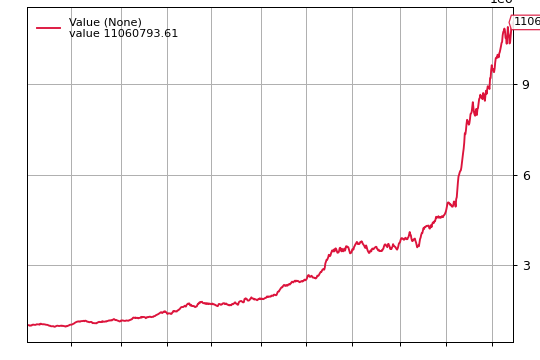

总资金: 11060793.61
净收益: 10060793.61
一共使用时间为:1060.936585187912


In [8]:
##########################
# 主程序开始
##########################


begin_time=time.time()
cerebro = bt.Cerebro(stdstats=False)
#cerebro.broker = bt.brokers.BackBroker(shortcash=True)  # 0.5%
#考虑印花税和佣金印花税为单边千分之一，佣金设为万五
comminfo=stampDutyCommissionScheme(stamp_duty=0.001,commission=0.0005)
cerebro.broker.addcommissioninfo(comminfo)

for s in stocklist_zz500:
    feed = Addmoredata(dataname = get_stock_data(s),plot=False,
                       fromdate=datetime.datetime(2017,1,3),todate=datetime.datetime(2020,6,30))
    cerebro.adddata(feed, name = s)


cerebro.broker.setcash(1000000.0)
#防止下单时现金不够被拒绝。只在执行时检查现金够不够。
cerebro.broker.set_checksubmit(False)
# 添加相应的费用，杠杆率
# 获取策略运行的指标
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

startcash=1000000.0
cerebro.addstrategy(momentum_factor_strategy) 
cerebro.addobserver(bt.observers.Value)

#添加Analyzer
cerebro.addanalyzer(
    bt.analyzers.SharpeRatio,
    riskfreerate=0.01,
    annualize=True,
    _name='sharp_ratio')
cerebro.addanalyzer(bt.analyzers.DrawDown, _name='drawdown')

thestrats = cerebro.run()
thestrat = thestrats[0]
# 输出分析器结果字典
print('Sharpe Ratio:', thestrat.analyzers.sharp_ratio.get_analysis())
print('DrawDown:', thestrat.analyzers.drawdown.get_analysis())

# 进一步从字典中取出需要的值
print('Sharpe Ratio:',
      thestrat.analyzers.sharp_ratio.get_analysis()['sharperatio'])
print('Max DrawDown:',
      thestrat.analyzers.drawdown.get_analysis()['max']['drawdown'])

# 打印各个分析器内容
for a in thestrat.analyzers:
    a.print()
cerebro.plot() 
#获取回测结束后的总资金
portvalue = cerebro.broker.getvalue()
pnl = portvalue - startcash
#打印结果
print(f'总资金: {round(portvalue,2)}')
print(f'净收益: {round(pnl,2)}')
end_time=time.time()
print("一共使用时间为:{}".format(end_time-begin_time))